## IMPORTS

In [1]:
# basic imports

import torch
from torch import nn, utils
from torch.utils.data import Dataset, ConcatDataset, TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import models, datasets, transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
import os

from IPython.display import display, clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## VISUALIZATION

In [2]:
### usual helpers for logging and visualisation:

class TrainingMetrics:
    def __init__(self):
        # initialise with empty lists for metric tracking:
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        self.stability_loss = [] # for LwF

        self.step = 0
        self.epoch = 0
        self.epoch_steps = [0] # assume validation happens after every epoch
        self.iter_steps = [0] # steps at which training iteration changes

        # for plotting:
        self.fig = None
        self.plot_axes = None

    def next_iteration(self):
        """increment the continual learning iteration"""
        self.iter_steps.append(self.step)
    
    def log_train(self, loss:float, acc:float, stability_loss:float=None):
        """record batch-wise training metrics at each step (and increment step).
        Optionally, include stability loss as well for visualising LwF training."""
        assert isinstance(loss, float) and isinstance(acc, float), f"log_train expects float inputs but got: {type(loss)} and {type(acc)}"
        self.train_loss.append(loss)
        self.train_acc.append(acc)

        if stability_loss is not None:
            self.stability_loss.append(stability_loss)

        self.step += 1

    def log_val(self, loss:float, acc:float):
        """record total val metrics at end of epoch (and increment epoch)"""
        assert isinstance(loss, float) and isinstance(acc, float), f"log_val expects float inputs but got: {type(loss)} and {type(acc)}"
        self.val_loss.append(loss)
        self.val_acc.append(acc)

        if len(self.train_loss) == 0:
            self.step += 1 # increment step if no training data has been logged
        else:
            assert self.step not in self.epoch_steps, f"Validation metrics already logged for epoch {self.epoch} - you should submit only the aggregate metrics at end of epoch"""            
        self.epoch_steps.append(self.step)
        self.epoch += 1

    @property
    def epoch_loss(self):
        """report the training and validation loss over the previous epoch"""
        cur_epoch_step = self.epoch_steps[-1]
        last_epoch_step = self.epoch_steps[-2]
        epoch_train_loss = self.train_loss[last_epoch_step:cur_epoch_step]
        epoch_val_loss = self.val_loss[-1]
        return np.mean(epoch_train_loss), np.mean(epoch_val_loss)

    @property        
    def epoch_acc(self):
        """report the training and validation accuracy over the previous epoch"""
        cur_epoch_step = self.epoch_steps[-1]
        last_epoch_step = self.epoch_steps[-2]
        epoch_train_acc = self.train_acc[last_epoch_step:cur_epoch_step]
        epoch_val_acc = self.val_acc[-1]
        return np.mean(epoch_train_acc), np.mean(epoch_val_acc)

    @property
    def best_val_acc(self):
        return np.max(self.val_acc)


    def plot(self,
             title:str = None, # optional figure title
             baseline_accs: dict[str:float] = None, # optional dict of name->accuracy baseline benchmarks
             baseline_metrics = None, # optional metrics object for comparison curves
             alpha=0.1, # smoothing parameter for train loss
             live=True, # for animated plotting during training (slightly experimental)
             max_step=0, # should be set to the expected number of steps for animated plots
             show_iterations=True, # whether to display separated lines for CL iterations
             ):
        if (self.fig is None) or (not live):
            self.fig, self.plot_axes = plt.subplots(1,2)
        loss_ax, acc_ax = self.plot_axes
        
        all_steps = np.arange(0, self.step)

        num_iters = len(self.iter_steps)-1 if show_iterations else 1

        loss_ax.clear()
        acc_ax.clear()
        for i in range(num_iters):
            step_start = self.iter_steps[i]
            step_end = self.iter_steps[i+1] if (i+1 < num_iters) else self.step

            x_step = np.arange(step_start, step_end)
            train_loss = self.train_loss[step_start:step_end]
            train_acc = self.train_acc[step_start:step_end]

            # include stability loss as a separate term
            if len(self.stability_loss) > 0:
                stability_loss = self.stability_loss[step_start:step_end]
            else:
                stability_loss = None

            epoch_steps_this_iter = [s for s in self.epoch_steps[1:] if step_start < s <= step_end]
            epoch_idxs_this_iter = [i for i,s in enumerate(self.epoch_steps[1:]) if step_start < s <= step_end]

            val_loss = [self.val_loss[i] for i in epoch_idxs_this_iter]
            val_acc = [self.val_acc[i] for i in epoch_idxs_this_iter]
            
            # smooth out the per-step training numbers for neater curves:
            smooth_train_loss = pd.Series(train_loss).ewm(alpha=alpha).mean()
            smooth_train_acc = pd.Series(train_acc).ewm(alpha=alpha).mean()
    
            # plot train loss at every step:
            loss_ax.plot(x_step, smooth_train_loss, c='tab:orange', linestyle=':', label='train loss' if i==0 else None)

            # and stability loss if given:
            if stability_loss is not None:
                smooth_stab_loss = pd.Series(stability_loss).ewm(alpha=alpha).mean()
                loss_ax.plot(x_step, smooth_stab_loss, c='tab:green', linestyle=':', label='stability loss' if i==0 else None)
  
            # val loss is plotted at every epoch:
            loss_ax.plot(epoch_steps_this_iter, val_loss, c='tab:orange', linestyle='-', label='val loss' if i==0 else None)
    
    
            ### plot acc:
            if len(self.train_acc) > 0:
                acc_ax.plot(x_step, smooth_train_acc, c='tab:blue', linestyle=':', label='train acc' if i==0 else None)
            acc_ax.plot(epoch_steps_this_iter, val_acc, c='tab:blue', linestyle='-', label='val acc' if i==0 else None)
     
        
        if baseline_metrics is not None:
            # optionally show the training curves of a previous metric object as baseline
            # (by extracting the line data from the plots saved to that object)
            baseline_num_iters = len(baseline_metrics.iter_steps)-1
            num_base_lines = baseline_num_iters * 2
            
            assert len(baseline_metrics.stability_loss) == 0, "cannot plot a baseline with stability loss, it's too complicated sorry"
            baseline_train_xs = [baseline_metrics.plot_axes[0].lines[i].get_xdata() for i in range(0, num_base_lines, 2)]
            baseline_train_losses = [baseline_metrics.plot_axes[0].lines[i].get_ydata() for i in range(0, num_base_lines, 2)]
            baseline_val_xs = [baseline_metrics.plot_axes[0].lines[i].get_xdata() for i in range(1, num_base_lines, 2)]
            baseline_val_losses = [baseline_metrics.plot_axes[0].lines[i].get_ydata() for i in range(1, num_base_lines, 2)]
            baseline_train_accs = [baseline_metrics.plot_axes[1].lines[i].get_ydata() for i in range(0, num_base_lines, 2)]
            baseline_val_accs = [baseline_metrics.plot_axes[1].lines[i].get_ydata() for i in range(1, num_base_lines, 2)]

            for base_tx, base_tloss, base_tacc in zip(baseline_train_xs, baseline_train_losses, baseline_train_accs):
                loss_ax.plot(base_tx, base_tloss, c='lightgray', linestyle=':', label=None, zorder=-1)
                acc_ax.plot(base_tx, base_tacc, c='lightgray', linestyle=':', label=None, zorder=-1)
            for base_vx, base_vloss, base_vacc in zip(baseline_val_xs, baseline_val_losses, baseline_val_accs):
                loss_ax.plot(base_vx, base_vloss, c='lightgray', linestyle=':', label=None, zorder=-1)
                acc_ax.plot(base_vx, base_vacc, c='lightgray', linestyle=':', label=None, zorder=-1)
            baseline_end_step = max(base_tx)
        else:
            baseline_end_step = 0

        # format y-axis as percentage on right:
        acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
        acc_ax.yaxis.tick_right()
        acc_ax.yaxis.set_label_position('right')
    
        # draw line/s for comparison with baseline if given:
        if baseline_accs is not None:
            for b_name, b_acc in baseline_accs.items():
                acc_ax.axhline(b_acc, c=[0.8]*3, linestyle=':')
                # add text label as well:
                acc_ax.text(0, b_acc+0.003, b_name, c=[0.6]*3, size=8)

        # draw lines to demarcate CL iterations:
        if len(self.iter_steps) > 0:
            iter_steps = self.iter_steps if baseline_metrics is None else baseline_metrics.iter_steps
            for iter_step in iter_steps:
                loss_ax.axvline(iter_step, c=[0.8]*3, linestyle='--')
                acc_ax.axvline(iter_step, c=[0.8]*3, linestyle='--')
                
        # add epoch tick markers and legend:
        end_step = max(max_step, self.step) #, baseline_end_step)
        
        num_epochs = len(self.epoch_steps)
        if num_epochs > 1:
            num_expected_epochs = end_step // self.epoch_steps[1]
            tick_spacing = max(num_expected_epochs // 10, 1)
        else:
            tick_spacing = 1
            num_expected_epochs = 1
        loss_ax.set_xticks(self.epoch_steps[::tick_spacing], range(0, num_epochs, tick_spacing))
        loss_ax.tick_params(axis='both', which='minor', labelsize=6)
        loss_ax.set_xlabel('Epoch')
        loss_ax.set_ylabel('Loss')
        loss_ax.legend(); 
        
        # set x lims based on max number of steps
        loss_ax.set_xlim([0-(end_step*0.05), end_step*1.05])
        acc_ax.set_xlim([0-(end_step*0.05), end_step*1.05])
        acc_ax.set_xticks(self.epoch_steps[::tick_spacing], range(0, num_epochs, tick_spacing))
        acc_ax.tick_params(axis='both', which='minor', labelsize=6)
        
        acc_ax.set_xlabel('Epoch')
        acc_ax.set_ylabel('Accuracy (%)')
        acc_ax.legend()
        
        # and y lims based on the expectation that loss goes down and acc goes up
        loss_ax.set_ylim([-0.05, None])
        acc_ax.set_ylim([-0.05, 1.05])

        self.fig.suptitle(title)
        plt.tight_layout()

        if live:
            # redraw using ipython display
            clear_output(wait=True)
            display(self.fig)
        else:
            # just show plot normally
            plt.show()

### function to verify the contents and labels of a dataset object:
def inspect_dataset(dataset: Dataset,
                    layout=(4,4), # rows and cols of the grid to display
                    scale=0.7, 
                   ):
    """accepts a Dataset object
    and plots images from the data with optional class annotations"""
    num_examples = min([np.prod(layout), len(dataset)])
    example_idxs = np.random.choice(range(len(dataset)), num_examples, replace=False)

    if hasattr(dataset, 'data'):
        images = dataset.data
    else:
        images = dataset.tensors[0]

    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = dataset.tensors[1]
    
    images = [images[idx] for idx in example_idxs]
    targets = [targets[idx] for idx in example_idxs]


    if hasattr(dataset, 'name'):
        title = f'Dataset: {dataset.name}'
    else:
        title = None
    
    a = 0
    num_rows, num_cols = layout
    fig_width = 2 * scale * num_cols
    fig_height = 2.3 * scale * num_rows + ((title is not None) * 0.3)
    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))
    
    for r, row in enumerate(axes):
        for c, ax in enumerate(row):
            img = images[a]

            # if is tensor, cast to numpy:
            if isinstance(img, torch.Tensor):
                img = img.detach().cpu().numpy()
            
            # if is CHW, reshape to HWC:
            if img.shape[0] == 3:
                img = img.transpose([1,2,0])
                cmap = None
            else:
                cmap = 'Greys' # use black-and-white colourmap for mono images

            # unnormalise:
            if img.min() < 0:
                img = (img - img.min()) / (img.max() - img.min())
            
            ax.imshow(img, cmap=cmap)
            
            label = f'{targets[a]}: {dataset.classes[targets[a]]}'
            ax.set_title(label, fontsize=10*scale**0.5)
            
            # tidy up axis:
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
            a += 1

    fig.suptitle(title)
    fig.tight_layout()
    
    plt.show()        


### function for inspecting the correctness of the outputs of a model:
def inspect_batch(images: torch.Tensor, # batch of images as torch tensors
        labels: torch.Tensor=None,      # optional vector of ground truth label integers
        predictions: torch.Tensor=None, # optional vector/matrix of model predictions
        # display parameters:
        class_names: list[str]=None, # optional list or dict of class idxs to class name strings
        title: str=None,       # optional title for entire plot    
        # figure display/sizing params:
        center_title=True,
        max_to_show=25,
        num_cols = 5,
        scale=0.7,
        ):
    """accepts a batch of images as a torch tensor or list of tensors,
    and plots them in a grid for manual inspection.
    optionally, you can supply ground truth labels
    and/or model predictions, to display those as well."""

    if type(images) is tuple:
        raise Exception('Expected first input as torch.Tensor, but got tuple; make sure to pass images and labels separately!')
    
    max_to_show = min([max_to_show, len(images)]) # cap at number of images
    
    num_rows = int(np.ceil(max_to_show / num_cols))

    # add extra figure height if needed for captions:
    extra_height = (((labels is not None)*0.3 + (predictions is not None))*0.3)

    fig_width = 2 * scale * num_cols
    fig_height = (2+extra_height) * scale * num_rows + ((title is not None) * 0.3)
    
    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))
    all_axes = []
    for ax_row in axes:
        all_axes.extend(ax_row)

    # translate labels and predictions to class names if given:
    if class_names is not None:
        if labels is not None:
            labels = [f'{l}:{class_names[int(l)]}' for l in labels]
        if predictions is not None:
            if len(predictions.shape) == 2:
                # probability distribution or onehot vector, so argmax it:
                predictions = predictions.argmax(dim=1)
            predictions = [f'{p}:{class_names[int(p)]}' for p in predictions]
    
    for b, ax in enumerate(all_axes):
        if b < max_to_show:
            # rearrange to H*W*C:
            img = images[b].permute([1,2,0]) 
            # un-normalise:
            img = (img - img.min()) / (img.max() - img.min())
            # to numpy:
            img = img.cpu().detach().numpy()
            
            ax.imshow(img, cmap='Greys' if img.shape[2] == 1 else None)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

            if labels is not None:                    
                ax.set_title(f'{labels[b]}', fontsize=10*scale**0.5)
            if predictions is not None:
                ax.set_title(f'pred: {predictions[b]}', fontsize=10*scale**0.5)
            if labels is not None and predictions is not None:
                if labels[b] == predictions[b]:
                    ### matching prediction, mark as correct:
                    mark, color = '✔', 'green'
                else:
                    mark, color = '✘', 'red'
                
                ax.set_title(f'label:{labels[b]}    \npred:{predictions[b]} {mark}', color=color, fontsize=8*scale**0.5)
        else:
            ax.axis('off')
    if title is not None:
        if center_title:
            x, align = 0.5, 'center'
        else:
            x, align = 0, 'left'
        fig.suptitle(title, fontsize=14*scale**0.5, x=x, horizontalalignment=align)
    fig.tight_layout()
    plt.show()


def count_labels(dataset):
    """Print out a count of the individual classes in a classification dataset.
    If there are more than 10, show only the first and last 10."""
    assert dataset.classes is not None
    targets = dataset.targets
    label_counts = np.unique(targets, return_counts=True)[1]
    

    num_classes = len(dataset.classes)
    max_len = max([len(cl) for cl in dataset.classes])
    if isinstance(dataset.classes, dict):
        idxs, names = dataset.classes.keys(), dataset.classes.values()
    elif isinstance(dataset.classes, list):
        idxs, names = range(num_classes), dataset.classes

    if num_classes > 10:
        # show only the first 10
        show_idxs = list(range(5)) + list(range(num_classes))[-5:]
    else:
        show_idxs = list(range(num_classes))

    print(f'\n{dataset.name}: {len(dataset):,} samples')
    for idx, name in zip(idxs, names):
        num_samples = label_counts[idx]
        if idx in show_idxs:
            print(f'  {idx}: {name:<{max_len}} ({num_samples:,} samples)')
        elif idx == 5:
            print('  ...')
            


### class prediction accuracy:
def top1_acc(pred: torch.FloatTensor, 
             y: torch.LongTensor):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()  


## Data

For our dataset, we'll use [Fashion-MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist). This is a 10-way classification dataset on different types of clothing garments.

It has similar properties to the classic MNIST data - the same image resolution, number of classes and examples per class - but is a bit less trivial, so requires a slightly higher-capacity model that learns some more subtle features.

Below, we download the dataset and display some examples from it.

In [3]:
### download data:

fmnist = datasets.FashionMNIST(root='data/', download=True)
fmnist.name, fmnist.num_classes = 'Fashion-MNIST', len(fmnist.classes)

cifar10 = datasets.CIFAR10(root='data/', download=True)
cifar10.name, cifar10.num_classes = 'CIFAR-10', len(cifar10.classes)

cifar100 = datasets.CIFAR100(root='data/', download=True)
cifar100.name, cifar100.num_classes = 'Cifar-100', len(cifar100.classes)



### DATA SEPARATION AND PROCESSING

In [4]:
# quick function for displaying the classes of a task:
def inspect_task(task_data, title=None):
    num_task_classes = len(task_data.classes)
    task_classes = tuple([str(c) for c in task_data.classes])

    class_image_examples = [[batch[0] for batch in task_data if batch[1]==c][0] for c in range(num_task_classes)]
    _ = inspect_batch(class_image_examples, labels=task_classes, scale=0.7, num_cols=num_task_classes, title=title, center_title=False)


def divide_tasks(dataset, dataset_name:str, BATCH_SIZE:int=256):
    if dataset_name.lower() == 'fmnist':
        timestep_task_classes = {
            0: ['Pullover', 'Dress'],
            1: ['Trouser', 'Bag'],
            2: ['Ankle boot', 'Sneaker', 'Sandal'],
            3: ['T-shirt/top', 'Coat', 'Shirt'],
            }
        
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.25,))
        ])

    elif dataset_name.lower() == 'cifar-10':
        timestep_task_classes = {
            0: ["airplane", "ship"],
            1: ["automobile", "truck"],
            2: ["cat", "dog", "frog"],
            3: ["bird", "deer", "horse"],
            }
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.4914, 0.4822, 0.4465),
                std=(0.2470, 0.2435, 0.2616)
            )
        ])
    elif dataset_name.lower() == 'cifar-100':
        timestep_task_classes = {
        0: [  # aquatic mammals
            "beaver", "dolphin", "otter", "seal", "whale"
        ],
        1: [  # fish
            "aquarium_fish", "flatfish", "ray", "shark", "trout"
        ],
        2: [  # flowers
            "orchid", "poppy", "rose", "sunflower", "tulip"
        ],
        3: [  # food containers
            "bottle", "bowl", "can", "cup", "plate"
        ],
        4: [  # fruit and vegetables
            "apple", "mushroom", "orange", "pear", "sweet_pepper"
        ],
        5: [  # household electrical devices
            "clock", "keyboard", "lamp", "telephone", "television"
        ],
        6: [  # household furniture
            "bed", "chair", "couch", "table", "wardrobe"
        ],
        7: [  # insects
            "bee", "beetle", "butterfly", "caterpillar", "cockroach"
        ],
        8: [  # large carnivores
            "bear", "leopard", "lion", "tiger", "wolf"
        ],
        9: [  # large man-made outdoor things
            "bridge", "castle", "house", "road", "skyscraper"
        ],
        10: [  # large natural outdoor scenes
            "cloud", "forest", "mountain", "plain", "sea"
        ],
        11: [  # large omnivores and herbivores
            "camel", "cattle", "chimpanzee", "elephant", "kangaroo"
        ],
        12: [  # medium-sized mammals
            "fox", "porcupine", "possum", "raccoon", "skunk"
        ],
        13: [  # non-insect invertebrates
            "crab", "lobster", "snail", "spider", "worm"
        ],
        14: [  # people
            "baby", "boy", "girl", "man", "woman"
        ],
        15: [  # reptiles
            "crocodile", "dinosaur", "lizard", "snake", "turtle"
        ],
        16: [  # small mammals
            "hamster", "mouse", "rabbit", "shrew", "squirrel"
        ],
        17: [  # trees
            "maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"
        ],
        18: [  # vehicles 1
            "bicycle", "bus", "motorcycle", "pickup_truck", "train"
        ],
        19: [  # vehicles 2
            "lawn_mower", "rocket", "streetcar", "tank", "tractor"
        ],
    }


        # image preprocessing transform:
        preprocess = transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(15),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.5071, 0.4867, 0.4408),
                std=(0.2675, 0.2565, 0.2761)
            )
        ])

    # data/loader constants:
    VAL_FRAC = 0.1     # validation hold-out per task
    TEST_FRAC = 0.05   # for final test set containing all tasks

    # build task datasets for each timestep:
    timestep_tasks = {}
    timestep_loaders = {}

    task_test_sets = []

    for t, task_classes in timestep_task_classes.items():
        task_class_labels = [dataset.class_to_idx[cl] for cl in task_classes] # original labels in fmnist source data
        task_datapoint_idxs = [i for i,label in enumerate(dataset.targets) if label in task_class_labels]
        
        task_datapoints = [dataset[idx] for idx in task_datapoint_idxs]
        
        class_to_idx = {task_classes[t]: t for t in range(len(task_classes))}
        
        task_images = [preprocess(img) for (img, label) in task_datapoints]
        task_labels = [class_to_idx[dataset.classes[label]] for (img, label) in task_datapoints] # new labels

        # in addition to the images and labels, each task dataset now comes with a 'task id'
        # that tells the model which learned task to perform:
        task_ids = [t] * len(task_datapoints)
        
        task_image_tensor = torch.Tensor(torch.stack(task_images))
        task_label_tensor = torch.Tensor(task_labels).long()
        task_id_tensor = torch.Tensor(task_ids).long()
        
        task_data = TensorDataset(task_image_tensor, task_label_tensor, task_id_tensor)

        # train/validation split:
        train_frac  = 1.0 - VAL_FRAC - TEST_FRAC
        task_train, task_val, task_test = utils.data.random_split(task_data, [train_frac, VAL_FRAC, TEST_FRAC])
        
        # set dataset attributes to reflect what they contain:
        for data in (task_train, task_val, task_test):
            data.classes      = task_classes
            data.num_classes  = len(task_classes)
            data.class_to_idx = class_to_idx
            data.task_id      = t

        # inspect samples of both classes:
        print(f'Time={t} | Task ID {t} | {len(task_train):,} train | {len(task_val):,} validation | {len(task_test):,} test')
        inspect_task(task_train)

        # add train/val data to timestep dict, and test data to the list of test sets
        timestep_tasks[t] = task_train, task_val
        task_test_sets.append(task_test)


    # for final evaluation of the model, we evaluate on all task test sets jointly:
    final_test_data = ConcatDataset(task_test_sets)
    final_test_loader = DataLoader(final_test_data, 
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    print(f'Final test set size (containing all tasks): {len(final_test_data):,}\n')


    # and we will also run a joint training loop on the whole training dataset at once to see upper bound performance
    joint_train_data = ConcatDataset([train for train,val in timestep_tasks.values()])
    joint_train_loader = DataLoader(joint_train_data, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)

    print(f'Joint training set size (containing all tasks): {len(joint_train_data):,}')

    return task_train, timestep_task_classes, timestep_tasks, task_test_sets


## MODELS


In [5]:
### model architecture hyperparameters:
NUM_CONV_FEATURES = [32, 64, 64, 128]
TASK_HEAD_PROJECTION_SIZE = 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Conv4Backbone(nn.Module):
    def __init__(self, 
                 input_size,  # passed as a parameter to allow flexibility between datasets
                 layers=NUM_CONV_FEATURES, # list of conv layer num_kernels
                 device=device,
                ):
        super().__init__()

        in_channels, in_h, in_w = input_size        

        # build the sequential stack of conv layers:
        conv_layers = []
        prev_layer_size = in_channels
        for layer_size in layers:
            conv_layers.append(nn.Conv2d(prev_layer_size, layer_size, (3,3), padding='same'))
            conv_layers.append(nn.GroupNorm(num_groups=layer_size//4, num_channels=layer_size))
            conv_layers.append(nn.ReLU())
            prev_layer_size = layer_size
            
        self.conv_stack = torch.nn.Sequential(*conv_layers)
        
        # global average pooling to reduce to single dimension:
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        
        # number of output features:
        self.num_features = prev_layer_size
        
        self.relu = nn.ReLU()

        self.device = device
        self.to(device)
    
    def forward(self, x):
        # pass through conv layers:
        x = self.conv_stack(x)
        
        # downsample and reshape to vector:
        x = self.pool(x)
        x = x.view(-1, self.num_features)

        # return feature vector:
        return x

### as before, define a classification head that we can attach to the backbone:
class TaskHead(nn.Module):
    def __init__(self, 
                 num_classes: int,      # number of output neurons
                 input_size: int = NUM_CONV_FEATURES[-1], # number of features in the backbone's output
                 projection_size: int = TASK_HEAD_PROJECTION_SIZE,  # number of neurons in the hidden layer
                 dropout: float=0.,     # optional dropout rate to apply
                 device=device):
        super().__init__()
        
        self.projection = nn.Linear(input_size, projection_size)
        self.classifier = nn.Linear(projection_size, num_classes)

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.Identity()

        self.relu = nn.ReLU()

        self.device = device
        self.to(device)

    def forward(self, x):
        # assume x is already unactivated feature logits,
        # e.g. from resnet backbone
        x = self.projection(self.relu(self.dropout(x)))
        x = self.classifier(self.relu(self.dropout(x)))

        return x


### and a model that contains a backbone plus multiple class heads,
### and performs task-ID routing at runtime, allowing it to perform any learned task:
class MultitaskModel(nn.Module):
    def __init__(self, backbone: nn.Module, 
                 device=device):
        super().__init__()

        self.backbone = backbone

        # a dict mapping task IDs to the classification heads for those tasks:
        self.task_heads = nn.ModuleDict()        
        # we must use a nn.ModuleDict instead of a base python dict,
        # to ensure that the modules inside are properly registered in self.parameters() etc.

        self.relu = nn.ReLU()
        self.device = device
        self.to(device)

    def forward(self, 
                x: torch.Tensor, 
                task_id: int):
        
        task_id = str(int(task_id))
        # nn.ModuleDict requires string keys for some reason,
        # so we have to be sure to cast the task_id from tensor(2) to 2 to '2'
        
        assert task_id in self.task_heads, f"no head exists for task id {task_id}"
        
        # select which classifier head to use:
        chosen_head = self.task_heads[task_id]

        # activated features from backbone:
        x = self.relu(self.backbone(x))
        # task-specific prediction:
        x = chosen_head(x)

        return x

    def add_task(self, 
                 task_id: int, 
                 head: nn.Module):
        """accepts an integer task_id and a classification head
        associated to that task.
        adds the head to this model's collection of task heads."""
        self.task_heads[str(task_id)] = head.to(self.device)

    @property
    def num_task_heads(self):
        return len(self.task_heads)

### EVALUATION

In [6]:

#### basic evaluation function for a multitask model
#### over some specified validation loader,
#### expecting the correct task IDs:
def evaluate_model(multitask_model: nn.Module,  # trained model capable of multi-task classification
                   val_loader: utils.data.DataLoader,  # task-specific data to evaluate on
                   loss_fn: nn.modules.loss._Loss = nn.CrossEntropyLoss(),
                  ):
    """runs model on entirety of validation loader,
    with specified loss and accuracy functions,
    and returns average loss/acc over all batches"""
    multitask_model.eval()
    with torch.no_grad():
        batch_val_losses, batch_val_accs = [], []
    
        for batch in val_loader:
            vx, vy, task_ids = batch
            vx, vy = vx.to(device), vy.to(device)
            
            vpred = multitask_model(vx, task_ids[0])
            val_loss = loss_fn(vpred, vy)
            val_acc = top1_acc(vpred, vy)
            
            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
    return np.mean(batch_val_losses), np.mean(batch_val_accs)


#### we will also evaluate the model on the test sets of all the tasks seen so far,
#### which also lets us see the final overall performance at the end of the run
def full_test_evaluate(multitask_model: nn.Module,   # trained model capable of multi-task classification
                  selected_test_sets: list[utils.data.Dataset], # task-specific test sets to evaluate on
                  prev_accs: list[list[float]] = None, # previous taskwise accuracies of this model,
                                                       # to show catastrophic forgetting gaps
                  show_taskwise_accuracy=True, # show bar plot indicating performance on each separate task
                  baseline_taskwise_accs: list[float]=None, # optional baseline performance on each task for comparison
                  model_name: str='', # optional model name to show in plots
                  verbose=False, # more detailed output to console
                 ):
    if verbose:
        print(f'{model_name} evaluation on test set of all tasks:'.capitalize())

    task_test_losses = []
    task_test_accs = []

    for t, test_data in enumerate(selected_test_sets):
        test_loader = utils.data.DataLoader(test_data, 
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)
        
        task_test_loss, task_test_acc = evaluate_model(multitask_model, test_loader)

        if verbose:
            print(f'{test_data.classes}: {task_test_acc:.2%}')
            if baseline_taskwise_accs is not None:
                print(f'(baseline: {baseline_taskwise_accs[t]:.2%})')
        
        task_test_losses.append(task_test_loss)
        task_test_accs.append(task_test_acc)
        
    avg_task_test_loss = np.mean(task_test_losses)
    avg_task_test_acc = np.mean(task_test_accs)

    if verbose:
        print(f'\n +++ AVERAGE TASK TEST ACCURACY: {avg_task_test_acc:.2%} +++ ')


    if show_taskwise_accuracy:
        bar_heights = task_test_accs + [0]*(len(task_test_sets) - len(selected_test_sets))
        # display bar plot with accuracy on each evaluation task
        plt.bar(x = range(len(task_test_sets)), height=bar_heights, zorder=1, alpha=0.9)
        plt.xticks(range(len(task_test_sets)), [',\n'.join(task.classes) for task in task_test_sets]) #, rotation='vertical')
        plt.axhline(avg_task_test_acc, c=[0.2]*3, linestyle=':')
        plt.text(1, avg_task_test_acc+0.01, f'{model_name} (average)', c=[0.2]*3, size=8)

        if prev_accs is not None:
            # plot the previous step's accuracies on top
            # (will show forgetting in red)
            for p, prev_acc_list in enumerate(prev_accs):
                plt.bar(x = range(len(prev_acc_list)), height=prev_acc_list, fc='tab:red', zorder=0, alpha=0.5*((p+1)/len(prev_accs)))

        if baseline_taskwise_accs is not None:
            for t, acc in enumerate(baseline_taskwise_accs):
                plt.plot([t-0.4, t+0.4], [acc, acc], c=[0.6]*3, linestyle='--', label=f'baseline at t={len(baseline_taskwise_accs)-1}' if t==0 else None)
            plt.legend()
            # show average as well:
            baseline_avg = np.mean(baseline_taskwise_accs)
            plt.axhline(baseline_avg, c=[0.6]*3, linestyle=':')
            plt.text(1, baseline_avg-0.025, f'baseline at t={len(baseline_taskwise_accs)-1} (average)', c=[0.6]*3, size=8)

        plt.title(f'{model_name}: Test-time evaluation on all known tasks')    
        plt.show()
    
    return task_test_accs

### BASELINE TRAINING


In [7]:
def baseline_model_training(timestep_tasks, task_test_sets, INPUT_SIZE):
    torch.manual_seed(0)
    # define backbone and place it inside the multitask model:
    backbone = Conv4Backbone(input_size=INPUT_SIZE)
    multitask_model = MultitaskModel(backbone)

    # CL hyperparameters:
    epochs_per_timestep = 10    # how many epochs to run before switching to next task

    ### training hyperparameters:
    lr     = 1e-3  # initial learning rate
    l2_reg = 1e-4  # L2 weight decay term (0 means no regularisation)

    ### metrics and plotting:     
    dynamic_plot  = False   # show training plots after each timestep
    show_progress = True   # show progress bars and end-of-epoch metrics
    verbose       = True   # output extra info to console

        
    # define loss and optimiser:
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(multitask_model.parameters(), lr=lr, weight_decay=l2_reg)

    # some variables for plotting:
    metrics = TrainingMetrics()
    baseline_prev_test_accs = [] # test accuracy on previous tasks, to monitor forgetting
    total_train_steps = int(sum([epochs_per_timestep * np.ceil(len(train_set)/BATCH_SIZE) 
                                    for (train_set, val_set) in timestep_tasks.values()]))

    # outer loop over each task, in sequence
    for t, (task_train, task_val) in timestep_tasks.items():

        if verbose:
            print(f'Training on task id: {t}  (classification between: {task_train.classes})')
            inspect_task(task_train)
        
        if t not in multitask_model.task_heads:
            if verbose:
                print(f'  Adding new task head {t} to multi-task model')
                
            task_head = TaskHead(num_classes = task_train.num_classes)
            multitask_model.add_task(t, task_head)

        # build train and validation loaders for the current task:
        train_loader, val_loader = [utils.data.DataLoader(data, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)
                                    for data in (task_train, task_val)]

        # inner loop over the current task:
        for e in range(epochs_per_timestep):
            epoch_train_losses, epoch_train_accs = [], []

            if show_progress:
                # set a progress bar to loop over
                batch_iter = tqdm(train_loader, ncols=100)
            else:
                batch_iter = train_loader

            multitask_model.train()
            for step, batch in enumerate(batch_iter):
                # get the image-label pair from the dataloader batch,
                # along with the task ID, which should be the same number across the whole batch
                x, y, task_ids = batch
                x, y = x.to(device), y.to(device)
        
                opt.zero_grad()

                # verify that task IDs are all the same, just in case:
                assert torch.all(task_ids == task_ids[0]), "mismatching task IDs within batch"
                task_id = task_ids[0]

                pred = multitask_model(x, task_id) # important to send task ID to the model!
                
                batch_loss = loss_fn(pred, y)
                batch_acc = top1_acc(pred, y)
        
                batch_loss.backward()
                opt.step()
        
                # track loss and accuracy:
                metrics.log_train(loss=batch_loss.item(), acc=batch_acc)
                

                if show_progress:
                    # show loss/acc of this batch in progress bar:
                    report = (f'E{e} batch loss:{batch_loss:.2f}, batch acc:{batch_acc:>5.1%}')
                    batch_iter.set_description(report)

            # evaluate after each epoch::
            val_loss, val_acc = evaluate_model(multitask_model, val_loader, loss_fn)
            metrics.log_val(loss=val_loss, acc=val_acc)
            
            # report summary metrics:
            epoch_train_loss, epoch_val_loss = metrics.epoch_loss
            epoch_train_acc, epoch_val_acc = metrics.epoch_acc
            print(f'epoch:{e:>3} | loss: {epoch_train_loss:.2f} | {epoch_val_loss:.2f}   ' +
            f'acc: {epoch_train_acc:.1%} | {epoch_val_acc:.1%}')
                


        metrics.next_iteration() # increment CL timestep for plotting
        
        metrics.plot(title=f'Continual training at time {t}: Baseline model', live=False,
                    max_step = total_train_steps)

        # evaluate on all tasks so far, and save the performance:
        task_test_accs = full_test_evaluate(multitask_model, task_test_sets[:t+1], model_name=f'baseline at t={t}', 
                                            prev_accs = baseline_prev_test_accs, verbose=True)
        baseline_prev_test_accs.append(task_test_accs)

    # record the baseline performance for later comparison with your CL implementation
    baseline_metrics = metrics
    baseline_taskwise_test_accs = task_test_accs

    baseline_avg_test_acc = np.mean(baseline_taskwise_test_accs)
    print(f'\n=== Baseline final accuracy averaged over all test tasks: {baseline_avg_test_acc:.2%} ===')


### EWC IMPLEMENTATION

In [8]:
class EWC:
    """
    Elastic Weight Consolidation (EWC) for continual learning.
    Only regularizes parameters in the backbone (shared model), not task heads.
    """
    def __init__(self, model: nn.Module, dataloader: DataLoader, device=device):
        self.model = model
        self.device = device
        
        # Only store backbone parameters
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() 
                       if p.requires_grad and 'backbone' in n}
        self.fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters() 
                       if p.requires_grad and 'backbone' in n}
        
        self.model.eval()
        self._compute_fisher(dataloader)

    def _compute_fisher(self, dataloader: DataLoader):
        # zero fisher
        for n in self.fisher:
            self.fisher[n].zero_()

        for x, y, task_ids in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            task_id = task_ids[0]

            self.model.zero_grad()
            output = self.model(x, task_id)
            loss = F.cross_entropy(output, y)
            loss.backward()

            for n, p in self.model.named_parameters():
                if p.requires_grad and n in self.fisher and p.grad is not None:
                    self.fisher[n] += (p.grad ** 2) / len(dataloader)

        # detach to avoid tracking in autograd
        for n in self.params:
            self.params[n] = self.params[n].clone().detach()
        for n in self.fisher:
            self.fisher[n] = self.fisher[n].clone().detach()

    def penalty(self, model: nn.Module):
        """Compute EWC penalty for current model parameters (backbone only)."""
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.fisher:
                loss += (self.fisher[n] * (p - self.params[n]) ** 2).sum()
        return loss


# -------------------------------
# EWC Training Loop
# -------------------------------
def train_ewc(model, timestep_tasks, ewc_lambda=500, epochs_per_task=10,
              batch_size=64, lr=15e-4, l2_reg=1e-4):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2_reg)
    metrics = TrainingMetrics()
    ewc_objects = []  # store EWC info for previous tasks
    
    for t, (task_train, task_val) in timestep_tasks.items():
        print(f'\n=== Training Task {t} ===')

        # Add task head if needed
        if t not in model.task_heads:
            model.add_task(t, TaskHead(num_classes=task_train.num_classes))
            # Recreate optimizer to include new head parameters
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2_reg)

        train_loader = DataLoader(task_train, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(task_val, batch_size=batch_size, shuffle=False)

        # Epoch loop
        for e in range(epochs_per_task):
            model.train()
            batch_iter = tqdm(train_loader, ncols=100, desc=f'Task {t} | Epoch {e}')
            for x, y, task_ids in batch_iter:
                x, y = x.to(device), y.to(device)
                task_id = task_ids[0]

                opt.zero_grad()
                pred = model(x, task_id)
                loss = F.cross_entropy(pred, y)

                # EWC penalty from previous tasks
                if ewc_objects:
                    ewc_loss = sum([ewc.penalty(model) for ewc in ewc_objects])
                    loss += ewc_lambda * ewc_loss

                loss.backward()
                opt.step()

                batch_acc = top1_acc(pred, y)
                metrics.log_train(loss.item(), batch_acc)

            # Validation after each epoch
            val_loss, val_acc = evaluate_model(model, val_loader, F.cross_entropy)
            metrics.log_val(val_loss, val_acc)
            epoch_train_loss, epoch_val_loss = metrics.epoch_loss
            epoch_train_acc, epoch_val_acc = metrics.epoch_acc
            print(f"Task {t} | Epoch {e} | "
                  f"loss: {epoch_train_loss:.3f}/{epoch_val_loss:.3f} | "
                  f"acc: {epoch_train_acc:.1%}/{epoch_val_acc:.1%}")

        # Store EWC info for this task (backbone only)
        ewc_objects.append(EWC(model, train_loader, device=device))

        metrics.next_iteration()
        metrics.plot(title=f"EWC Continual Training: Task {t}", live=False,
                     max_step=total_train_steps)

        # Evaluate on all tasks seen so far
        task_test_accs = full_test_evaluate(model, task_test_sets[:t+1],
                                            model_name=f'EWC at t={t}',
                                            prev_accs=baseline_prev_test_accs,
                                            verbose=True)
        baseline_prev_test_accs.append(task_test_accs)

    return model, metrics


### EWC TRAINING LOOP

In [9]:
def train_ewc_loop(timestep_tasks, task_test_sets, INPUT_SIZE, use_selfpaced=False):    
    # Set up
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    backbone = Conv4Backbone(INPUT_SIZE)
    multitask_model = MultitaskModel(backbone).to(device)

    ewc_lambda = 2000  # EWC regularization strength
    epochs_per_task = 10
    metrics = TrainingMetrics()
    baseline_prev_test_accs = []
    BATCH_SIZE = 32
    lr = 1e-4
    l2_reg = 1e-4

    epochs_per_timestep = 10    # how many epochs to run before switching to next task
    total_train_steps = int(sum([epochs_per_timestep * np.ceil(len(train_set)/BATCH_SIZE) 
                                    for (train_set, val_set) in timestep_tasks.values()]))

    ewc_objects = []  # store EWC info for previous tasks
    
    # Self-paced learning parameters
    if use_selfpaced:
        selfpaced_threshold = 0.1  # Initial threshold for easy samples
        selfpaced_growth_rate = 1.2  # How much to increase threshold each epoch
        selfpaced_max_threshold = 2.0  # Maximum threshold

    # Outer loop: sequential tasks
    for t, (task_train, task_val) in timestep_tasks.items():
        print(f"\n=== Training Task {t} ===")
        if use_selfpaced:
            print(f"  Using self-paced curriculum learning with EWC")
        
        # Add new task head if not already present
        if t not in multitask_model.task_heads:
            multitask_model.add_task(t, TaskHead(num_classes=task_train.num_classes))
            # Recreate optimizer to include new head
            opt = torch.optim.AdamW(multitask_model.parameters(), lr=lr, weight_decay=l2_reg)
        
        train_loader = DataLoader(task_train, batch_size=BATCH_SIZE, shuffle=True)
        val_loader   = DataLoader(task_val, batch_size=BATCH_SIZE, shuffle=False)
        
        # Epoch loop
        for e in range(epochs_per_task):
            multitask_model.train()
            for x, y, task_ids in train_loader:
                x, y = x.to(device), y.to(device)
                task_id = task_ids[0]

                opt.zero_grad()
                pred = multitask_model(x, task_id)
                
                # Get per-sample losses
                per_sample_loss = F.cross_entropy(pred, y, reduction='none')
                
                if use_selfpaced:
                    # Self-paced curriculum: only train on easy samples (loss < threshold)
                    easy_mask = per_sample_loss < selfpaced_threshold
                    
                    # If no easy samples, use all samples
                    if easy_mask.sum() == 0:
                        easy_mask = torch.ones_like(easy_mask, dtype=torch.bool)
                    
                    # Calculate loss only on easy samples
                    loss = per_sample_loss[easy_mask].mean()
                    batch_acc = top1_acc(pred[easy_mask], y[easy_mask])
                else:
                    # Standard training: use all samples
                    loss = per_sample_loss.mean()
                    batch_acc = top1_acc(pred, y)

                # Apply EWC penalty only to backbone
                if ewc_objects:
                    ewc_loss = sum([ewc.penalty(multitask_model) for ewc in ewc_objects])
                    loss += ewc_lambda * ewc_loss

                loss.backward()
                opt.step()
                
                # Log metrics
                metrics.log_train(loss.item(), batch_acc)
            
            # Increase threshold for self-paced learning
            if use_selfpaced and e < epochs_per_timestep - 1:
                selfpaced_threshold = min(selfpaced_threshold * selfpaced_growth_rate, 
                                         selfpaced_max_threshold)
            
            # Validation at the end of each epoch
            val_loss, val_acc = evaluate_model(multitask_model, val_loader, F.cross_entropy)
            metrics.log_val(val_loss, val_acc)
            epoch_train_loss, epoch_val_loss = metrics.epoch_loss
            epoch_train_acc, epoch_val_acc = metrics.epoch_acc
            print(f"Task {t} | Epoch {e} | "
                f"loss: {epoch_train_loss:.3f}/{epoch_val_loss:.3f} | "
                f"acc: {epoch_train_acc:.1%}/{epoch_val_acc:.1%}")
            if use_selfpaced:
                print(f"  self-paced threshold: {selfpaced_threshold:.3f}")
        
        # After finishing the task, store backbone Fisher info
        ewc_objects.append(EWC(multitask_model, train_loader, device=device))
        
        metrics.next_iteration()
        title = f"EWC Continual Training: Task {t}"
        if use_selfpaced:
            title = f"Self-paced EWC Continual Training: Task {t}"
        metrics.plot(title=title, live=False, max_step=total_train_steps)
        
        # Evaluate on all tasks seen so far
        model_name = f'EWC at t={t}'
        if use_selfpaced:
            model_name = f'selfpaced EWC at t={t}'
        task_test_accs = full_test_evaluate(multitask_model, task_test_sets[:t+1],
                                            model_name=model_name,
                                            prev_accs=baseline_prev_test_accs,
                                            verbose=True)
        baseline_prev_test_accs.append(task_test_accs)
    
    return multitask_model, metrics


## FMNIST

### DATA PREPARATION

Time=0 | Task ID 0 | 10,200 train | 1,200 validation | 600 test


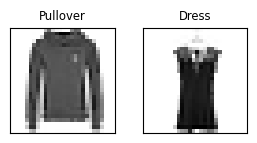

Time=1 | Task ID 1 | 10,200 train | 1,200 validation | 600 test


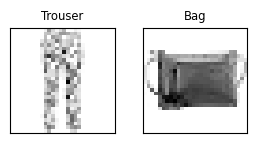

Time=2 | Task ID 2 | 15,300 train | 1,800 validation | 900 test


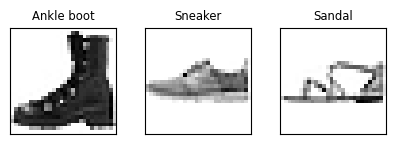

Time=3 | Task ID 3 | 15,300 train | 1,800 validation | 900 test


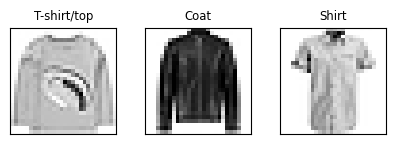

Final test set size (containing all tasks): 3,000

Joint training set size (containing all tasks): 51,000


In [10]:
BATCH_SIZE = 256
task_train, timestep_task_classes, timestep_tasks, task_test_sets = divide_tasks(fmnist, 'fmnist', BATCH_SIZE=BATCH_SIZE)

### BASELINE TRAINING

Training on task id: 0  (classification between: ['Pullover', 'Dress'])


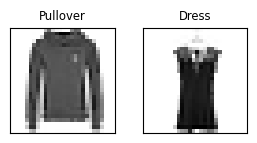

  Adding new task head 0 to multi-task model


E0 batch loss:0.33, batch acc:91.2%: 100%|██████████████████████████| 40/40 [00:01<00:00, 23.36it/s]


epoch:  0 | loss: 0.44 | 0.29   acc: 86.1% | 95.6%


E1 batch loss:0.24, batch acc:97.2%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.97it/s]


epoch:  1 | loss: 0.28 | 0.30   acc: 94.0% | 91.4%


E2 batch loss:0.25, batch acc:94.0%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.59it/s]


epoch:  2 | loss: 0.25 | 0.22   acc: 94.7% | 95.8%


E3 batch loss:0.25, batch acc:93.5%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.79it/s]


epoch:  3 | loss: 0.22 | 0.20   acc: 95.9% | 97.1%


E4 batch loss:0.19, batch acc:96.8%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.44it/s]


epoch:  4 | loss: 0.21 | 0.22   acc: 95.7% | 94.9%


E5 batch loss:0.18, batch acc:97.2%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.77it/s]


epoch:  5 | loss: 0.19 | 0.17   acc: 96.5% | 97.4%


E6 batch loss:0.16, batch acc:98.1%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.70it/s]


epoch:  6 | loss: 0.18 | 0.17   acc: 96.5% | 97.3%


E7 batch loss:0.20, batch acc:95.4%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.91it/s]


epoch:  7 | loss: 0.17 | 0.16   acc: 96.8% | 97.0%


E8 batch loss:0.13, batch acc:98.1%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.13it/s]


epoch:  8 | loss: 0.16 | 0.16   acc: 97.2% | 96.9%


E9 batch loss:0.16, batch acc:96.8%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.76it/s]


epoch:  9 | loss: 0.15 | 0.15   acc: 97.1% | 97.2%


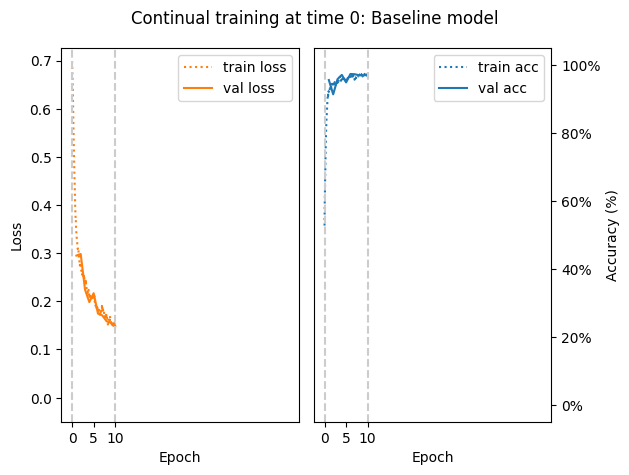

Baseline at t=0 evaluation on test set of all tasks:
['Pullover', 'Dress']: 97.80%

 +++ AVERAGE TASK TEST ACCURACY: 97.80% +++ 


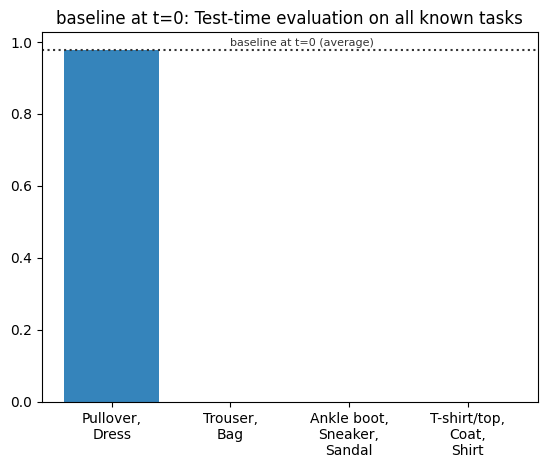

Training on task id: 1  (classification between: ['Trouser', 'Bag'])


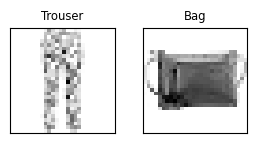

  Adding new task head 1 to multi-task model


E0 batch loss:0.23, batch acc:97.7%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.90it/s]


epoch:  0 | loss: 0.43 | 0.23   acc: 83.3% | 97.7%


E1 batch loss:0.16, batch acc:99.5%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.02it/s]


epoch:  1 | loss: 0.19 | 0.16   acc: 98.5% | 99.1%


E2 batch loss:0.14, batch acc:99.1%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.03it/s]


epoch:  2 | loss: 0.15 | 0.13   acc: 99.3% | 99.7%


E3 batch loss:0.17, batch acc:96.3%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.52it/s]


epoch:  3 | loss: 0.13 | 0.12   acc: 99.1% | 99.5%


E4 batch loss:0.12, batch acc:99.1%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.99it/s]


epoch:  4 | loss: 0.12 | 0.11   acc: 99.3% | 99.6%


E5 batch loss:0.10, batch acc:99.5%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.01it/s]


epoch:  5 | loss: 0.11 | 0.11   acc: 99.2% | 99.2%


E6 batch loss:0.09, batch acc:99.5%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.87it/s]


epoch:  6 | loss: 0.10 | 0.09   acc: 99.2% | 99.8%


E7 batch loss:0.09, batch acc:99.1%: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.95it/s]


epoch:  7 | loss: 0.09 | 0.08   acc: 99.4% | 99.8%


E8 batch loss:0.08, batch acc:99.5%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.04it/s]


epoch:  8 | loss: 0.09 | 0.08   acc: 99.5% | 99.8%


E9 batch loss:0.08, batch acc:99.1%: 100%|██████████████████████████| 40/40 [00:01<00:00, 27.10it/s]


epoch:  9 | loss: 0.08 | 0.07   acc: 99.4% | 99.7%


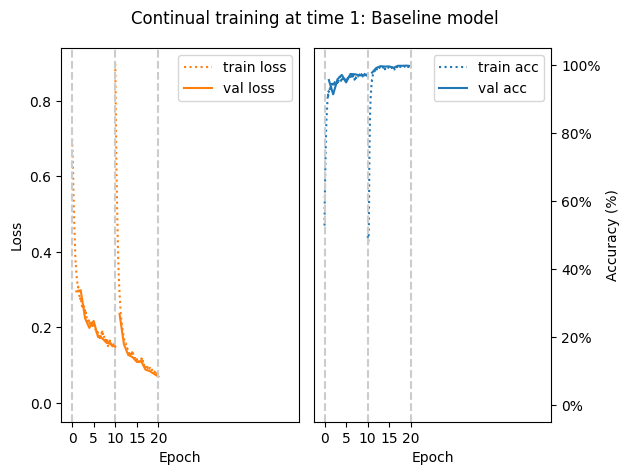

Baseline at t=1 evaluation on test set of all tasks:
['Pullover', 'Dress']: 46.91%
['Trouser', 'Bag']: 99.23%

 +++ AVERAGE TASK TEST ACCURACY: 73.07% +++ 


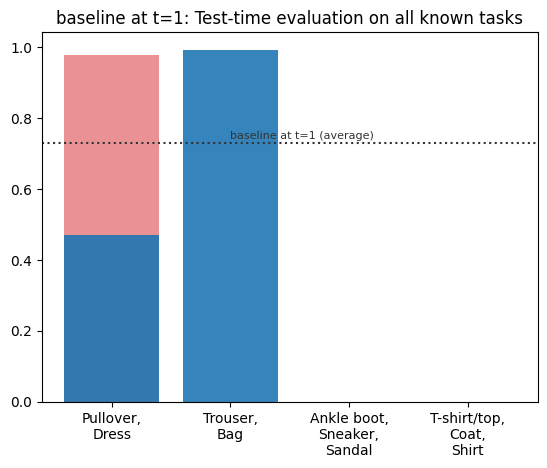

Training on task id: 2  (classification between: ['Ankle boot', 'Sneaker', 'Sandal'])


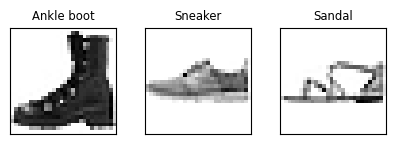

  Adding new task head 2 to multi-task model


E0 batch loss:0.57, batch acc:85.2%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.29it/s]


epoch:  0 | loss: 0.77 | 0.57   acc: 71.2% | 81.5%


E1 batch loss:0.40, batch acc:88.8%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.21it/s]


epoch:  1 | loss: 0.50 | 0.53   acc: 84.7% | 82.1%


E2 batch loss:0.31, batch acc:93.4%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.31it/s]


epoch:  2 | loss: 0.41 | 0.36   acc: 87.9% | 89.9%


E3 batch loss:0.29, batch acc:93.4%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.00it/s]


epoch:  3 | loss: 0.35 | 0.32   acc: 90.0% | 90.7%


E4 batch loss:0.31, batch acc:91.8%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.26it/s]


epoch:  4 | loss: 0.31 | 0.29   acc: 91.3% | 91.9%


E5 batch loss:0.38, batch acc:87.2%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.27it/s]


epoch:  5 | loss: 0.30 | 0.31   acc: 91.5% | 89.9%


E6 batch loss:0.24, batch acc:92.9%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.29it/s]


epoch:  6 | loss: 0.27 | 0.28   acc: 92.6% | 90.8%


E7 batch loss:0.25, batch acc:93.9%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.10it/s]


epoch:  7 | loss: 0.26 | 0.27   acc: 92.7% | 93.1%


E8 batch loss:0.30, batch acc:90.3%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.16it/s]


epoch:  8 | loss: 0.24 | 0.28   acc: 93.5% | 90.2%


E9 batch loss:0.24, batch acc:92.9%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.30it/s]


epoch:  9 | loss: 0.23 | 0.20   acc: 93.6% | 94.7%


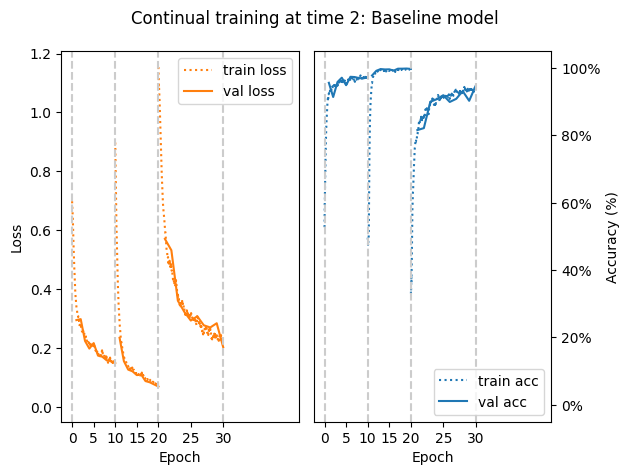

Baseline at t=2 evaluation on test set of all tasks:
['Pullover', 'Dress']: 45.28%
['Trouser', 'Bag']: 45.75%
['Ankle boot', 'Sneaker', 'Sandal']: 94.08%

 +++ AVERAGE TASK TEST ACCURACY: 61.70% +++ 


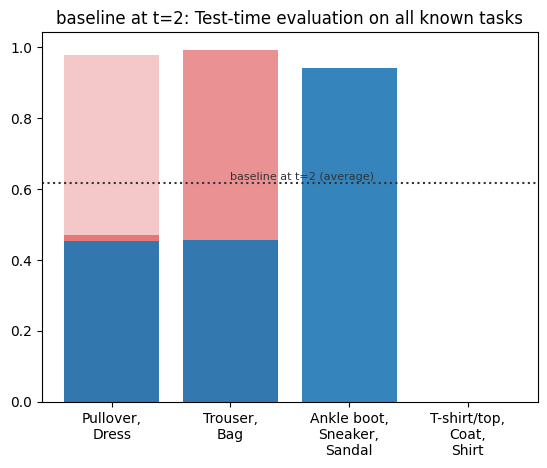

Training on task id: 3  (classification between: ['T-shirt/top', 'Coat', 'Shirt'])


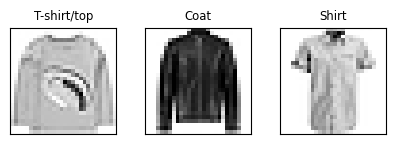

  Adding new task head 3 to multi-task model


E0 batch loss:0.93, batch acc:61.7%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.23it/s]


epoch:  0 | loss: 1.02 | 0.93   acc: 50.4% | 58.6%


E1 batch loss:0.74, batch acc:75.5%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.30it/s]


epoch:  1 | loss: 0.83 | 0.76   acc: 66.0% | 71.5%


E2 batch loss:0.68, batch acc:74.5%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.26it/s]


epoch:  2 | loss: 0.74 | 0.70   acc: 70.6% | 72.4%


E3 batch loss:0.72, batch acc:68.9%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.02it/s]


epoch:  3 | loss: 0.67 | 0.65   acc: 73.4% | 74.5%


E4 batch loss:0.57, batch acc:78.6%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.28it/s]


epoch:  4 | loss: 0.65 | 0.60   acc: 73.8% | 75.0%


E5 batch loss:0.62, batch acc:74.0%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.20it/s]


epoch:  5 | loss: 0.60 | 0.61   acc: 76.3% | 74.6%


E6 batch loss:0.55, batch acc:80.6%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.35it/s]


epoch:  6 | loss: 0.58 | 0.55   acc: 77.3% | 78.8%


E7 batch loss:0.46, batch acc:84.7%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.11it/s]


epoch:  7 | loss: 0.55 | 0.51   acc: 78.1% | 79.2%


E8 batch loss:0.48, batch acc:82.7%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.49it/s]


epoch:  8 | loss: 0.52 | 0.53   acc: 79.5% | 78.8%


E9 batch loss:0.57, batch acc:78.6%: 100%|██████████████████████████| 60/60 [00:02<00:00, 27.07it/s]


epoch:  9 | loss: 0.52 | 0.51   acc: 79.3% | 80.8%


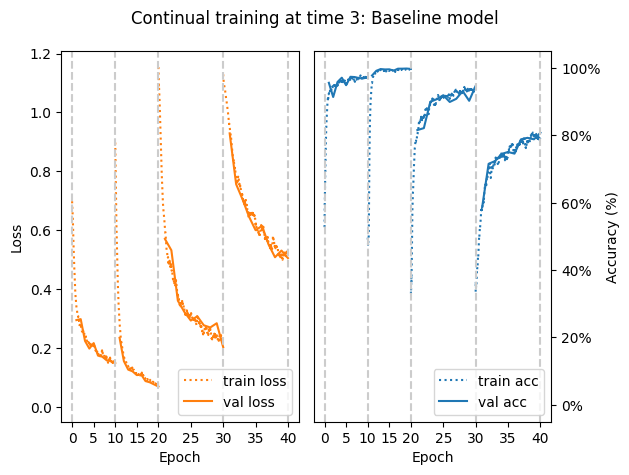

Baseline at t=3 evaluation on test set of all tasks:
['Pullover', 'Dress']: 43.57%
['Trouser', 'Bag']: 46.88%
['Ankle boot', 'Sneaker', 'Sandal']: 32.19%
['T-shirt/top', 'Coat', 'Shirt']: 80.91%

 +++ AVERAGE TASK TEST ACCURACY: 50.89% +++ 


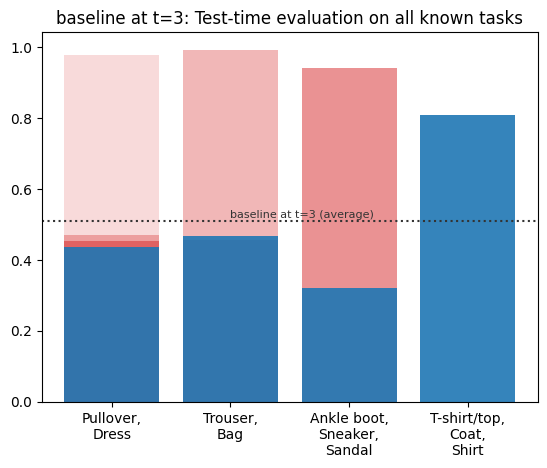


=== Baseline final accuracy averaged over all test tasks: 50.89% ===


In [11]:
INPUT_SIZE = (1, 28, 28)  # for fmnist
baseline_model_training(timestep_tasks, task_test_sets, INPUT_SIZE)


### EWC IMPLEMENTATION


=== Training Task 0 ===
  Using self-paced curriculum learning with EWC
Task 0 | Epoch 0 | loss: 0.145/2.777 | acc: 95.9%/48.5%
  self-paced threshold: 0.120
Task 0 | Epoch 1 | loss: 0.002/3.495 | acc: 100.0%/48.5%
  self-paced threshold: 0.144
Task 0 | Epoch 2 | loss: 0.001/4.089 | acc: 100.0%/48.5%
  self-paced threshold: 0.173
Task 0 | Epoch 3 | loss: 0.000/4.731 | acc: 100.0%/48.5%
  self-paced threshold: 0.207
Task 0 | Epoch 4 | loss: 0.000/5.145 | acc: 100.0%/48.5%
  self-paced threshold: 0.249
Task 0 | Epoch 5 | loss: 0.000/5.451 | acc: 100.0%/48.5%
  self-paced threshold: 0.299
Task 0 | Epoch 6 | loss: 0.000/5.698 | acc: 100.0%/48.5%
  self-paced threshold: 0.358
Task 0 | Epoch 7 | loss: 0.000/5.908 | acc: 100.0%/48.5%
  self-paced threshold: 0.430
Task 0 | Epoch 8 | loss: 0.000/6.093 | acc: 100.0%/48.5%
  self-paced threshold: 0.516
Task 0 | Epoch 9 | loss: 0.000/6.259 | acc: 100.0%/48.5%
  self-paced threshold: 0.516


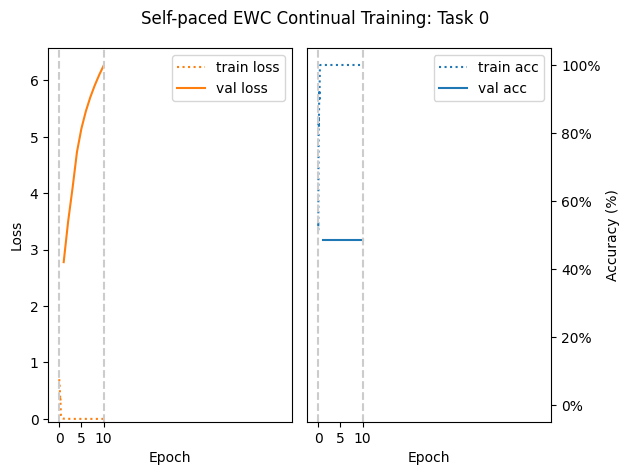

Selfpaced ewc at t=0 evaluation on test set of all tasks:
['Pullover', 'Dress']: 44.92%

 +++ AVERAGE TASK TEST ACCURACY: 44.92% +++ 


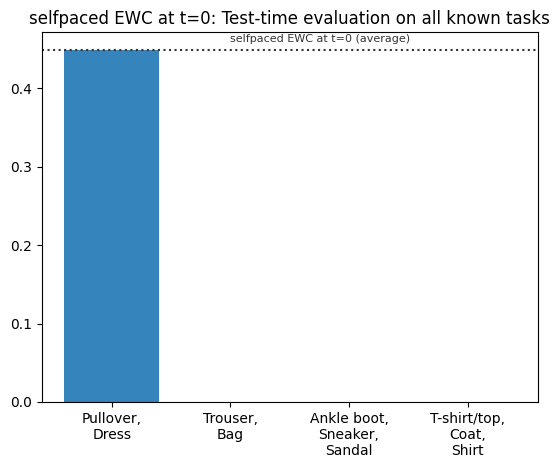


=== Training Task 1 ===
  Using self-paced curriculum learning with EWC
Task 1 | Epoch 0 | loss: 0.104/2.372 | acc: 98.6%/48.2%
  self-paced threshold: 0.619
Task 1 | Epoch 1 | loss: 0.006/3.037 | acc: 100.0%/48.2%
  self-paced threshold: 0.743
Task 1 | Epoch 2 | loss: 0.002/3.741 | acc: 100.0%/48.2%
  self-paced threshold: 0.892
Task 1 | Epoch 3 | loss: 0.001/4.151 | acc: 100.0%/48.2%
  self-paced threshold: 1.070
Task 1 | Epoch 4 | loss: 0.001/4.491 | acc: 100.0%/48.2%
  self-paced threshold: 1.284
Task 1 | Epoch 5 | loss: 0.000/4.821 | acc: 100.0%/48.2%
  self-paced threshold: 1.541
Task 1 | Epoch 6 | loss: 0.000/5.200 | acc: 100.0%/48.2%
  self-paced threshold: 1.849
Task 1 | Epoch 7 | loss: 0.000/5.507 | acc: 100.0%/48.2%
  self-paced threshold: 2.000
Task 1 | Epoch 8 | loss: 0.000/5.764 | acc: 100.0%/48.2%
  self-paced threshold: 2.000
Task 1 | Epoch 9 | loss: 0.000/5.993 | acc: 100.0%/48.2%
  self-paced threshold: 2.000


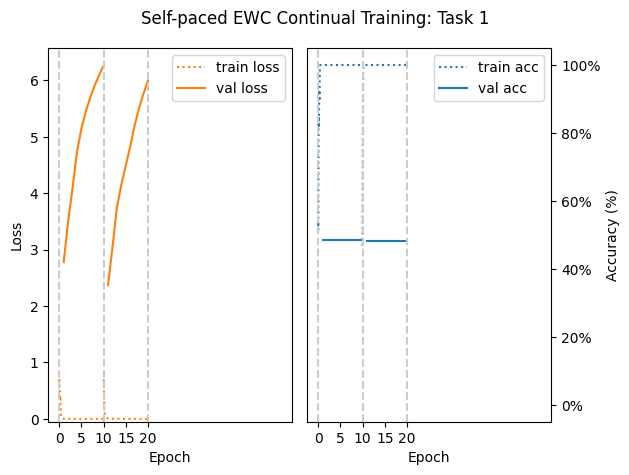

Selfpaced ewc at t=1 evaluation on test set of all tasks:
['Pullover', 'Dress']: 48.40%
['Trouser', 'Bag']: 53.62%

 +++ AVERAGE TASK TEST ACCURACY: 51.01% +++ 


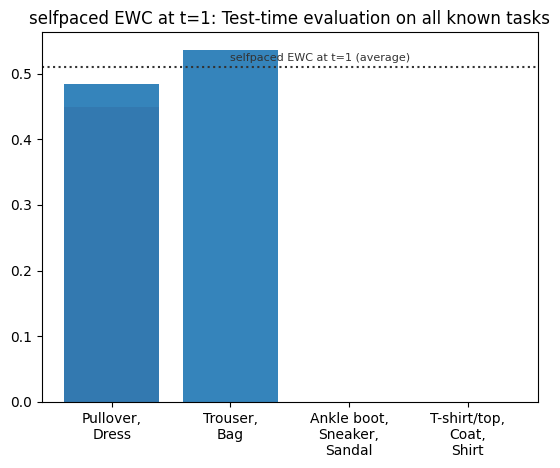


=== Training Task 2 ===
  Using self-paced curriculum learning with EWC
Task 2 | Epoch 0 | loss: 0.624/0.613 | acc: 77.1%/74.4%
  self-paced threshold: 2.000
Task 2 | Epoch 1 | loss: 0.300/0.626 | acc: 89.3%/76.6%
  self-paced threshold: 2.000
Task 2 | Epoch 2 | loss: 0.235/0.353 | acc: 91.9%/86.6%
  self-paced threshold: 2.000
Task 2 | Epoch 3 | loss: 0.204/0.439 | acc: 93.1%/84.5%
  self-paced threshold: 2.000
Task 2 | Epoch 4 | loss: 0.190/0.295 | acc: 93.7%/90.0%
  self-paced threshold: 2.000
Task 2 | Epoch 5 | loss: 0.181/0.276 | acc: 93.9%/90.8%
  self-paced threshold: 2.000
Task 2 | Epoch 6 | loss: 0.170/0.633 | acc: 94.4%/80.4%
  self-paced threshold: 2.000
Task 2 | Epoch 7 | loss: 0.167/0.380 | acc: 94.6%/87.2%
  self-paced threshold: 2.000
Task 2 | Epoch 8 | loss: 0.155/0.267 | acc: 95.3%/91.3%
  self-paced threshold: 2.000
Task 2 | Epoch 9 | loss: 0.151/0.307 | acc: 95.2%/90.7%
  self-paced threshold: 2.000


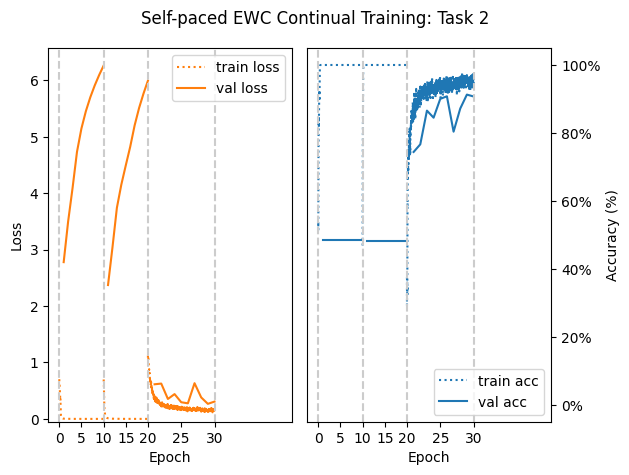

Selfpaced ewc at t=2 evaluation on test set of all tasks:
['Pullover', 'Dress']: 46.16%
['Trouser', 'Bag']: 54.12%
['Ankle boot', 'Sneaker', 'Sandal']: 91.49%

 +++ AVERAGE TASK TEST ACCURACY: 63.92% +++ 


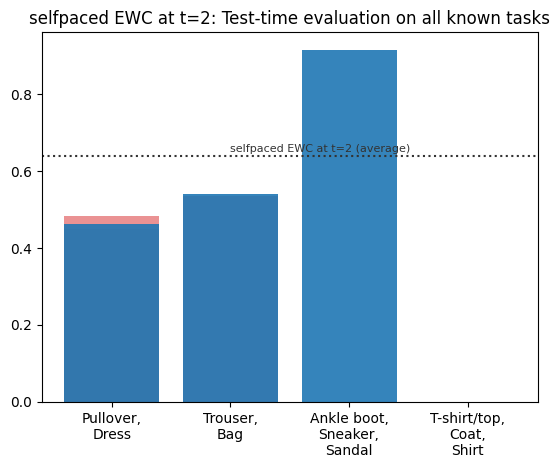


=== Training Task 3 ===
  Using self-paced curriculum learning with EWC
Task 3 | Epoch 0 | loss: 1.080/1.004 | acc: 51.5%/47.8%
  self-paced threshold: 2.000
Task 3 | Epoch 1 | loss: 0.956/0.950 | acc: 58.7%/56.9%
  self-paced threshold: 2.000
Task 3 | Epoch 2 | loss: 0.779/1.000 | acc: 67.9%/60.2%
  self-paced threshold: 2.000
Task 3 | Epoch 3 | loss: 0.713/1.152 | acc: 71.6%/60.5%
  self-paced threshold: 2.000
Task 3 | Epoch 4 | loss: 0.666/0.948 | acc: 74.6%/66.2%
  self-paced threshold: 2.000
Task 3 | Epoch 5 | loss: 0.628/1.105 | acc: 77.0%/65.2%
  self-paced threshold: 2.000
Task 3 | Epoch 6 | loss: 0.590/0.945 | acc: 78.6%/67.7%
  self-paced threshold: 2.000
Task 3 | Epoch 7 | loss: 0.574/1.088 | acc: 78.9%/59.4%
  self-paced threshold: 2.000
Task 3 | Epoch 8 | loss: 0.569/1.298 | acc: 79.0%/64.1%
  self-paced threshold: 2.000
Task 3 | Epoch 9 | loss: 0.552/1.242 | acc: 79.8%/65.7%
  self-paced threshold: 2.000


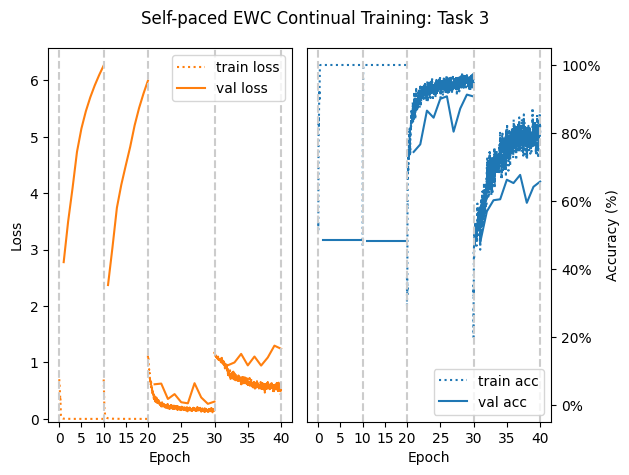

Selfpaced ewc at t=3 evaluation on test set of all tasks:
['Pullover', 'Dress']: 46.41%
['Trouser', 'Bag']: 52.88%
['Ankle boot', 'Sneaker', 'Sandal']: 80.52%
['T-shirt/top', 'Coat', 'Shirt']: 68.50%

 +++ AVERAGE TASK TEST ACCURACY: 62.08% +++ 


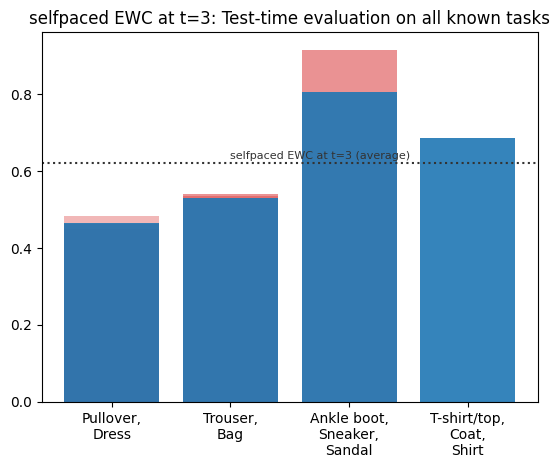

(MultitaskModel(
   (backbone): Conv4Backbone(
     (conv_stack): Sequential(
       (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (1): GroupNorm(8, 32, eps=1e-05, affine=True)
       (2): ReLU()
       (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (4): GroupNorm(16, 64, eps=1e-05, affine=True)
       (5): ReLU()
       (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (7): GroupNorm(16, 64, eps=1e-05, affine=True)
       (8): ReLU()
       (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (10): GroupNorm(32, 128, eps=1e-05, affine=True)
       (11): ReLU()
     )
     (pool): AdaptiveAvgPool2d(output_size=(1, 1))
     (relu): ReLU()
   )
   (task_heads): ModuleDict(
     (0): TaskHead(
       (projection): Linear(in_features=128, out_features=64, bias=True)
       (classifier): Linear(in_features=64, out_features=2, bias=True)
       (dropout): Identity()
       (relu): ReLU

In [12]:
train_ewc_loop(timestep_tasks, task_test_sets, INPUT_SIZE, use_selfpaced=True)

## CIFAR-10

### DATA PREPARATION

Time=0 | Task ID 0 | 8,500 train | 1,000 validation | 500 test


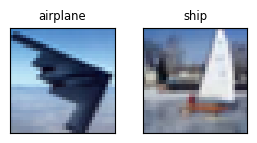

Time=1 | Task ID 1 | 8,500 train | 1,000 validation | 500 test


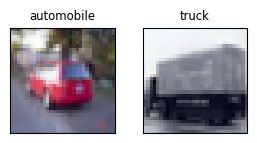

Time=2 | Task ID 2 | 12,750 train | 1,500 validation | 750 test


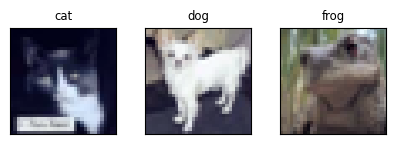

Time=3 | Task ID 3 | 12,750 train | 1,500 validation | 750 test


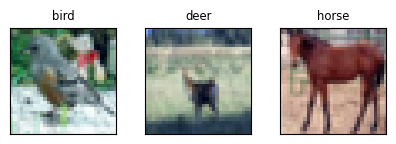

Final test set size (containing all tasks): 2,500

Joint training set size (containing all tasks): 42,500


In [13]:
BATCH_SIZE = 256
task_train, timestep_task_classes, timestep_tasks, task_test_sets = divide_tasks(cifar10, 'cifar-10', BATCH_SIZE=BATCH_SIZE)

### BASELINE MODEL

Training on task id: 0  (classification between: ['airplane', 'ship'])


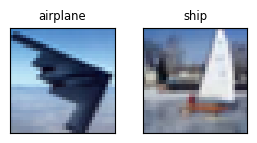

  Adding new task head 0 to multi-task model


E0 batch loss:0.65, batch acc:61.5%: 100%|██████████████████████████| 34/34 [00:01<00:00, 21.50it/s]


epoch:  0 | loss: 0.65 | 0.61   acc: 62.1% | 68.1%


E1 batch loss:0.64, batch acc:67.3%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.68it/s]


epoch:  1 | loss: 0.59 | 0.56   acc: 70.7% | 74.3%


E2 batch loss:0.50, batch acc:80.8%: 100%|██████████████████████████| 34/34 [00:01<00:00, 23.20it/s]


epoch:  2 | loss: 0.54 | 0.55   acc: 75.9% | 74.5%


E3 batch loss:0.53, batch acc:76.9%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.91it/s]


epoch:  3 | loss: 0.52 | 0.51   acc: 77.2% | 77.7%


E4 batch loss:0.47, batch acc:80.8%: 100%|██████████████████████████| 34/34 [00:01<00:00, 23.05it/s]


epoch:  4 | loss: 0.49 | 0.52   acc: 78.7% | 75.7%


E5 batch loss:0.42, batch acc:86.5%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.45it/s]


epoch:  5 | loss: 0.48 | 0.45   acc: 79.1% | 81.5%


E6 batch loss:0.54, batch acc:75.0%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.62it/s]


epoch:  6 | loss: 0.45 | 0.44   acc: 82.0% | 82.6%


E7 batch loss:0.50, batch acc:75.0%: 100%|██████████████████████████| 34/34 [00:01<00:00, 21.55it/s]


epoch:  7 | loss: 0.44 | 0.48   acc: 82.5% | 79.0%


E8 batch loss:0.40, batch acc:86.5%: 100%|██████████████████████████| 34/34 [00:01<00:00, 21.56it/s]


epoch:  8 | loss: 0.44 | 0.45   acc: 82.1% | 82.4%


E9 batch loss:0.45, batch acc:82.7%: 100%|██████████████████████████| 34/34 [00:01<00:00, 21.50it/s]


epoch:  9 | loss: 0.42 | 0.40   acc: 83.4% | 84.5%


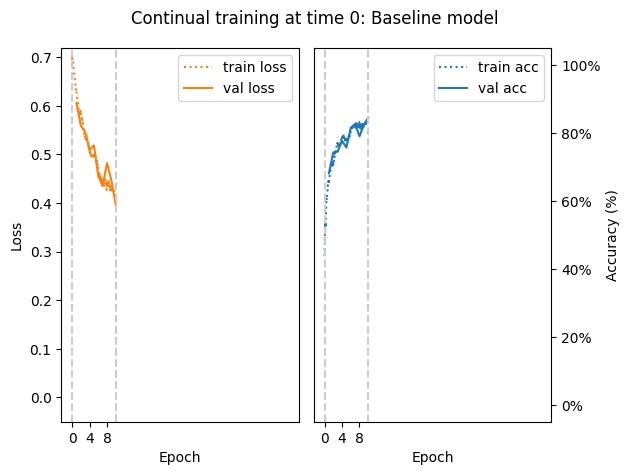

Baseline at t=0 evaluation on test set of all tasks:
['airplane', 'ship']: 82.61%

 +++ AVERAGE TASK TEST ACCURACY: 82.61% +++ 


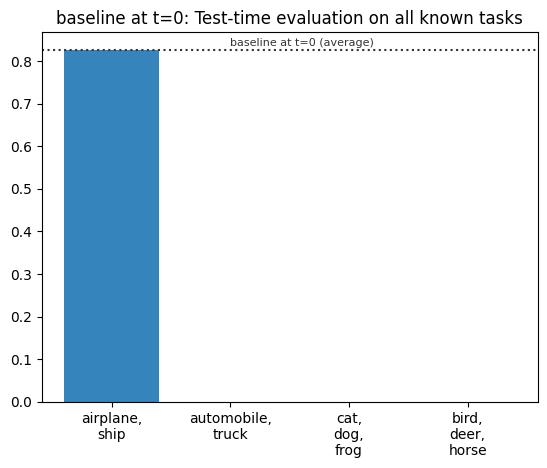

Training on task id: 1  (classification between: ['automobile', 'truck'])


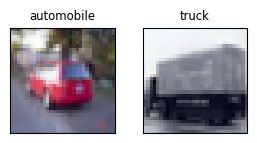

  Adding new task head 1 to multi-task model


E0 batch loss:0.69, batch acc:53.8%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.81it/s]


epoch:  0 | loss: 0.69 | 0.69   acc: 50.9% | 57.8%


E1 batch loss:0.67, batch acc:63.5%: 100%|██████████████████████████| 34/34 [00:01<00:00, 21.58it/s]


epoch:  1 | loss: 0.68 | 0.66   acc: 59.7% | 59.7%


E2 batch loss:0.60, batch acc:61.5%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.17it/s]


epoch:  2 | loss: 0.63 | 0.60   acc: 66.2% | 71.7%


E3 batch loss:0.59, batch acc:67.3%: 100%|██████████████████████████| 34/34 [00:01<00:00, 23.20it/s]


epoch:  3 | loss: 0.59 | 0.55   acc: 69.5% | 73.8%


E4 batch loss:0.59, batch acc:67.3%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.20it/s]


epoch:  4 | loss: 0.59 | 0.57   acc: 68.9% | 72.1%


E5 batch loss:0.48, batch acc:80.8%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.85it/s]


epoch:  5 | loss: 0.54 | 0.51   acc: 74.7% | 77.0%


E6 batch loss:0.48, batch acc:75.0%: 100%|██████████████████████████| 34/34 [00:01<00:00, 23.31it/s]


epoch:  6 | loss: 0.52 | 0.48   acc: 76.0% | 79.3%


E7 batch loss:0.40, batch acc:86.5%: 100%|██████████████████████████| 34/34 [00:01<00:00, 23.47it/s]


epoch:  7 | loss: 0.49 | 0.51   acc: 77.7% | 75.4%


E8 batch loss:0.48, batch acc:78.8%: 100%|██████████████████████████| 34/34 [00:01<00:00, 22.17it/s]


epoch:  8 | loss: 0.49 | 0.46   acc: 77.1% | 81.0%


E9 batch loss:0.52, batch acc:75.0%: 100%|██████████████████████████| 34/34 [00:01<00:00, 21.55it/s]


epoch:  9 | loss: 0.45 | 0.48   acc: 80.8% | 78.4%


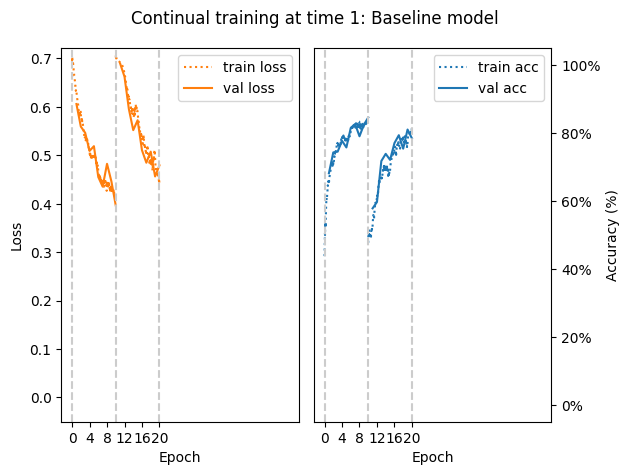

Baseline at t=1 evaluation on test set of all tasks:
['airplane', 'ship']: 53.68%
['automobile', 'truck']: 78.81%

 +++ AVERAGE TASK TEST ACCURACY: 66.24% +++ 


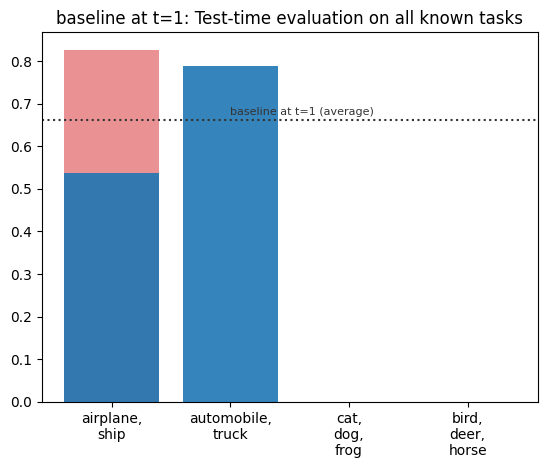

Training on task id: 2  (classification between: ['cat', 'dog', 'frog'])


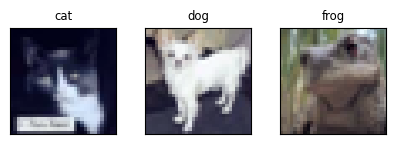

  Adding new task head 2 to multi-task model


E0 batch loss:1.00, batch acc:48.1%: 100%|██████████████████████████| 50/50 [00:02<00:00, 21.20it/s]


epoch:  0 | loss: 1.06 | 0.98   acc: 43.0% | 49.6%


E1 batch loss:0.92, batch acc:59.2%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.96it/s]


epoch:  1 | loss: 0.94 | 0.90   acc: 52.5% | 55.1%


E2 batch loss:0.86, batch acc:56.8%: 100%|██████████████████████████| 50/50 [00:02<00:00, 21.43it/s]


epoch:  2 | loss: 0.87 | 0.85   acc: 57.8% | 60.3%


E3 batch loss:0.81, batch acc:62.1%: 100%|██████████████████████████| 50/50 [00:02<00:00, 20.73it/s]


epoch:  3 | loss: 0.85 | 0.82   acc: 59.5% | 61.1%


E4 batch loss:0.79, batch acc:60.7%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.59it/s]


epoch:  4 | loss: 0.81 | 0.86   acc: 61.9% | 56.4%


E5 batch loss:0.72, batch acc:67.5%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.40it/s]


epoch:  5 | loss: 0.78 | 0.80   acc: 64.0% | 59.7%


E6 batch loss:0.70, batch acc:69.4%: 100%|██████████████████████████| 50/50 [00:02<00:00, 21.90it/s]


epoch:  6 | loss: 0.76 | 0.88   acc: 64.8% | 55.6%


E7 batch loss:0.65, batch acc:78.2%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.54it/s]


epoch:  7 | loss: 0.77 | 0.75   acc: 64.2% | 65.9%


E8 batch loss:0.72, batch acc:70.4%: 100%|██████████████████████████| 50/50 [00:02<00:00, 23.11it/s]


epoch:  8 | loss: 0.74 | 0.75   acc: 66.6% | 66.3%


E9 batch loss:0.67, batch acc:70.4%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.85it/s]


epoch:  9 | loss: 0.73 | 0.73   acc: 66.8% | 66.6%


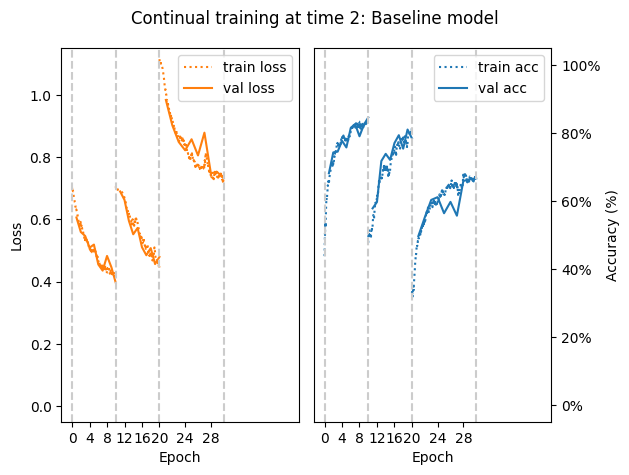

Baseline at t=2 evaluation on test set of all tasks:
['airplane', 'ship']: 56.37%
['automobile', 'truck']: 54.24%
['cat', 'dog', 'frog']: 67.79%

 +++ AVERAGE TASK TEST ACCURACY: 59.46% +++ 


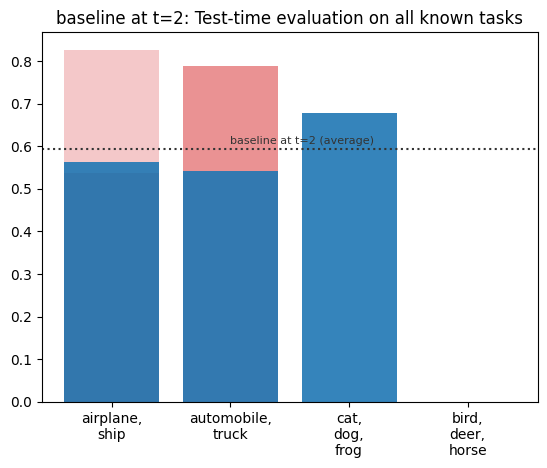

Training on task id: 3  (classification between: ['bird', 'deer', 'horse'])


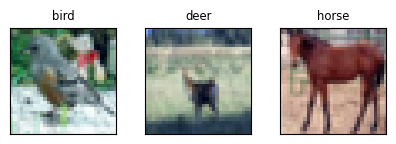

  Adding new task head 3 to multi-task model


E0 batch loss:0.96, batch acc:57.3%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.48it/s]


epoch:  0 | loss: 1.03 | 0.97   acc: 50.0% | 56.0%


E1 batch loss:0.90, batch acc:53.4%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.36it/s]


epoch:  1 | loss: 0.92 | 0.90   acc: 58.7% | 62.2%


E2 batch loss:0.91, batch acc:59.2%: 100%|██████████████████████████| 50/50 [00:02<00:00, 21.98it/s]


epoch:  2 | loss: 0.88 | 0.91   acc: 62.0% | 60.2%


E3 batch loss:0.79, batch acc:70.9%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.68it/s]


epoch:  3 | loss: 0.83 | 0.86   acc: 65.7% | 64.8%


E4 batch loss:0.80, batch acc:67.5%: 100%|██████████████████████████| 50/50 [00:02<00:00, 21.93it/s]


epoch:  4 | loss: 0.81 | 0.79   acc: 67.0% | 68.8%


E5 batch loss:0.70, batch acc:73.8%: 100%|██████████████████████████| 50/50 [00:02<00:00, 23.40it/s]


epoch:  5 | loss: 0.76 | 0.77   acc: 69.9% | 70.3%


E6 batch loss:0.70, batch acc:74.8%: 100%|██████████████████████████| 50/50 [00:02<00:00, 23.40it/s]


epoch:  6 | loss: 0.76 | 0.81   acc: 69.5% | 64.2%


E7 batch loss:0.68, batch acc:75.2%: 100%|██████████████████████████| 50/50 [00:02<00:00, 23.00it/s]


epoch:  7 | loss: 0.73 | 0.72   acc: 70.7% | 71.1%


E8 batch loss:0.74, batch acc:68.4%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.51it/s]


epoch:  8 | loss: 0.71 | 0.74   acc: 71.6% | 69.2%


E9 batch loss:0.71, batch acc:70.9%: 100%|██████████████████████████| 50/50 [00:02<00:00, 22.99it/s]


epoch:  9 | loss: 0.68 | 0.71   acc: 73.4% | 71.9%


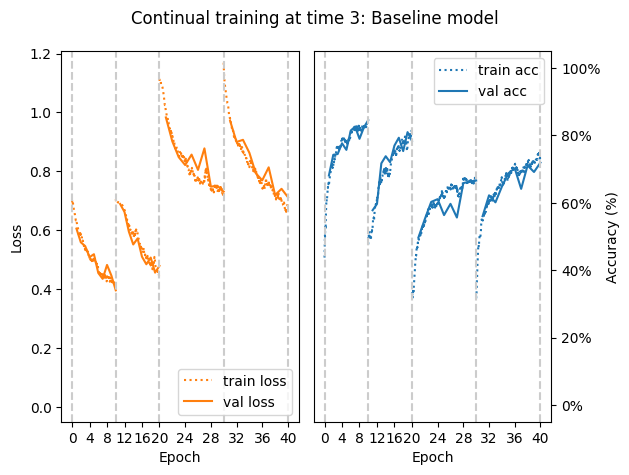

Baseline at t=3 evaluation on test set of all tasks:
['airplane', 'ship']: 52.84%
['automobile', 'truck']: 55.59%
['cat', 'dog', 'frog']: 45.84%
['bird', 'deer', 'horse']: 72.02%

 +++ AVERAGE TASK TEST ACCURACY: 56.57% +++ 


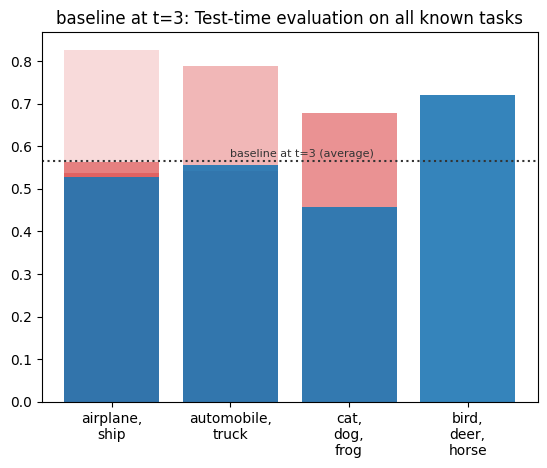


=== Baseline final accuracy averaged over all test tasks: 56.57% ===


In [14]:
INPUT_SIZE = (3,32,32)  # for cifar
baseline_model_training(timestep_tasks, task_test_sets, INPUT_SIZE)

### EWC IMPLEMENTATION


=== Training Task 0 ===
  Using self-paced curriculum learning with EWC
Task 0 | Epoch 0 | loss: 0.616/0.553 | acc: 67.0%/73.6%
  self-paced threshold: 0.120
Task 0 | Epoch 1 | loss: 0.153/2.737 | acc: 93.1%/50.7%
  self-paced threshold: 0.144
Task 0 | Epoch 2 | loss: 0.002/3.512 | acc: 100.0%/50.7%
  self-paced threshold: 0.173
Task 0 | Epoch 3 | loss: 0.001/3.930 | acc: 100.0%/50.7%
  self-paced threshold: 0.207
Task 0 | Epoch 4 | loss: 0.000/4.230 | acc: 100.0%/50.7%
  self-paced threshold: 0.249
Task 0 | Epoch 5 | loss: 0.000/4.467 | acc: 100.0%/50.7%
  self-paced threshold: 0.299
Task 0 | Epoch 6 | loss: 0.000/4.665 | acc: 100.0%/50.7%
  self-paced threshold: 0.358
Task 0 | Epoch 7 | loss: 0.000/4.837 | acc: 100.0%/50.7%
  self-paced threshold: 0.430
Task 0 | Epoch 8 | loss: 0.000/4.990 | acc: 100.0%/50.7%
  self-paced threshold: 0.516
Task 0 | Epoch 9 | loss: 0.000/5.130 | acc: 100.0%/50.7%
  self-paced threshold: 0.516


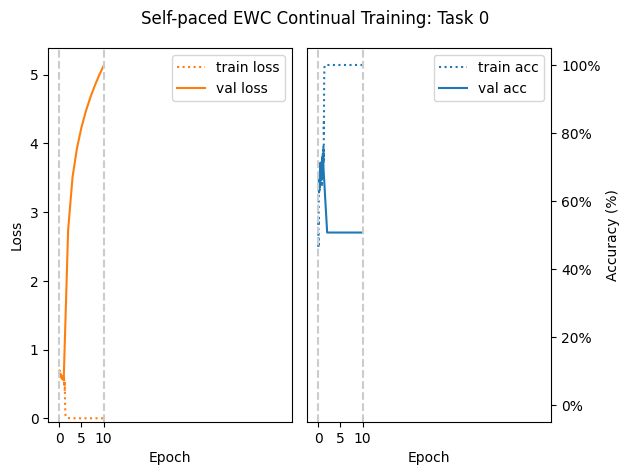

Selfpaced ewc at t=0 evaluation on test set of all tasks:
['airplane', 'ship']: 50.51%

 +++ AVERAGE TASK TEST ACCURACY: 50.51% +++ 


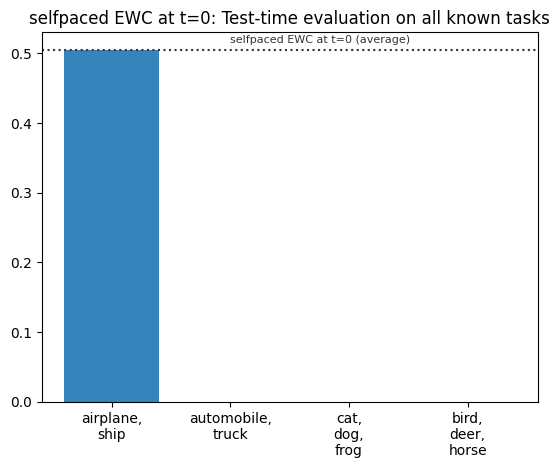


=== Training Task 1 ===
  Using self-paced curriculum learning with EWC
Task 1 | Epoch 0 | loss: 0.073/2.466 | acc: 100.0%/50.4%
  self-paced threshold: 0.619
Task 1 | Epoch 1 | loss: 0.004/3.465 | acc: 100.0%/50.4%
  self-paced threshold: 0.743
Task 1 | Epoch 2 | loss: 0.001/4.110 | acc: 100.0%/50.4%
  self-paced threshold: 0.892
Task 1 | Epoch 3 | loss: 0.001/4.744 | acc: 100.0%/50.4%
  self-paced threshold: 1.070
Task 1 | Epoch 4 | loss: 0.000/5.103 | acc: 100.0%/50.4%
  self-paced threshold: 1.284
Task 1 | Epoch 5 | loss: 0.000/5.398 | acc: 100.0%/50.4%
  self-paced threshold: 1.541
Task 1 | Epoch 6 | loss: 0.000/5.615 | acc: 100.0%/50.4%
  self-paced threshold: 1.849
Task 1 | Epoch 7 | loss: 0.000/5.964 | acc: 100.0%/50.4%
  self-paced threshold: 2.000
Task 1 | Epoch 8 | loss: 0.000/6.214 | acc: 100.0%/50.4%
  self-paced threshold: 2.000
Task 1 | Epoch 9 | loss: 0.000/6.412 | acc: 100.0%/50.4%
  self-paced threshold: 2.000


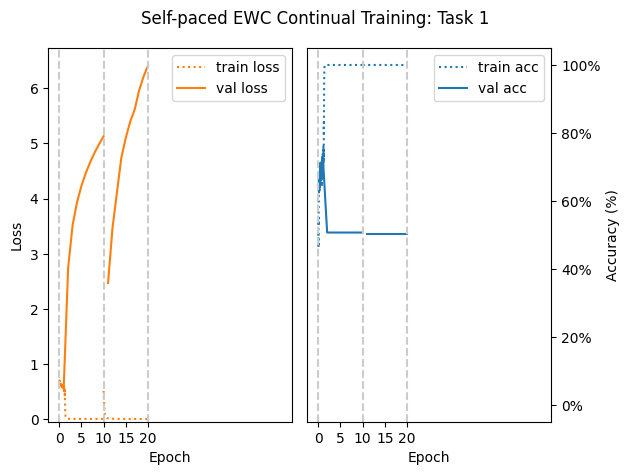

Selfpaced ewc at t=1 evaluation on test set of all tasks:
['airplane', 'ship']: 50.67%
['automobile', 'truck']: 54.21%

 +++ AVERAGE TASK TEST ACCURACY: 52.44% +++ 


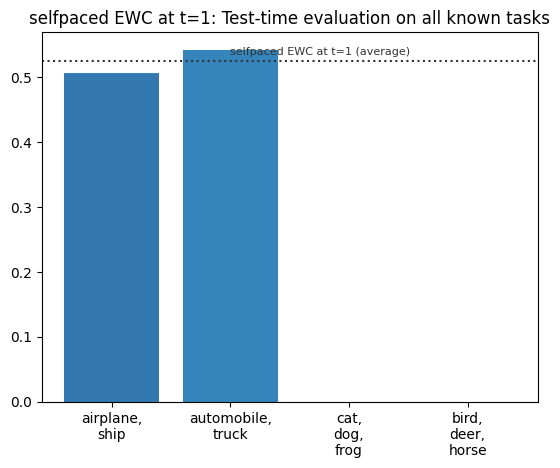


=== Training Task 2 ===
  Using self-paced curriculum learning with EWC
Task 2 | Epoch 0 | loss: 0.980/0.938 | acc: 49.3%/52.2%
  self-paced threshold: 2.000
Task 2 | Epoch 1 | loss: 0.743/0.971 | acc: 59.8%/56.4%
  self-paced threshold: 2.000
Task 2 | Epoch 2 | loss: 0.678/0.882 | acc: 63.7%/60.3%
  self-paced threshold: 2.000
Task 2 | Epoch 3 | loss: 0.645/0.912 | acc: 66.3%/59.7%
  self-paced threshold: 2.000
Task 2 | Epoch 4 | loss: 0.623/0.909 | acc: 67.8%/58.1%
  self-paced threshold: 2.000
Task 2 | Epoch 5 | loss: 0.603/0.977 | acc: 68.3%/58.5%
  self-paced threshold: 2.000
Task 2 | Epoch 6 | loss: 0.594/0.935 | acc: 69.5%/63.6%
  self-paced threshold: 2.000
Task 2 | Epoch 7 | loss: 0.583/0.979 | acc: 70.0%/61.6%
  self-paced threshold: 2.000
Task 2 | Epoch 8 | loss: 0.578/1.149 | acc: 70.2%/57.3%
  self-paced threshold: 2.000
Task 2 | Epoch 9 | loss: 0.564/0.894 | acc: 71.1%/64.9%
  self-paced threshold: 2.000


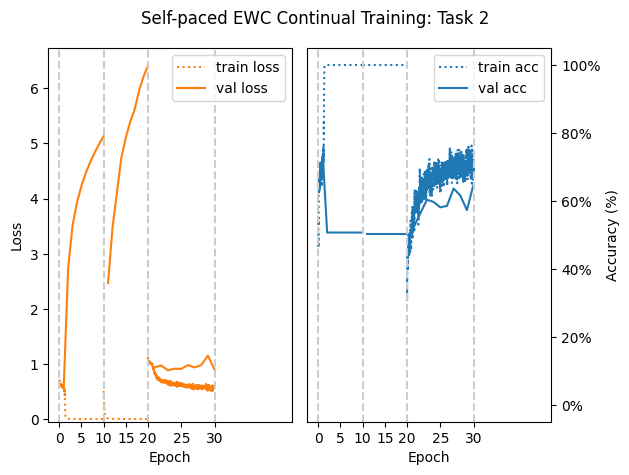

Selfpaced ewc at t=2 evaluation on test set of all tasks:
['airplane', 'ship']: 50.57%
['automobile', 'truck']: 54.19%
['cat', 'dog', 'frog']: 66.01%

 +++ AVERAGE TASK TEST ACCURACY: 56.92% +++ 


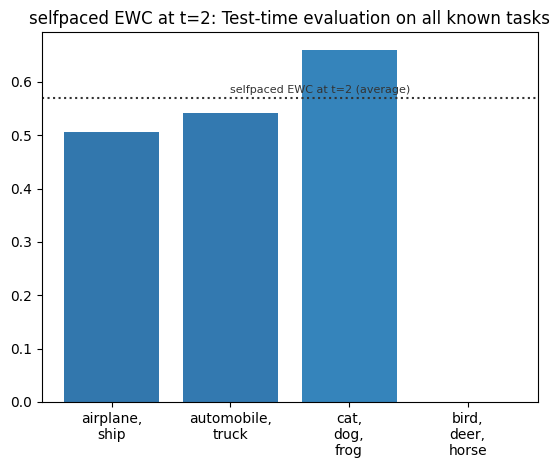


=== Training Task 3 ===
  Using self-paced curriculum learning with EWC
Task 3 | Epoch 0 | loss: 1.061/0.981 | acc: 51.6%/51.5%
  self-paced threshold: 2.000
Task 3 | Epoch 1 | loss: 0.957/0.908 | acc: 57.1%/58.4%
  self-paced threshold: 2.000
Task 3 | Epoch 2 | loss: 0.849/0.966 | acc: 62.3%/57.8%
  self-paced threshold: 2.000
Task 3 | Epoch 3 | loss: 0.781/0.954 | acc: 65.6%/56.1%
  self-paced threshold: 2.000
Task 3 | Epoch 4 | loss: 0.750/1.100 | acc: 67.7%/56.6%
  self-paced threshold: 2.000
Task 3 | Epoch 5 | loss: 0.713/1.013 | acc: 68.8%/59.8%
  self-paced threshold: 2.000
Task 3 | Epoch 6 | loss: 0.701/1.076 | acc: 69.8%/58.1%
  self-paced threshold: 2.000
Task 3 | Epoch 7 | loss: 0.670/1.038 | acc: 71.4%/61.3%
  self-paced threshold: 2.000
Task 3 | Epoch 8 | loss: 0.665/1.027 | acc: 71.6%/58.5%
  self-paced threshold: 2.000
Task 3 | Epoch 9 | loss: 0.658/1.312 | acc: 71.8%/53.0%
  self-paced threshold: 2.000


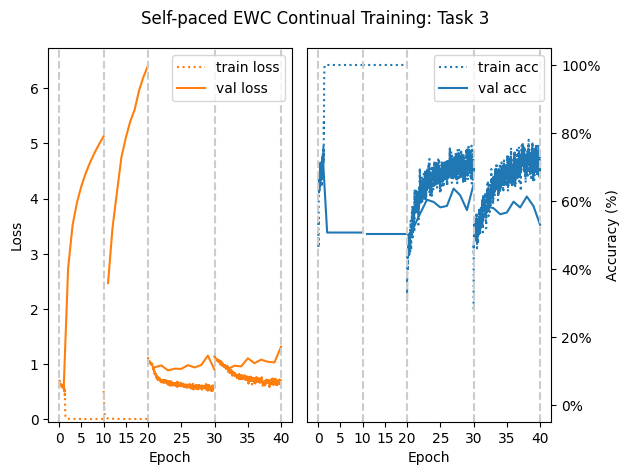

Selfpaced ewc at t=3 evaluation on test set of all tasks:
['airplane', 'ship']: 50.64%
['automobile', 'truck']: 54.28%
['cat', 'dog', 'frog']: 53.36%
['bird', 'deer', 'horse']: 54.65%

 +++ AVERAGE TASK TEST ACCURACY: 53.23% +++ 


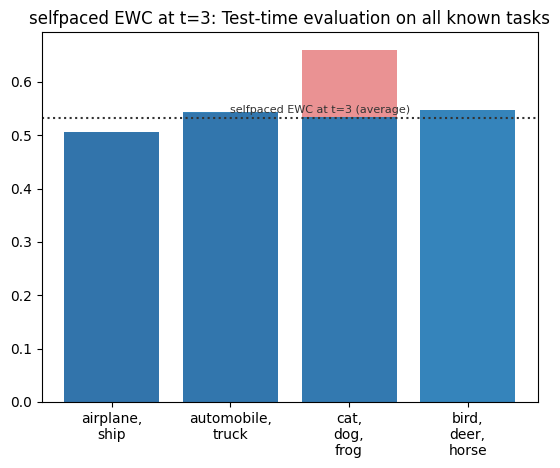

(MultitaskModel(
   (backbone): Conv4Backbone(
     (conv_stack): Sequential(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (1): GroupNorm(8, 32, eps=1e-05, affine=True)
       (2): ReLU()
       (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (4): GroupNorm(16, 64, eps=1e-05, affine=True)
       (5): ReLU()
       (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (7): GroupNorm(16, 64, eps=1e-05, affine=True)
       (8): ReLU()
       (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (10): GroupNorm(32, 128, eps=1e-05, affine=True)
       (11): ReLU()
     )
     (pool): AdaptiveAvgPool2d(output_size=(1, 1))
     (relu): ReLU()
   )
   (task_heads): ModuleDict(
     (0): TaskHead(
       (projection): Linear(in_features=128, out_features=64, bias=True)
       (classifier): Linear(in_features=64, out_features=2, bias=True)
       (dropout): Identity()
       (relu): ReLU

In [15]:
train_ewc_loop(timestep_tasks, task_test_sets, INPUT_SIZE, use_selfpaced=True)

## CIFAR-100

Time=0 | Task ID 0 | 2,125 train | 250 validation | 125 test


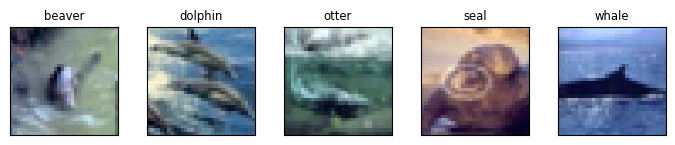

Time=1 | Task ID 1 | 2,125 train | 250 validation | 125 test


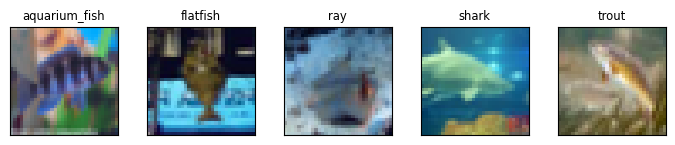

Time=2 | Task ID 2 | 2,125 train | 250 validation | 125 test


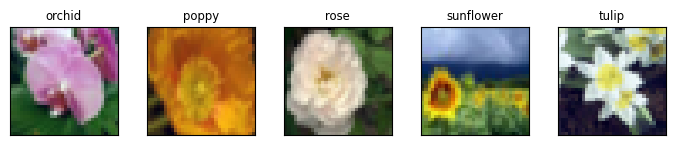

Time=3 | Task ID 3 | 2,125 train | 250 validation | 125 test


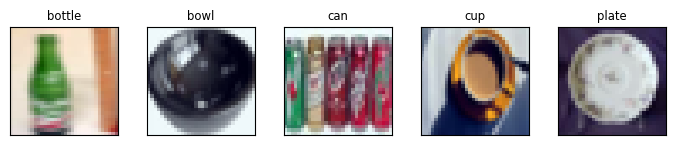

Time=4 | Task ID 4 | 2,125 train | 250 validation | 125 test


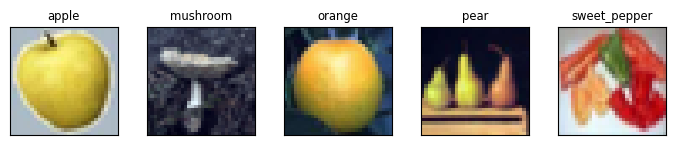

Time=5 | Task ID 5 | 2,125 train | 250 validation | 125 test


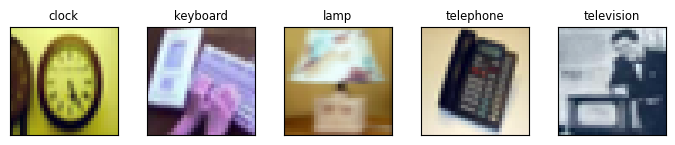

Time=6 | Task ID 6 | 2,125 train | 250 validation | 125 test


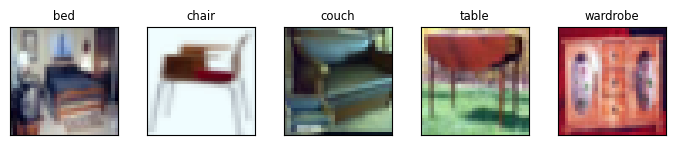

Time=7 | Task ID 7 | 2,125 train | 250 validation | 125 test


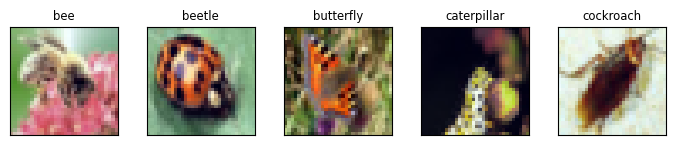

Time=8 | Task ID 8 | 2,125 train | 250 validation | 125 test


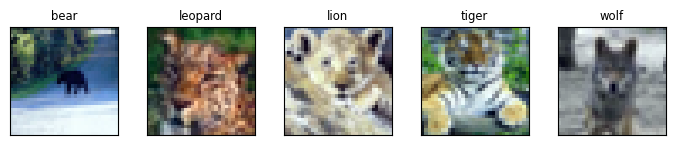

Time=9 | Task ID 9 | 2,125 train | 250 validation | 125 test


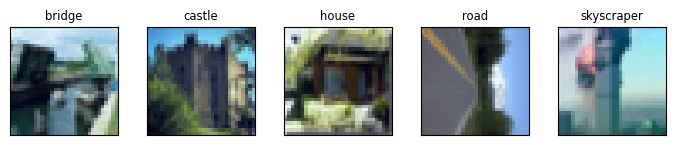

Time=10 | Task ID 10 | 2,125 train | 250 validation | 125 test


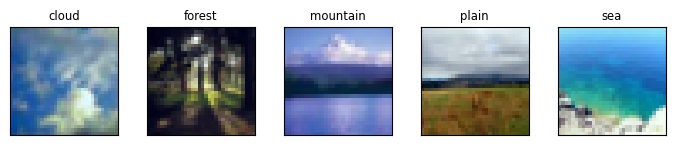

Time=11 | Task ID 11 | 2,125 train | 250 validation | 125 test


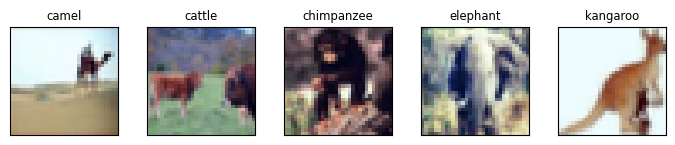

Time=12 | Task ID 12 | 2,125 train | 250 validation | 125 test


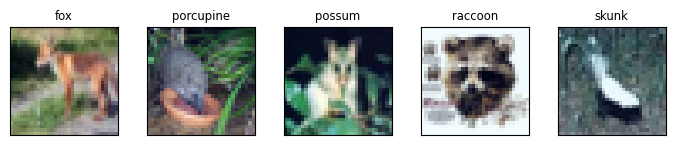

Time=13 | Task ID 13 | 2,125 train | 250 validation | 125 test


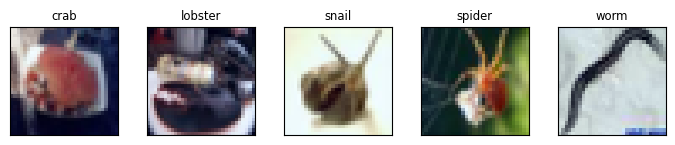

Time=14 | Task ID 14 | 2,125 train | 250 validation | 125 test


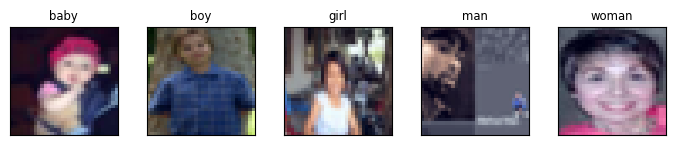

Time=15 | Task ID 15 | 2,125 train | 250 validation | 125 test


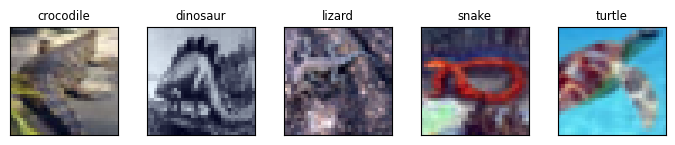

Time=16 | Task ID 16 | 2,125 train | 250 validation | 125 test


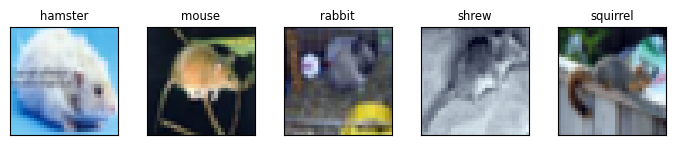

Time=17 | Task ID 17 | 2,125 train | 250 validation | 125 test


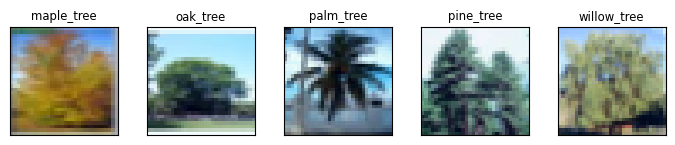

Time=18 | Task ID 18 | 2,125 train | 250 validation | 125 test


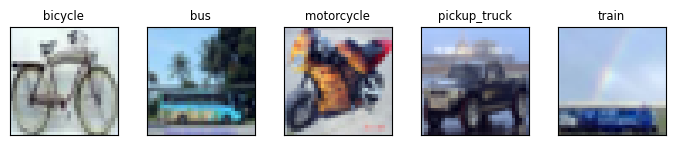

Time=19 | Task ID 19 | 2,125 train | 250 validation | 125 test


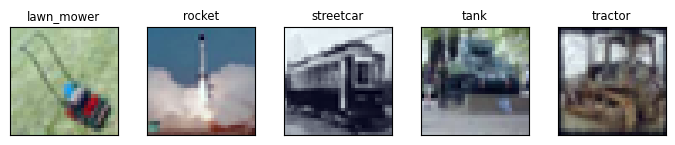

Final test set size (containing all tasks): 2,500

Joint training set size (containing all tasks): 42,500


In [16]:
BATCH_SIZE = 256
task_train, timestep_task_classes, timestep_tasks, task_test_sets = divide_tasks(cifar100, 'cifar-100', BATCH_SIZE=BATCH_SIZE)

Training on task id: 0  (classification between: ['beaver', 'dolphin', 'otter', 'seal', 'whale'])


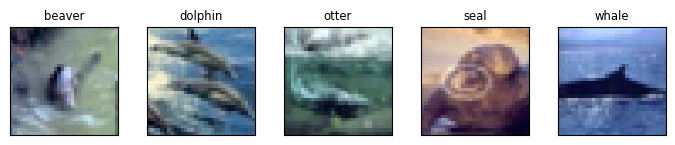

  Adding new task head 0 to multi-task model


E0 batch loss:1.46, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.41it/s]


epoch:  0 | loss: 1.51 | 1.47   acc: 34.1% | 36.4%


E1 batch loss:1.41, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.87it/s]


epoch:  1 | loss: 1.43 | 1.45   acc: 39.3% | 41.6%


E2 batch loss:1.42, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.52it/s]


epoch:  2 | loss: 1.41 | 1.43   acc: 37.8% | 33.2%


E3 batch loss:1.36, batch acc:39.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.08it/s]


epoch:  3 | loss: 1.40 | 1.42   acc: 40.3% | 38.0%


E4 batch loss:1.40, batch acc:33.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.10it/s]


epoch:  4 | loss: 1.39 | 1.41   acc: 38.2% | 38.0%


E5 batch loss:1.40, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.30it/s]


epoch:  5 | loss: 1.38 | 1.42   acc: 42.2% | 41.6%


E6 batch loss:1.42, batch acc:28.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.59it/s]


epoch:  6 | loss: 1.38 | 1.41   acc: 42.0% | 38.0%


E7 batch loss:1.35, batch acc:50.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.99it/s]


epoch:  7 | loss: 1.36 | 1.40   acc: 43.7% | 40.4%


E8 batch loss:1.36, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.12it/s]


epoch:  8 | loss: 1.36 | 1.38   acc: 41.8% | 40.4%


E9 batch loss:1.36, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.08it/s]


epoch:  9 | loss: 1.35 | 1.39   acc: 43.9% | 46.4%


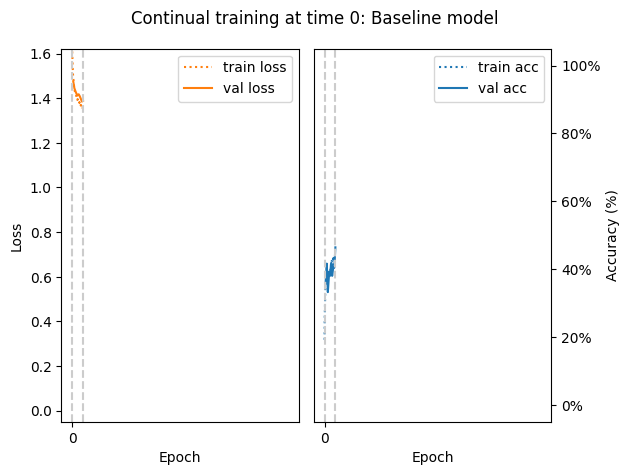

Baseline at t=0 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 36.00%

 +++ AVERAGE TASK TEST ACCURACY: 36.00% +++ 


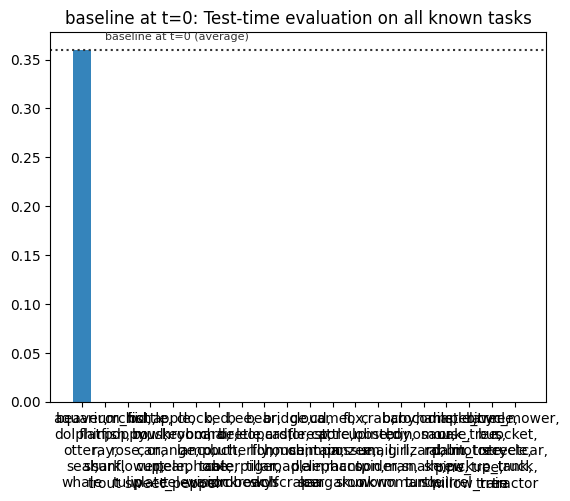

Training on task id: 1  (classification between: ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'])


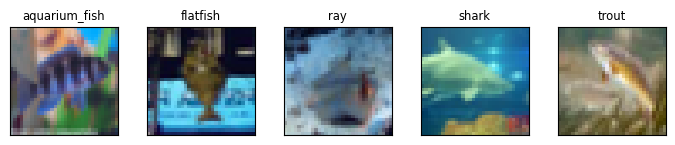

  Adding new task head 1 to multi-task model


E0 batch loss:1.50, batch acc:50.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.05it/s]


epoch:  0 | loss: 1.60 | 1.57   acc: 24.6% | 29.2%


E1 batch loss:1.46, batch acc:51.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.02it/s]


epoch:  1 | loss: 1.52 | 1.52   acc: 38.3% | 40.0%


E2 batch loss:1.47, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.18it/s]


epoch:  2 | loss: 1.48 | 1.47   acc: 43.2% | 48.0%


E3 batch loss:1.47, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.06it/s]


epoch:  3 | loss: 1.44 | 1.42   acc: 47.2% | 48.4%


E4 batch loss:1.40, batch acc:42.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.02it/s]


epoch:  4 | loss: 1.41 | 1.39   acc: 46.3% | 50.4%


E5 batch loss:1.36, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.15it/s]


epoch:  5 | loss: 1.38 | 1.35   acc: 46.4% | 51.6%


E6 batch loss:1.29, batch acc:48.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.17it/s]


epoch:  6 | loss: 1.35 | 1.33   acc: 48.4% | 52.8%


E7 batch loss:1.27, batch acc:54.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.80it/s]


epoch:  7 | loss: 1.33 | 1.33   acc: 50.3% | 51.2%


E8 batch loss:1.30, batch acc:54.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.42it/s]


epoch:  8 | loss: 1.33 | 1.31   acc: 48.9% | 49.6%


E9 batch loss:1.34, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.80it/s]


epoch:  9 | loss: 1.31 | 1.27   acc: 50.5% | 52.4%


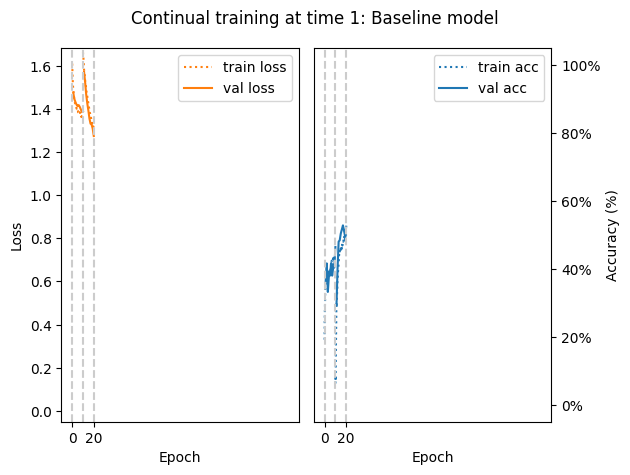

Baseline at t=1 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 12.80%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 53.60%

 +++ AVERAGE TASK TEST ACCURACY: 33.20% +++ 


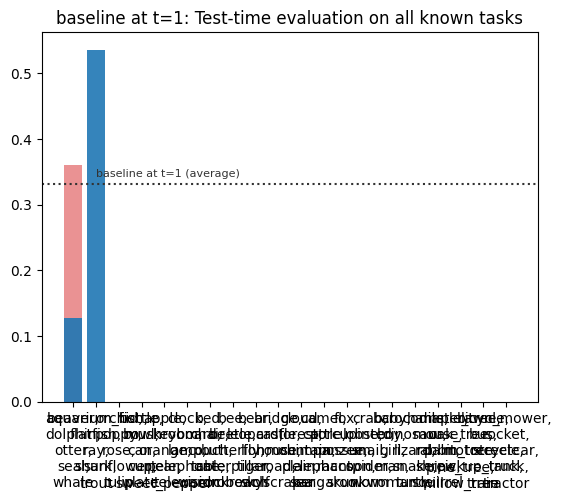

Training on task id: 2  (classification between: ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'])


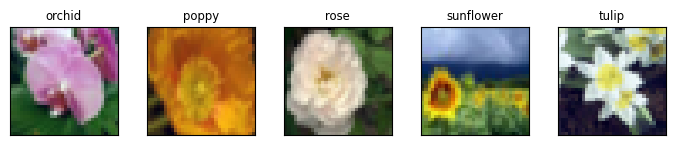

  Adding new task head 2 to multi-task model


E0 batch loss:1.64, batch acc:16.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.14it/s]


epoch:  0 | loss: 1.64 | 1.61   acc: 16.0% | 19.2%


E1 batch loss:1.60, batch acc:26.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.49it/s]


epoch:  1 | loss: 1.60 | 1.59   acc: 24.4% | 26.0%


E2 batch loss:1.54, batch acc:46.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.09it/s]


epoch:  2 | loss: 1.57 | 1.57   acc: 37.5% | 36.0%


E3 batch loss:1.53, batch acc:49.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.30it/s]


epoch:  3 | loss: 1.54 | 1.54   acc: 39.6% | 41.2%


E4 batch loss:1.48, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.44it/s]


epoch:  4 | loss: 1.51 | 1.51   acc: 42.3% | 38.8%


E5 batch loss:1.49, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.80it/s]


epoch:  5 | loss: 1.48 | 1.47   acc: 43.2% | 41.2%


E6 batch loss:1.44, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.90it/s]


epoch:  6 | loss: 1.45 | 1.44   acc: 44.8% | 42.8%


E7 batch loss:1.37, batch acc:50.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.66it/s]


epoch:  7 | loss: 1.41 | 1.42   acc: 46.6% | 45.2%


E8 batch loss:1.35, batch acc:53.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.10it/s]


epoch:  8 | loss: 1.38 | 1.42   acc: 47.0% | 39.2%


E9 batch loss:1.39, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.23it/s]


epoch:  9 | loss: 1.38 | 1.38   acc: 46.0% | 45.6%


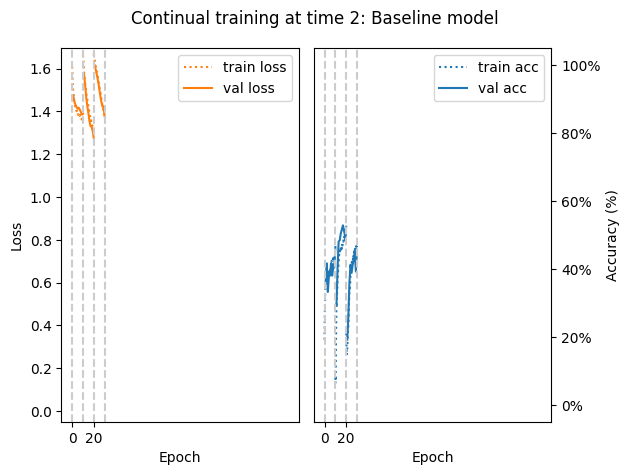

Baseline at t=2 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 14.40%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 22.40%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 55.20%

 +++ AVERAGE TASK TEST ACCURACY: 30.67% +++ 


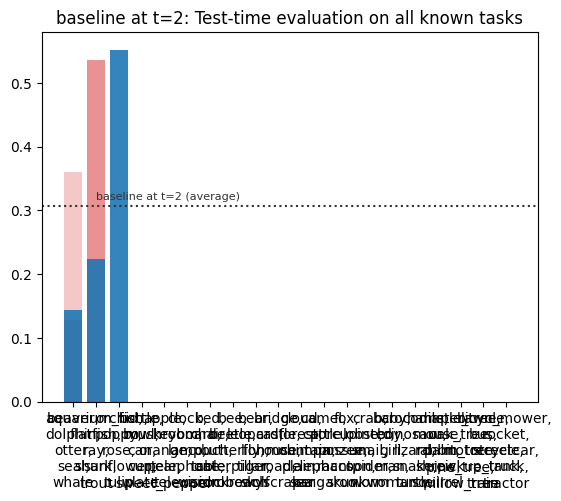

Training on task id: 3  (classification between: ['bottle', 'bowl', 'can', 'cup', 'plate'])


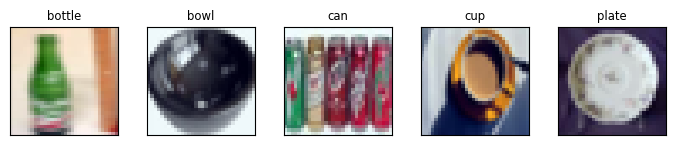

  Adding new task head 3 to multi-task model


E0 batch loss:1.56, batch acc:28.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 22.78it/s]


epoch:  0 | loss: 1.62 | 1.61   acc: 20.4% | 19.6%


E1 batch loss:1.60, batch acc:19.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.27it/s]


epoch:  1 | loss: 1.60 | 1.59   acc: 19.8% | 20.0%


E2 batch loss:1.57, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.93it/s]


epoch:  2 | loss: 1.58 | 1.58   acc: 24.1% | 25.6%


E3 batch loss:1.58, batch acc:23.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.31it/s]


epoch:  3 | loss: 1.57 | 1.56   acc: 28.1% | 29.2%


E4 batch loss:1.54, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.21it/s]


epoch:  4 | loss: 1.56 | 1.58   acc: 31.3% | 28.4%


E5 batch loss:1.53, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.25it/s]


epoch:  5 | loss: 1.55 | 1.55   acc: 31.6% | 24.0%


E6 batch loss:1.60, batch acc:33.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.68it/s]


epoch:  6 | loss: 1.55 | 1.56   acc: 32.6% | 29.6%


E7 batch loss:1.52, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.66it/s]


epoch:  7 | loss: 1.54 | 1.55   acc: 34.5% | 28.0%


E8 batch loss:1.51, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.91it/s]


epoch:  8 | loss: 1.52 | 1.54   acc: 35.4% | 28.4%


E9 batch loss:1.49, batch acc:33.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.17it/s]


epoch:  9 | loss: 1.52 | 1.54   acc: 35.3% | 29.6%


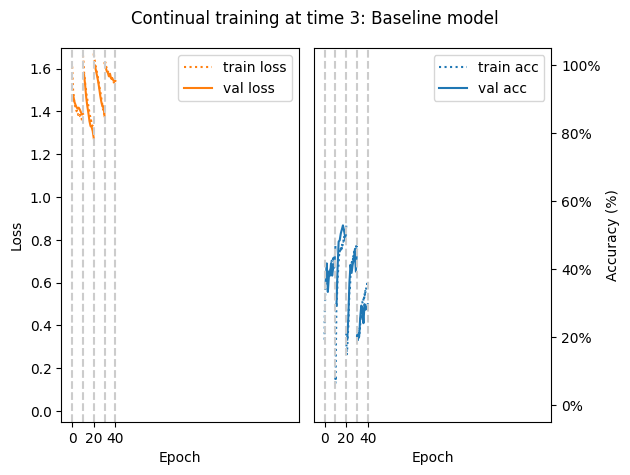

Baseline at t=3 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 23.20%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 14.40%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 34.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 28.80%

 +++ AVERAGE TASK TEST ACCURACY: 25.20% +++ 


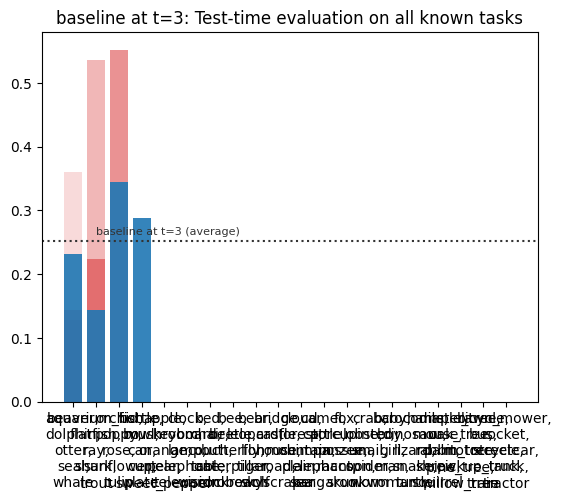

Training on task id: 4  (classification between: ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'])


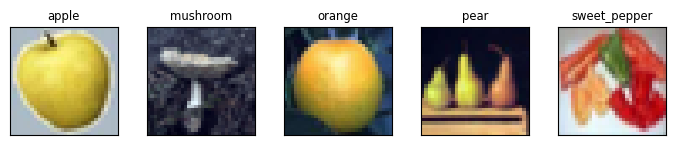

  Adding new task head 4 to multi-task model


E0 batch loss:1.46, batch acc:50.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 22.39it/s]


epoch:  0 | loss: 1.54 | 1.51   acc: 35.5% | 38.0%


E1 batch loss:1.39, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.09it/s]


epoch:  1 | loss: 1.44 | 1.45   acc: 47.1% | 45.6%


E2 batch loss:1.36, batch acc:48.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.52it/s]


epoch:  2 | loss: 1.39 | 1.41   acc: 50.4% | 48.0%


E3 batch loss:1.37, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.73it/s]


epoch:  3 | loss: 1.36 | 1.38   acc: 51.9% | 47.6%


E4 batch loss:1.30, batch acc:64.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.07it/s]


epoch:  4 | loss: 1.33 | 1.35   acc: 55.2% | 50.8%


E5 batch loss:1.25, batch acc:61.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.40it/s]


epoch:  5 | loss: 1.29 | 1.32   acc: 57.7% | 52.8%


E6 batch loss:1.22, batch acc:63.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.53it/s]


epoch:  6 | loss: 1.26 | 1.28   acc: 59.1% | 54.4%


E7 batch loss:1.18, batch acc:57.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.62it/s]


epoch:  7 | loss: 1.22 | 1.27   acc: 60.7% | 54.8%


E8 batch loss:1.20, batch acc:59.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.49it/s]


epoch:  8 | loss: 1.20 | 1.25   acc: 61.3% | 54.4%


E9 batch loss:1.21, batch acc:58.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.99it/s]


epoch:  9 | loss: 1.19 | 1.22   acc: 62.6% | 56.8%


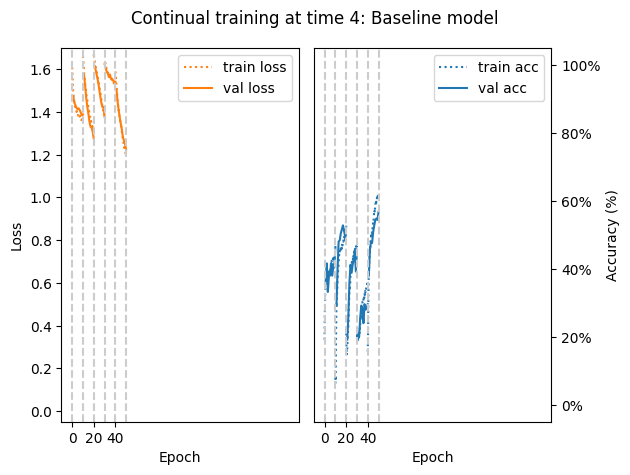

Baseline at t=4 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 20.00%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 19.20%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 28.80%
['bottle', 'bowl', 'can', 'cup', 'plate']: 25.60%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 60.00%

 +++ AVERAGE TASK TEST ACCURACY: 30.72% +++ 


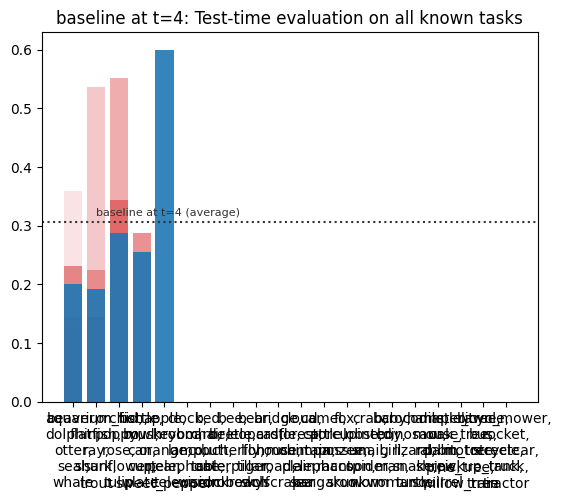

Training on task id: 5  (classification between: ['clock', 'keyboard', 'lamp', 'telephone', 'television'])


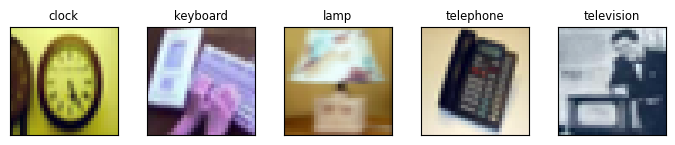

  Adding new task head 5 to multi-task model


E0 batch loss:1.59, batch acc:33.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.47it/s]


epoch:  0 | loss: 1.61 | 1.59   acc: 23.1% | 30.4%


E1 batch loss:1.58, batch acc:28.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.26it/s]


epoch:  1 | loss: 1.59 | 1.57   acc: 28.3% | 30.8%


E2 batch loss:1.56, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.63it/s]


epoch:  2 | loss: 1.57 | 1.57   acc: 30.9% | 32.4%


E3 batch loss:1.52, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.65it/s]


epoch:  3 | loss: 1.56 | 1.56   acc: 33.2% | 32.4%


E4 batch loss:1.55, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.64it/s]


epoch:  4 | loss: 1.55 | 1.54   acc: 33.3% | 35.6%


E5 batch loss:1.56, batch acc:24.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.91it/s]


epoch:  5 | loss: 1.54 | 1.56   acc: 34.1% | 31.6%


E6 batch loss:1.53, batch acc:29.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.57it/s]


epoch:  6 | loss: 1.54 | 1.54   acc: 31.3% | 33.6%


E7 batch loss:1.52, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.63it/s]


epoch:  7 | loss: 1.52 | 1.51   acc: 33.7% | 36.0%


E8 batch loss:1.49, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.92it/s]


epoch:  8 | loss: 1.52 | 1.50   acc: 35.2% | 38.8%


E9 batch loss:1.55, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.07it/s]


epoch:  9 | loss: 1.51 | 1.49   acc: 35.1% | 37.6%


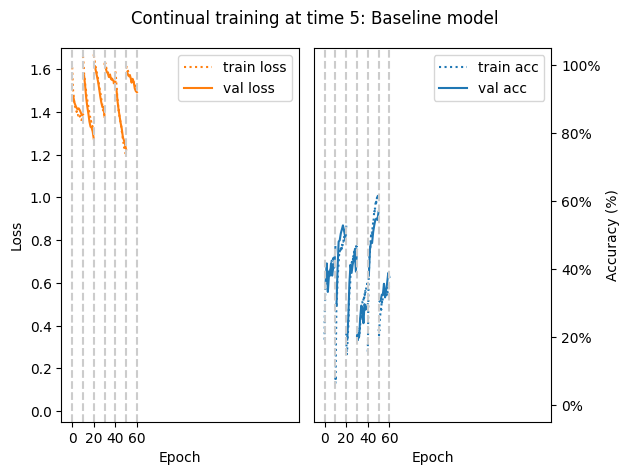

Baseline at t=5 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 25.60%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 18.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 27.20%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 45.60%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 39.20%

 +++ AVERAGE TASK TEST ACCURACY: 29.60% +++ 


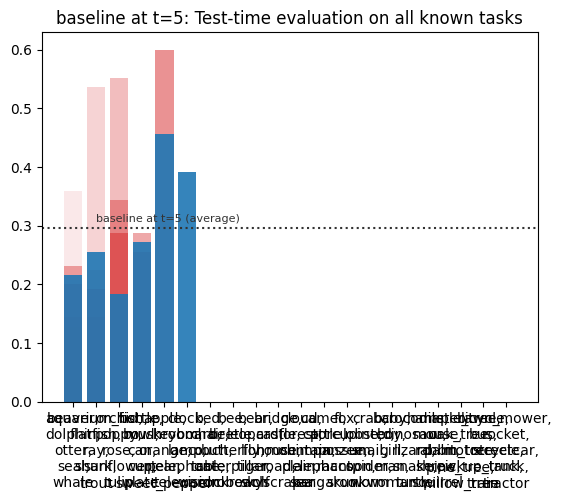

Training on task id: 6  (classification between: ['bed', 'chair', 'couch', 'table', 'wardrobe'])


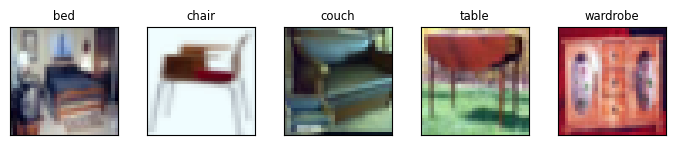

  Adding new task head 6 to multi-task model


E0 batch loss:1.64, batch acc:19.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.62it/s]


epoch:  0 | loss: 1.63 | 1.58   acc: 23.5% | 33.6%


E1 batch loss:1.56, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.91it/s]


epoch:  1 | loss: 1.57 | 1.55   acc: 33.6% | 37.2%


E2 batch loss:1.53, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.99it/s]


epoch:  2 | loss: 1.54 | 1.53   acc: 35.6% | 35.6%


E3 batch loss:1.53, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.52it/s]


epoch:  3 | loss: 1.53 | 1.51   acc: 35.8% | 40.0%


E4 batch loss:1.47, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.59it/s]


epoch:  4 | loss: 1.51 | 1.49   acc: 38.6% | 38.8%


E5 batch loss:1.51, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.63it/s]


epoch:  5 | loss: 1.50 | 1.49   acc: 38.2% | 39.6%


E6 batch loss:1.51, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.94it/s]


epoch:  6 | loss: 1.49 | 1.48   acc: 38.6% | 38.4%


E7 batch loss:1.48, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.63it/s]


epoch:  7 | loss: 1.47 | 1.47   acc: 38.4% | 39.2%


E8 batch loss:1.51, batch acc:39.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.63it/s]


epoch:  8 | loss: 1.47 | 1.45   acc: 38.6% | 40.4%


E9 batch loss:1.49, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.54it/s]


epoch:  9 | loss: 1.45 | 1.44   acc: 39.5% | 40.8%


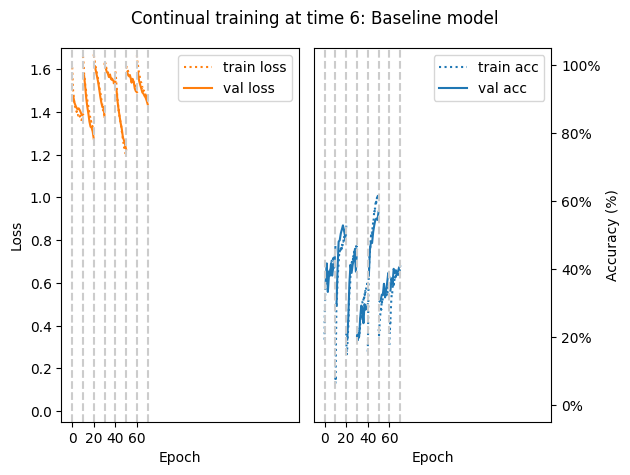

Baseline at t=6 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 12.00%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 12.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 24.80%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 16.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 24.00%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 37.60%

 +++ AVERAGE TASK TEST ACCURACY: 21.71% +++ 


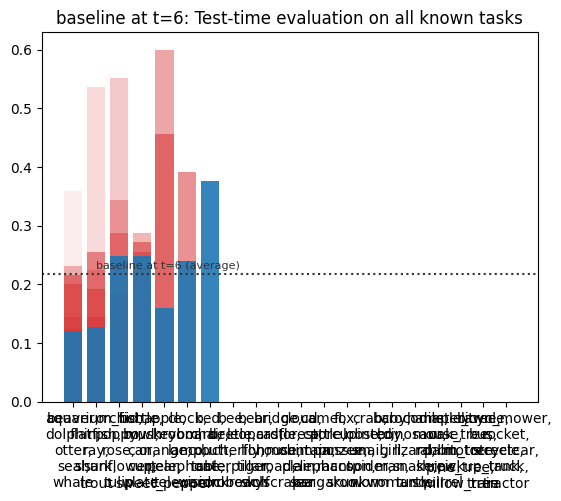

Training on task id: 7  (classification between: ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'])


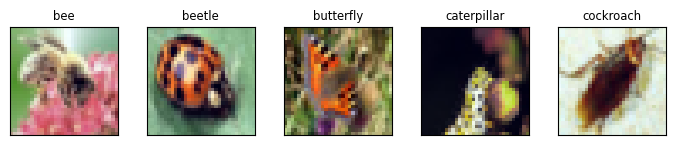

  Adding new task head 7 to multi-task model


E0 batch loss:1.61, batch acc:26.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.59it/s]


epoch:  0 | loss: 1.61 | 1.58   acc: 24.7% | 30.4%


E1 batch loss:1.54, batch acc:33.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.07it/s]


epoch:  1 | loss: 1.56 | 1.53   acc: 33.2% | 34.0%


E2 batch loss:1.50, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.93it/s]


epoch:  2 | loss: 1.52 | 1.50   acc: 33.6% | 36.0%


E3 batch loss:1.41, batch acc:49.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.63it/s]


epoch:  3 | loss: 1.49 | 1.47   acc: 36.9% | 43.2%


E4 batch loss:1.47, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.32it/s]


epoch:  4 | loss: 1.46 | 1.44   acc: 41.5% | 46.4%


E5 batch loss:1.42, batch acc:48.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.50it/s]


epoch:  5 | loss: 1.44 | 1.43   acc: 44.0% | 46.0%


E6 batch loss:1.36, batch acc:50.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.73it/s]


epoch:  6 | loss: 1.42 | 1.40   acc: 45.0% | 48.0%


E7 batch loss:1.37, batch acc:55.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.60it/s]


epoch:  7 | loss: 1.40 | 1.40   acc: 47.3% | 48.0%


E8 batch loss:1.37, batch acc:46.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.04it/s]


epoch:  8 | loss: 1.38 | 1.38   acc: 48.2% | 49.2%


E9 batch loss:1.37, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.66it/s]


epoch:  9 | loss: 1.37 | 1.37   acc: 47.8% | 46.4%


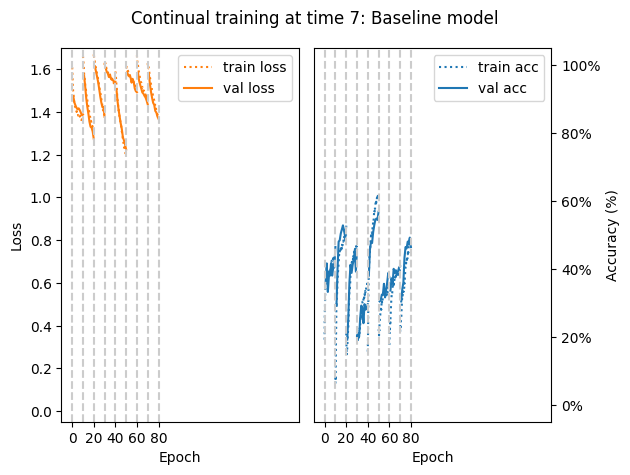

Baseline at t=7 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 15.20%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 17.60%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 27.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.00%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 28.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 21.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 21.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 49.60%

 +++ AVERAGE TASK TEST ACCURACY: 25.60% +++ 


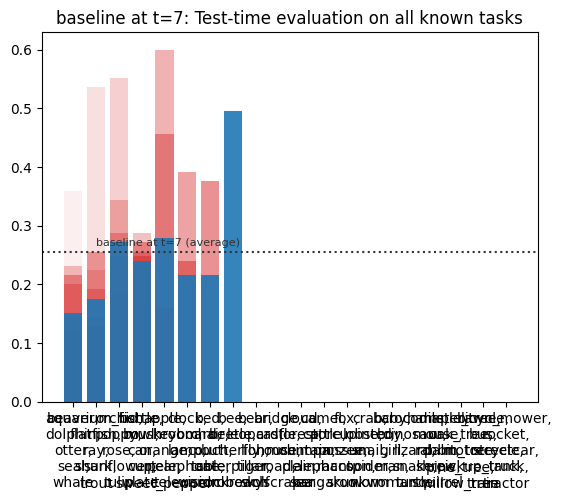

Training on task id: 8  (classification between: ['bear', 'leopard', 'lion', 'tiger', 'wolf'])


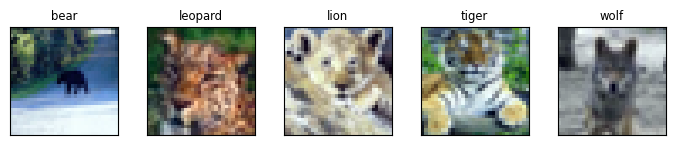

  Adding new task head 8 to multi-task model


E0 batch loss:1.55, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.60it/s]


epoch:  0 | loss: 1.60 | 1.56   acc: 23.2% | 32.8%


E1 batch loss:1.50, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.68it/s]


epoch:  1 | loss: 1.54 | 1.49   acc: 35.8% | 38.0%


E2 batch loss:1.48, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.74it/s]


epoch:  2 | loss: 1.49 | 1.45   acc: 33.3% | 37.6%


E3 batch loss:1.39, batch acc:49.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.64it/s]


epoch:  3 | loss: 1.46 | 1.43   acc: 34.9% | 38.8%


E4 batch loss:1.43, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.72it/s]


epoch:  4 | loss: 1.44 | 1.41   acc: 35.8% | 43.2%


E5 batch loss:1.48, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.41it/s]


epoch:  5 | loss: 1.43 | 1.40   acc: 42.2% | 45.6%


E6 batch loss:1.36, batch acc:46.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.78it/s]


epoch:  6 | loss: 1.40 | 1.38   acc: 44.1% | 45.6%


E7 batch loss:1.46, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.03it/s]


epoch:  7 | loss: 1.40 | 1.41   acc: 44.8% | 43.2%


E8 batch loss:1.39, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.72it/s]


epoch:  8 | loss: 1.40 | 1.36   acc: 42.7% | 46.4%


E9 batch loss:1.37, batch acc:48.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.76it/s]


epoch:  9 | loss: 1.37 | 1.34   acc: 47.6% | 46.4%


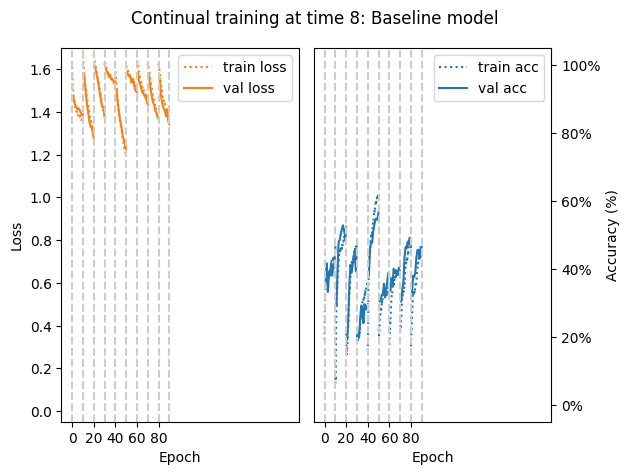

Baseline at t=8 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 12.80%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 14.40%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 26.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 19.20%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 24.80%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 21.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 19.20%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 38.40%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 54.40%

 +++ AVERAGE TASK TEST ACCURACY: 25.69% +++ 


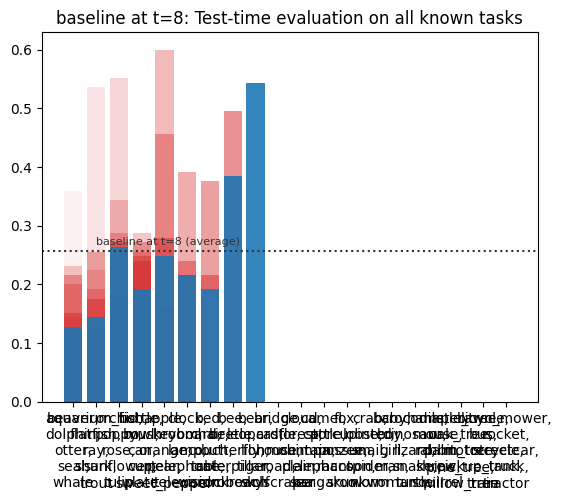

Training on task id: 9  (classification between: ['bridge', 'castle', 'house', 'road', 'skyscraper'])


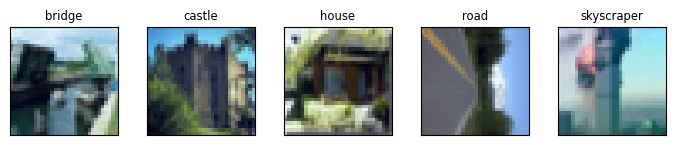

  Adding new task head 9 to multi-task model


E0 batch loss:1.57, batch acc:19.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.55it/s]


epoch:  0 | loss: 1.60 | 1.56   acc: 20.4% | 29.2%


E1 batch loss:1.55, batch acc:24.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.35it/s]


epoch:  1 | loss: 1.55 | 1.53   acc: 30.7% | 30.0%


E2 batch loss:1.53, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.60it/s]


epoch:  2 | loss: 1.51 | 1.51   acc: 35.2% | 30.4%


E3 batch loss:1.43, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.79it/s]


epoch:  3 | loss: 1.48 | 1.49   acc: 35.8% | 35.2%


E4 batch loss:1.38, batch acc:42.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.71it/s]


epoch:  4 | loss: 1.46 | 1.46   acc: 39.1% | 38.0%


E5 batch loss:1.42, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.87it/s]


epoch:  5 | loss: 1.44 | 1.44   acc: 40.9% | 39.6%


E6 batch loss:1.43, batch acc:42.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.46it/s]


epoch:  6 | loss: 1.43 | 1.44   acc: 43.9% | 40.8%


E7 batch loss:1.39, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.34it/s]


epoch:  7 | loss: 1.40 | 1.41   acc: 45.8% | 42.0%


E8 batch loss:1.36, batch acc:55.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.85it/s]


epoch:  8 | loss: 1.38 | 1.38   acc: 49.4% | 49.6%


E9 batch loss:1.36, batch acc:46.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.91it/s]


epoch:  9 | loss: 1.37 | 1.37   acc: 49.2% | 48.0%


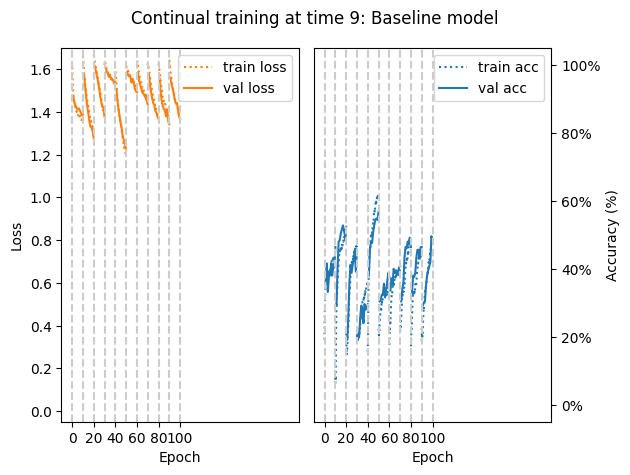

Baseline at t=9 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 12.80%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 18.40%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 26.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 19.20%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 30.40%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 25.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 20.00%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 29.60%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 26.40%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 60.80%

 +++ AVERAGE TASK TEST ACCURACY: 26.96% +++ 


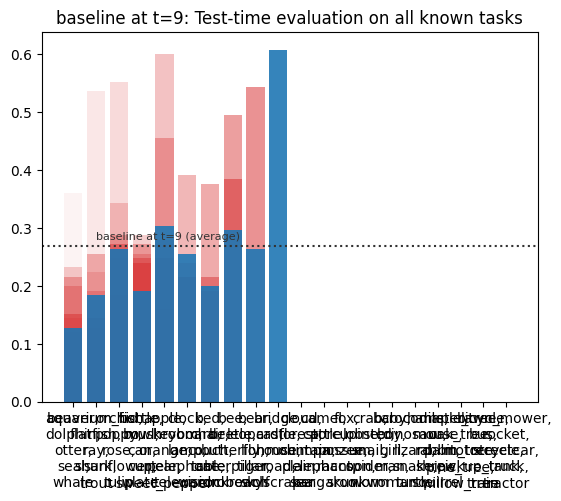

Training on task id: 10  (classification between: ['cloud', 'forest', 'mountain', 'plain', 'sea'])


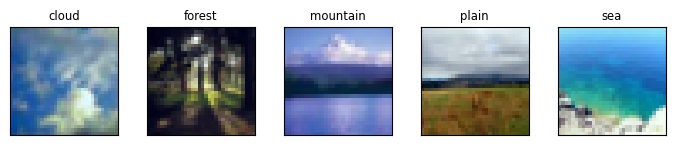

  Adding new task head 10 to multi-task model


E0 batch loss:1.56, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.81it/s]


epoch:  0 | loss: 1.60 | 1.55   acc: 24.1% | 44.0%


E1 batch loss:1.52, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.66it/s]


epoch:  1 | loss: 1.53 | 1.49   acc: 44.3% | 46.0%


E2 batch loss:1.44, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.64it/s]


epoch:  2 | loss: 1.47 | 1.42   acc: 45.3% | 47.2%


E3 batch loss:1.30, batch acc:53.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.94it/s]


epoch:  3 | loss: 1.39 | 1.35   acc: 47.1% | 52.0%


E4 batch loss:1.37, batch acc:48.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.68it/s]


epoch:  4 | loss: 1.34 | 1.30   acc: 52.3% | 58.0%


E5 batch loss:1.31, batch acc:59.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.36it/s]


epoch:  5 | loss: 1.30 | 1.27   acc: 55.9% | 60.0%


E6 batch loss:1.28, batch acc:58.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 22.84it/s]


epoch:  6 | loss: 1.27 | 1.25   acc: 56.2% | 62.8%


E7 batch loss:1.29, batch acc:49.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.19it/s]


epoch:  7 | loss: 1.25 | 1.23   acc: 56.8% | 61.2%


E8 batch loss:1.17, batch acc:58.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.60it/s]


epoch:  8 | loss: 1.23 | 1.21   acc: 57.9% | 60.0%


E9 batch loss:1.13, batch acc:71.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.59it/s]


epoch:  9 | loss: 1.21 | 1.19   acc: 59.4% | 62.0%


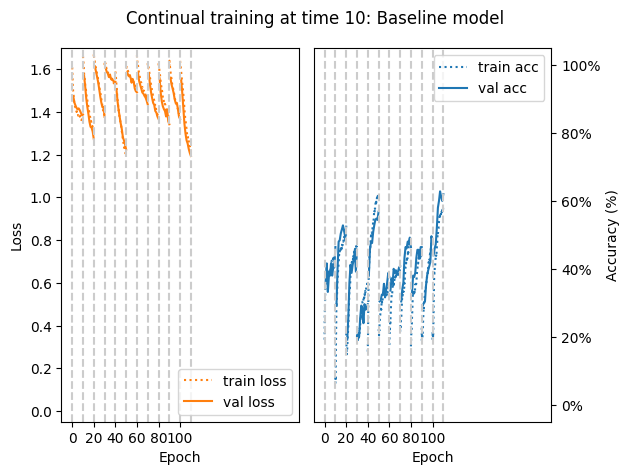

Baseline at t=10 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 11.20%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 18.40%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 24.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 28.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 28.80%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 20.80%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 12.80%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 24.80%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 25.60%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 20.80%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 56.80%

 +++ AVERAGE TASK TEST ACCURACY: 24.80% +++ 


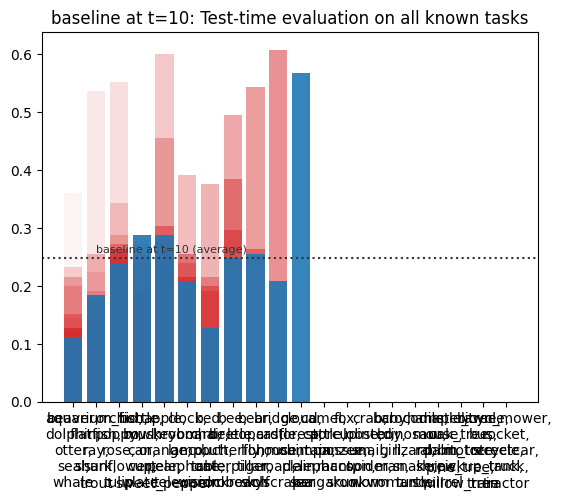

Training on task id: 11  (classification between: ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'])


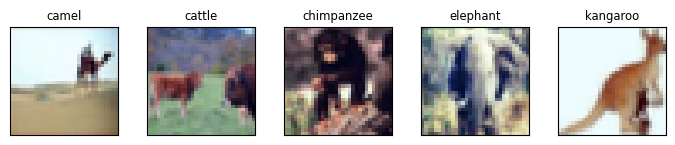

  Adding new task head 11 to multi-task model


E0 batch loss:1.59, batch acc:28.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.14it/s]


epoch:  0 | loss: 1.62 | 1.60   acc: 21.2% | 23.2%


E1 batch loss:1.57, batch acc:24.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.27it/s]


epoch:  1 | loss: 1.58 | 1.54   acc: 29.2% | 32.4%


E2 batch loss:1.54, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.24it/s]


epoch:  2 | loss: 1.53 | 1.49   acc: 35.2% | 40.4%


E3 batch loss:1.44, batch acc:50.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.96it/s]


epoch:  3 | loss: 1.49 | 1.45   acc: 40.0% | 45.2%


E4 batch loss:1.46, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.91it/s]


epoch:  4 | loss: 1.47 | 1.42   acc: 39.9% | 43.6%


E5 batch loss:1.46, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.25it/s]


epoch:  5 | loss: 1.45 | 1.40   acc: 42.0% | 48.0%


E6 batch loss:1.42, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.15it/s]


epoch:  6 | loss: 1.43 | 1.38   acc: 42.8% | 48.8%


E7 batch loss:1.48, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.90it/s]


epoch:  7 | loss: 1.43 | 1.37   acc: 41.6% | 47.6%


E8 batch loss:1.44, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.76it/s]


epoch:  8 | loss: 1.42 | 1.37   acc: 43.4% | 52.0%


E9 batch loss:1.39, batch acc:42.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.23it/s]


epoch:  9 | loss: 1.39 | 1.38   acc: 45.2% | 48.0%


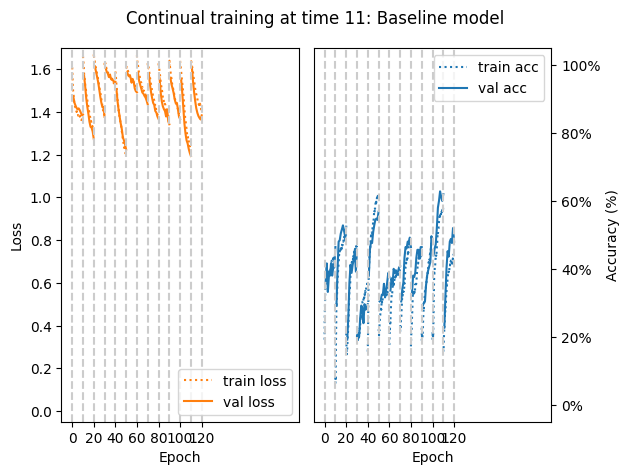

Baseline at t=11 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 24.80%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 18.40%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 12.80%
['bottle', 'bowl', 'can', 'cup', 'plate']: 17.60%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 23.20%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 22.40%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 19.20%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 29.60%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 30.40%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 27.20%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 41.60%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 48.00%

 +++ AVERAGE TASK TEST ACCURACY: 26.27% +++ 


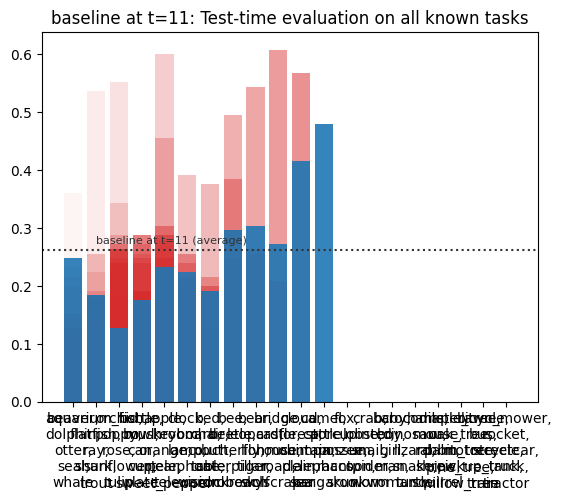

Training on task id: 12  (classification between: ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'])


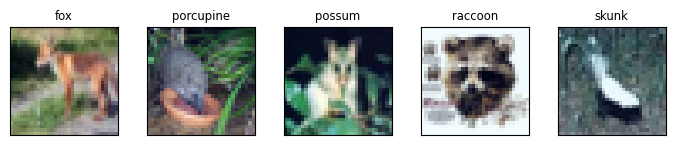

  Adding new task head 12 to multi-task model


E0 batch loss:1.58, batch acc:29.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.09it/s]


epoch:  0 | loss: 1.61 | 1.60   acc: 23.3% | 24.8%


E1 batch loss:1.52, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.92it/s]


epoch:  1 | loss: 1.56 | 1.57   acc: 32.2% | 28.0%


E2 batch loss:1.52, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.06it/s]


epoch:  2 | loss: 1.53 | 1.53   acc: 34.0% | 30.8%


E3 batch loss:1.47, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.23it/s]


epoch:  3 | loss: 1.50 | 1.52   acc: 36.0% | 31.2%


E4 batch loss:1.48, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.28it/s]


epoch:  4 | loss: 1.48 | 1.50   acc: 37.9% | 34.0%


E5 batch loss:1.46, batch acc:39.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.30it/s]


epoch:  5 | loss: 1.45 | 1.47   acc: 41.2% | 34.0%


E6 batch loss:1.41, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.40it/s]


epoch:  6 | loss: 1.44 | 1.46   acc: 42.5% | 35.6%


E7 batch loss:1.46, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.09it/s]


epoch:  7 | loss: 1.43 | 1.45   acc: 43.2% | 37.2%


E8 batch loss:1.40, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.13it/s]


epoch:  8 | loss: 1.41 | 1.44   acc: 44.6% | 38.4%


E9 batch loss:1.43, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.37it/s]


epoch:  9 | loss: 1.39 | 1.41   acc: 44.9% | 40.8%


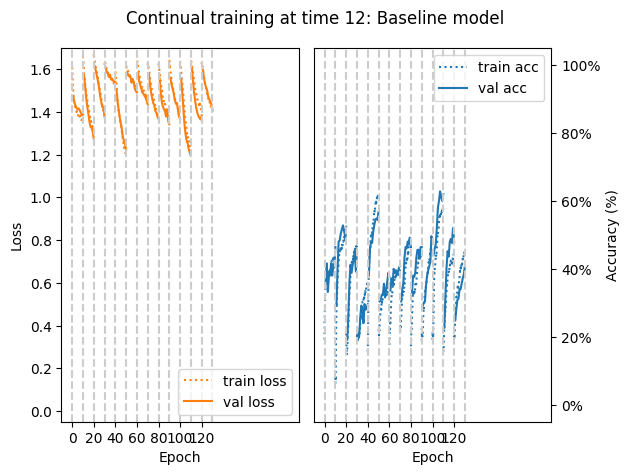

Baseline at t=12 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 24.80%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 17.60%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 15.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 22.40%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 26.40%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 20.00%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 18.40%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 20.00%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 19.20%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 20.80%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 24.00%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 32.00%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 40.80%

 +++ AVERAGE TASK TEST ACCURACY: 23.20% +++ 


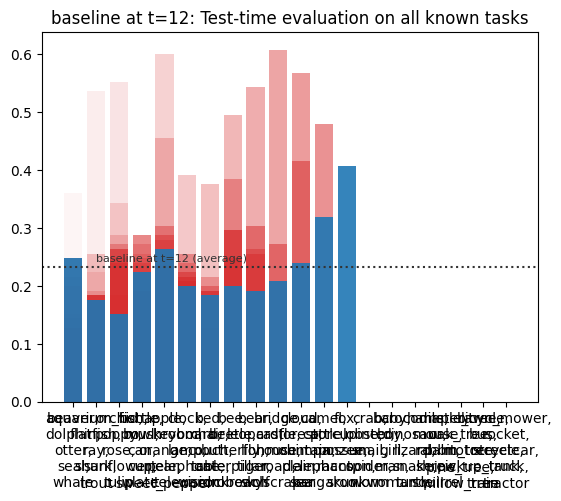

Training on task id: 13  (classification between: ['crab', 'lobster', 'snail', 'spider', 'worm'])


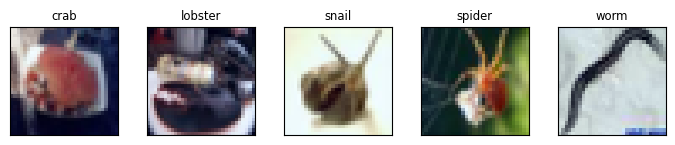

  Adding new task head 13 to multi-task model


E0 batch loss:1.60, batch acc:23.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.39it/s]


epoch:  0 | loss: 1.67 | 1.61   acc: 20.1% | 21.2%


E1 batch loss:1.58, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.64it/s]


epoch:  1 | loss: 1.60 | 1.58   acc: 25.1% | 24.4%


E2 batch loss:1.55, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.74it/s]


epoch:  2 | loss: 1.57 | 1.56   acc: 28.1% | 31.2%


E3 batch loss:1.52, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.54it/s]


epoch:  3 | loss: 1.54 | 1.53   acc: 36.9% | 37.2%


E4 batch loss:1.50, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.64it/s]


epoch:  4 | loss: 1.51 | 1.50   acc: 39.9% | 41.6%


E5 batch loss:1.50, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.35it/s]


epoch:  5 | loss: 1.49 | 1.48   acc: 40.5% | 42.0%


E6 batch loss:1.43, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.20it/s]


epoch:  6 | loss: 1.46 | 1.45   acc: 41.6% | 43.2%


E7 batch loss:1.46, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.19it/s]


epoch:  7 | loss: 1.44 | 1.43   acc: 43.4% | 44.4%


E8 batch loss:1.45, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.08it/s]


epoch:  8 | loss: 1.43 | 1.41   acc: 44.2% | 43.2%


E9 batch loss:1.41, batch acc:46.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.14it/s]


epoch:  9 | loss: 1.41 | 1.39   acc: 44.5% | 46.8%


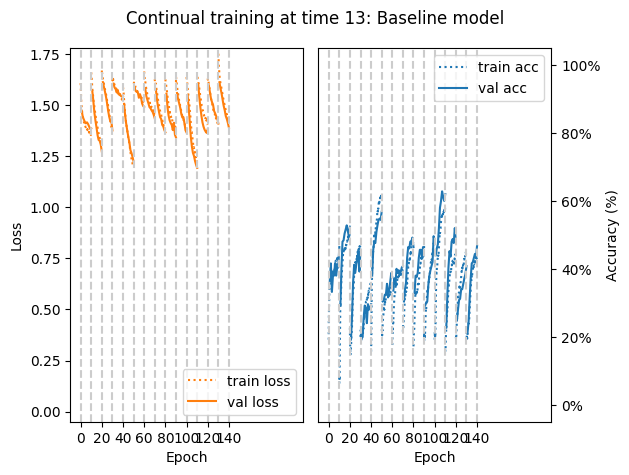

Baseline at t=13 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 20.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 24.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 21.60%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 22.40%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 12.80%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 19.20%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 14.40%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 22.40%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 23.20%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 23.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 40.00%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 28.00%
['crab', 'lobster', 'snail', 'spider', 'worm']: 53.60%

 +++ AVERAGE TASK TEST ACCURACY: 24.80% +++ 


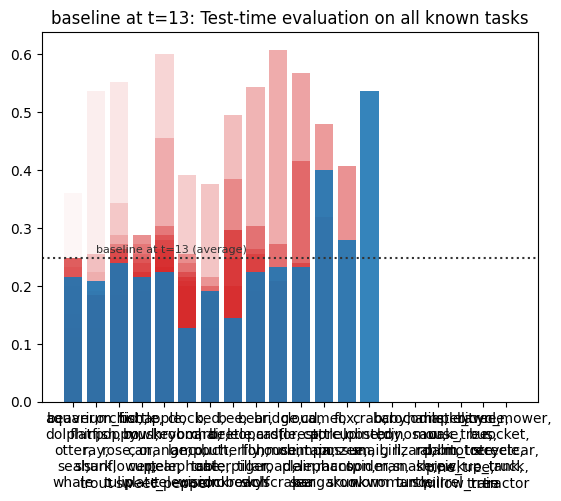

Training on task id: 14  (classification between: ['baby', 'boy', 'girl', 'man', 'woman'])


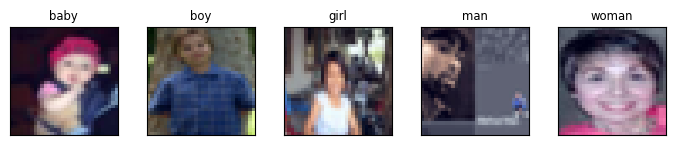

  Adding new task head 14 to multi-task model


E0 batch loss:1.59, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.27it/s]


epoch:  0 | loss: 1.62 | 1.62   acc: 19.4% | 20.4%


E1 batch loss:1.59, batch acc:26.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.16it/s]


epoch:  1 | loss: 1.60 | 1.62   acc: 25.2% | 20.0%


E2 batch loss:1.62, batch acc:24.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.20it/s]


epoch:  2 | loss: 1.60 | 1.60   acc: 26.1% | 24.0%


E3 batch loss:1.58, batch acc:29.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.16it/s]


epoch:  3 | loss: 1.59 | 1.60   acc: 25.1% | 26.0%


E4 batch loss:1.58, batch acc:26.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.10it/s]


epoch:  4 | loss: 1.58 | 1.59   acc: 28.0% | 26.4%


E5 batch loss:1.58, batch acc:29.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.16it/s]


epoch:  5 | loss: 1.57 | 1.59   acc: 29.4% | 26.8%


E6 batch loss:1.58, batch acc:28.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.18it/s]


epoch:  6 | loss: 1.57 | 1.59   acc: 29.5% | 24.8%


E7 batch loss:1.53, batch acc:39.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.18it/s]


epoch:  7 | loss: 1.56 | 1.59   acc: 32.2% | 24.4%


E8 batch loss:1.60, batch acc:19.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.12it/s]


epoch:  8 | loss: 1.56 | 1.59   acc: 28.9% | 27.2%


E9 batch loss:1.55, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.13it/s]


epoch:  9 | loss: 1.56 | 1.57   acc: 31.4% | 23.6%


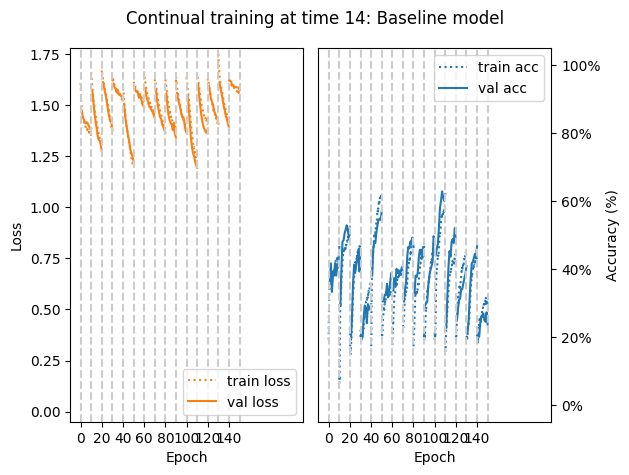

Baseline at t=14 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 24.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 24.80%
['bottle', 'bowl', 'can', 'cup', 'plate']: 17.60%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 33.60%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 20.80%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 18.40%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 28.00%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 18.40%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 16.80%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 23.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 29.60%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 27.20%
['crab', 'lobster', 'snail', 'spider', 'worm']: 27.20%
['baby', 'boy', 'girl', 'man', 'woman']: 23.20%

 +++ AVERAGE TASK TEST ACCURACY: 23.68% +++ 


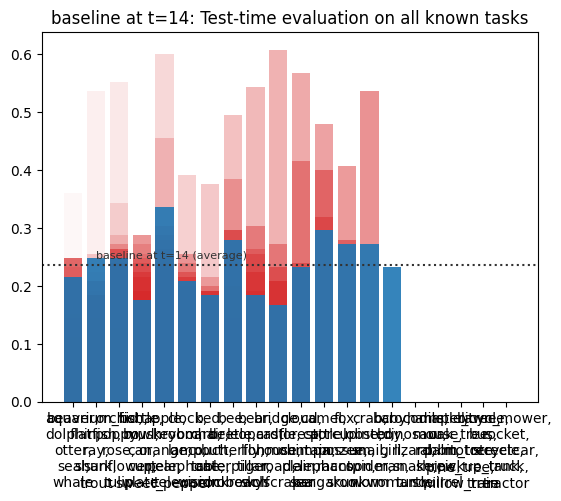

Training on task id: 15  (classification between: ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'])


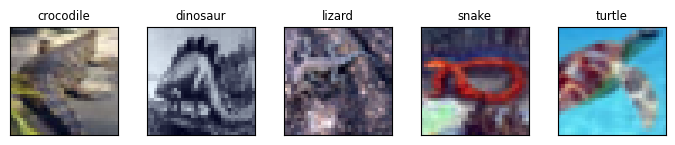

  Adding new task head 15 to multi-task model


E0 batch loss:1.58, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.00it/s]


epoch:  0 | loss: 1.61 | 1.58   acc: 25.3% | 32.8%


E1 batch loss:1.52, batch acc:31.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.65it/s]


epoch:  1 | loss: 1.55 | 1.54   acc: 31.2% | 40.0%


E2 batch loss:1.52, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.96it/s]


epoch:  2 | loss: 1.52 | 1.50   acc: 38.2% | 42.0%


E3 batch loss:1.50, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.13it/s]


epoch:  3 | loss: 1.49 | 1.48   acc: 38.1% | 42.8%


E4 batch loss:1.43, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.00it/s]


epoch:  4 | loss: 1.47 | 1.47   acc: 40.7% | 44.0%


E5 batch loss:1.47, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.77it/s]


epoch:  5 | loss: 1.46 | 1.45   acc: 42.2% | 45.6%


E6 batch loss:1.44, batch acc:37.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.17it/s]


epoch:  6 | loss: 1.44 | 1.45   acc: 42.0% | 43.2%


E7 batch loss:1.43, batch acc:45.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.17it/s]


epoch:  7 | loss: 1.43 | 1.44   acc: 43.0% | 43.6%


E8 batch loss:1.36, batch acc:58.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.87it/s]


epoch:  8 | loss: 1.42 | 1.43   acc: 44.7% | 45.6%


E9 batch loss:1.44, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.65it/s]


epoch:  9 | loss: 1.42 | 1.41   acc: 44.1% | 47.6%


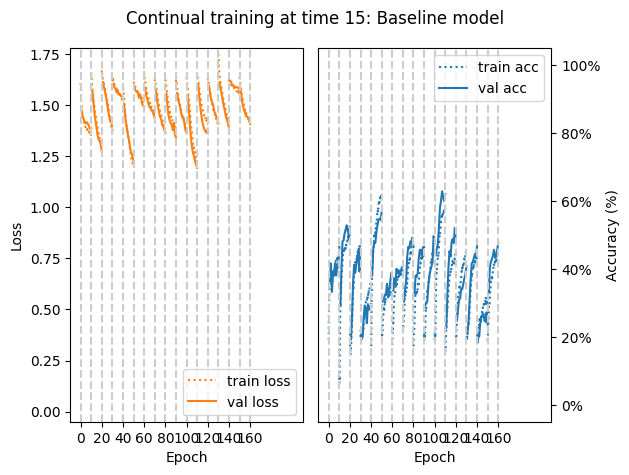

Baseline at t=15 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 16.00%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 19.20%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 27.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 20.00%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 17.60%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 21.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 11.20%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 23.20%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 18.40%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 17.60%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 23.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 20.00%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 24.80%
['crab', 'lobster', 'snail', 'spider', 'worm']: 25.60%
['baby', 'boy', 'girl', 'man', 'woman']: 23.20%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 45.60%

 +++ AV

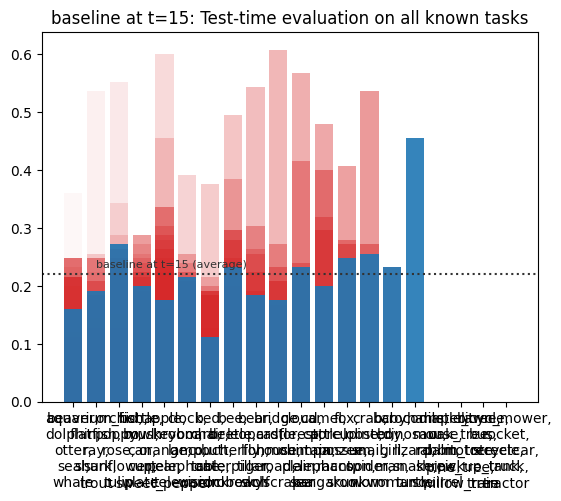

Training on task id: 16  (classification between: ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'])


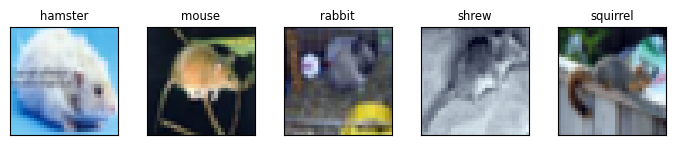

  Adding new task head 16 to multi-task model


E0 batch loss:1.64, batch acc:13.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.22it/s]


epoch:  0 | loss: 1.64 | 1.59   acc: 20.9% | 24.4%


E1 batch loss:1.58, batch acc:31.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.26it/s]


epoch:  1 | loss: 1.59 | 1.57   acc: 24.6% | 29.6%


E2 batch loss:1.57, batch acc:29.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.72it/s]


epoch:  2 | loss: 1.56 | 1.55   acc: 30.8% | 32.8%


E3 batch loss:1.53, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.13it/s]


epoch:  3 | loss: 1.54 | 1.53   acc: 34.2% | 40.8%


E4 batch loss:1.50, batch acc:33.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.14it/s]


epoch:  4 | loss: 1.52 | 1.50   acc: 37.0% | 38.4%


E5 batch loss:1.49, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.23it/s]


epoch:  5 | loss: 1.50 | 1.49   acc: 37.2% | 38.4%


E6 batch loss:1.53, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.16it/s]


epoch:  6 | loss: 1.49 | 1.48   acc: 36.9% | 37.6%


E7 batch loss:1.50, batch acc:39.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.22it/s]


epoch:  7 | loss: 1.48 | 1.46   acc: 39.0% | 41.2%


E8 batch loss:1.44, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.31it/s]


epoch:  8 | loss: 1.46 | 1.46   acc: 39.1% | 41.6%


E9 batch loss:1.42, batch acc:42.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.31it/s]


epoch:  9 | loss: 1.45 | 1.44   acc: 40.4% | 39.2%


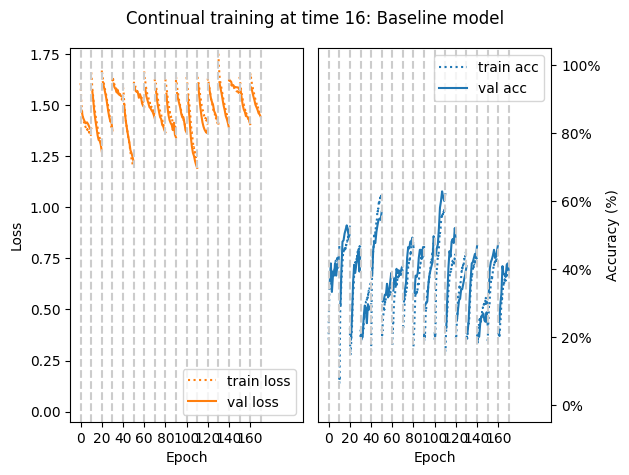

Baseline at t=16 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 16.00%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 20.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 26.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.00%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 24.80%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 21.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 13.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 25.60%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 16.80%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 16.00%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 23.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 21.60%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 28.00%
['crab', 'lobster', 'snail', 'spider', 'worm']: 24.80%
['baby', 'boy', 'girl', 'man', 'woman']: 22.40%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 24.00%
['hamste

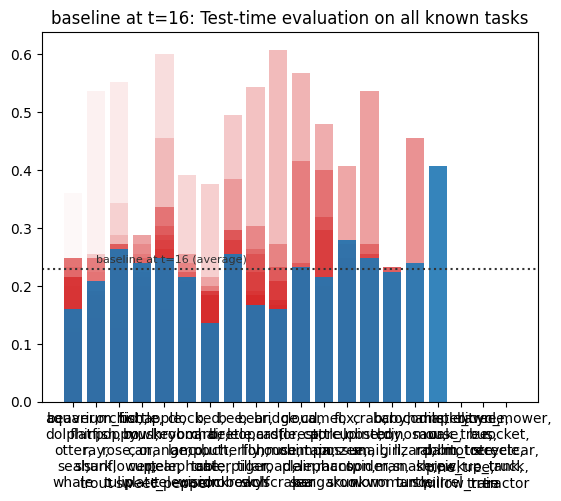

Training on task id: 17  (classification between: ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'])


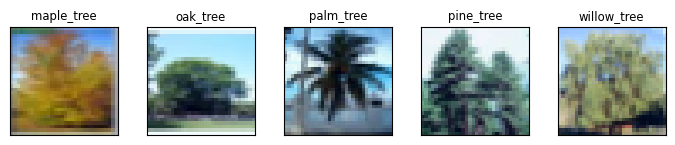

  Adding new task head 17 to multi-task model


E0 batch loss:1.63, batch acc:19.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.09it/s]


epoch:  0 | loss: 1.68 | 1.62   acc: 19.8% | 18.4%


E1 batch loss:1.59, batch acc:20.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.97it/s]


epoch:  1 | loss: 1.59 | 1.56   acc: 21.0% | 29.6%


E2 batch loss:1.56, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 23.39it/s]


epoch:  2 | loss: 1.57 | 1.53   acc: 29.5% | 37.2%


E3 batch loss:1.54, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 22.81it/s]


epoch:  3 | loss: 1.55 | 1.51   acc: 31.3% | 39.2%


E4 batch loss:1.50, batch acc:32.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.17it/s]


epoch:  4 | loss: 1.54 | 1.50   acc: 34.6% | 38.0%


E5 batch loss:1.58, batch acc:41.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.30it/s]


epoch:  5 | loss: 1.54 | 1.49   acc: 36.9% | 42.8%


E6 batch loss:1.52, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.42it/s]


epoch:  6 | loss: 1.52 | 1.48   acc: 39.9% | 42.4%


E7 batch loss:1.49, batch acc:36.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.59it/s]


epoch:  7 | loss: 1.50 | 1.46   acc: 39.9% | 43.6%


E8 batch loss:1.48, batch acc:44.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.74it/s]


epoch:  8 | loss: 1.49 | 1.45   acc: 41.8% | 42.8%


E9 batch loss:1.46, batch acc:48.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.69it/s]


epoch:  9 | loss: 1.48 | 1.44   acc: 41.8% | 42.8%


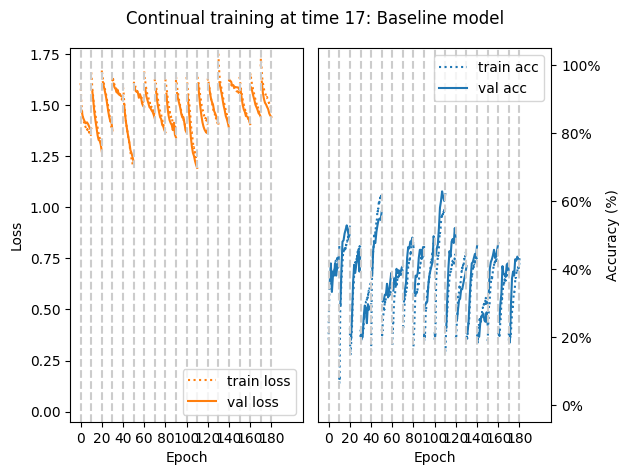

Baseline at t=17 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 20.00%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 28.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 24.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 21.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 21.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 23.20%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 27.20%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 18.40%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 23.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 23.20%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 16.00%
['crab', 'lobster', 'snail', 'spider', 'worm']: 23.20%
['baby', 'boy', 'girl', 'man', 'woman']: 17.60%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 14.40%
['hamste

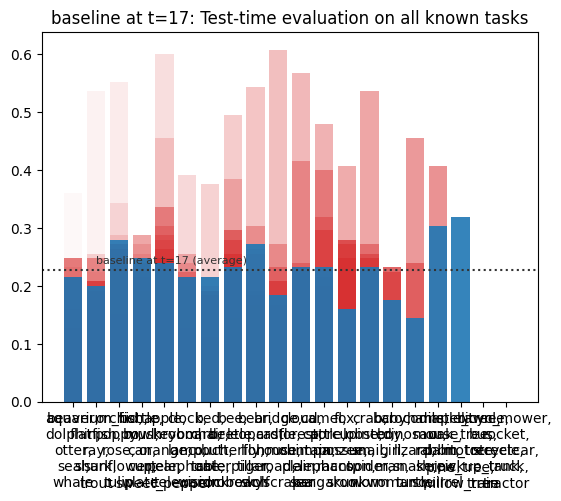

Training on task id: 18  (classification between: ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'])


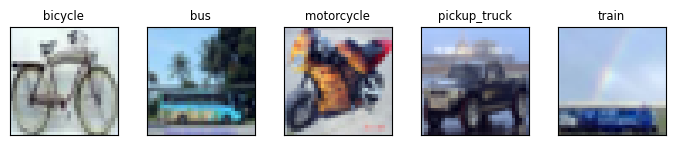

  Adding new task head 18 to multi-task model


E0 batch loss:1.62, batch acc:22.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.05it/s]


epoch:  0 | loss: 1.66 | 1.62   acc: 19.5% | 24.4%


E1 batch loss:1.61, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 22.86it/s]


epoch:  1 | loss: 1.61 | 1.61   acc: 21.7% | 26.0%


E2 batch loss:1.60, batch acc:24.7%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.15it/s]


epoch:  2 | loss: 1.60 | 1.60   acc: 25.1% | 30.0%


E3 batch loss:1.57, batch acc:35.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.24it/s]


epoch:  3 | loss: 1.59 | 1.58   acc: 32.2% | 31.6%


E4 batch loss:1.55, batch acc:39.0%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.27it/s]


epoch:  4 | loss: 1.57 | 1.57   acc: 32.3% | 29.2%


E5 batch loss:1.55, batch acc:27.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.29it/s]


epoch:  5 | loss: 1.55 | 1.54   acc: 32.5% | 33.6%


E6 batch loss:1.53, batch acc:28.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.28it/s]


epoch:  6 | loss: 1.53 | 1.51   acc: 32.7% | 36.8%


E7 batch loss:1.48, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.23it/s]


epoch:  7 | loss: 1.50 | 1.49   acc: 35.0% | 38.8%


E8 batch loss:1.52, batch acc:28.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.20it/s]


epoch:  8 | loss: 1.48 | 1.47   acc: 35.4% | 36.0%


E9 batch loss:1.49, batch acc:31.2%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.31it/s]


epoch:  9 | loss: 1.46 | 1.45   acc: 37.1% | 38.0%


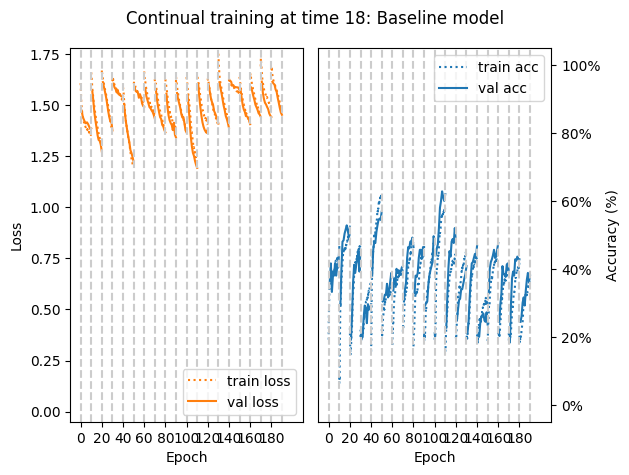

Baseline at t=18 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.00%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 34.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.00%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 24.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 21.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 23.20%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 12.80%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 12.00%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 16.00%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 21.60%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 30.40%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 20.80%
['crab', 'lobster', 'snail', 'spider', 'worm']: 23.20%
['baby', 'boy', 'girl', 'man', 'woman']: 21.60%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 17.60%
['hamste

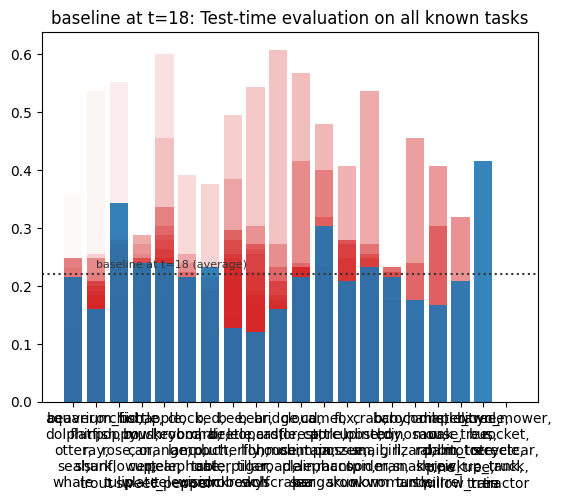

Training on task id: 19  (classification between: ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'])


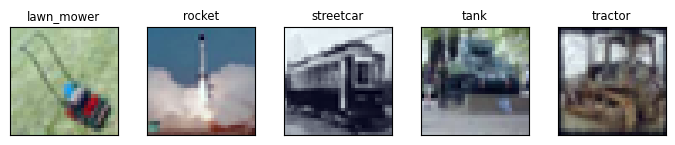

  Adding new task head 19 to multi-task model


E0 batch loss:1.60, batch acc:29.9%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.99it/s]


epoch:  0 | loss: 1.61 | 1.57   acc: 25.8% | 27.2%


E1 batch loss:1.50, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.05it/s]


epoch:  1 | loss: 1.53 | 1.51   acc: 35.8% | 40.0%


E2 batch loss:1.45, batch acc:49.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.05it/s]


epoch:  2 | loss: 1.47 | 1.45   acc: 42.3% | 44.0%


E3 batch loss:1.44, batch acc:40.3%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.99it/s]


epoch:  3 | loss: 1.42 | 1.41   acc: 44.1% | 48.4%


E4 batch loss:1.36, batch acc:50.6%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.53it/s]


epoch:  4 | loss: 1.37 | 1.36   acc: 49.2% | 52.0%


E5 batch loss:1.28, batch acc:54.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.03it/s]


epoch:  5 | loss: 1.32 | 1.32   acc: 52.5% | 52.0%


E6 batch loss:1.30, batch acc:48.1%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.44it/s]


epoch:  6 | loss: 1.27 | 1.26   acc: 53.9% | 55.6%


E7 batch loss:1.22, batch acc:58.4%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.91it/s]


epoch:  7 | loss: 1.23 | 1.23   acc: 56.2% | 56.0%


E8 batch loss:1.17, batch acc:55.8%: 100%|████████████████████████████| 9/9 [00:00<00:00, 24.93it/s]


epoch:  8 | loss: 1.19 | 1.20   acc: 57.4% | 57.2%


E9 batch loss:1.17, batch acc:54.5%: 100%|████████████████████████████| 9/9 [00:00<00:00, 25.03it/s]


epoch:  9 | loss: 1.16 | 1.19   acc: 58.2% | 58.4%


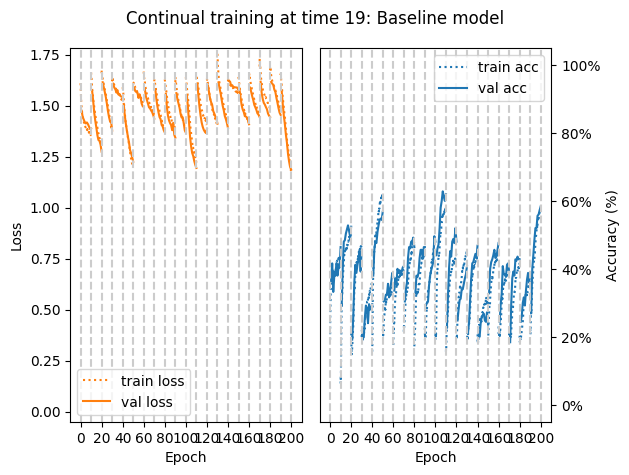

Baseline at t=19 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 22.40%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 20.00%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 28.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 24.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 18.40%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 32.80%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 14.40%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 20.80%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 16.00%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 21.60%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 23.20%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 20.00%
['crab', 'lobster', 'snail', 'spider', 'worm']: 26.40%
['baby', 'boy', 'girl', 'man', 'woman']: 18.40%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 14.40%
['hamste

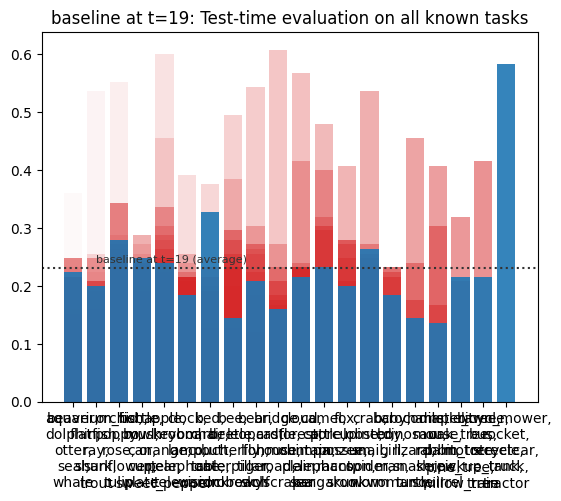


=== Baseline final accuracy averaged over all test tasks: 23.04% ===


In [17]:
INPUT_SIZE = (3,32,32)  # for cifar
baseline_model_training(timestep_tasks, task_test_sets, INPUT_SIZE)

### EWC IMPLEMENTATION


=== Training Task 0 ===
  Using self-paced curriculum learning with EWC
Task 0 | Epoch 0 | loss: 1.485/1.432 | acc: 35.3%/33.7%
  self-paced threshold: 0.120
Task 0 | Epoch 1 | loss: 1.339/1.362 | acc: 40.5%/42.3%
  self-paced threshold: 0.144
Task 0 | Epoch 2 | loss: 1.282/1.333 | acc: 40.7%/43.1%
  self-paced threshold: 0.173
Task 0 | Epoch 3 | loss: 1.245/1.330 | acc: 42.1%/36.9%
  self-paced threshold: 0.207
Task 0 | Epoch 4 | loss: 1.225/1.296 | acc: 44.3%/47.7%
  self-paced threshold: 0.249
Task 0 | Epoch 5 | loss: 1.202/1.258 | acc: 44.0%/47.7%
  self-paced threshold: 0.299
Task 0 | Epoch 6 | loss: 1.189/1.267 | acc: 46.3%/45.0%
  self-paced threshold: 0.358
Task 0 | Epoch 7 | loss: 1.179/1.260 | acc: 45.9%/47.0%
  self-paced threshold: 0.430
Task 0 | Epoch 8 | loss: 0.591/2.947 | acc: 78.4%/21.2%
  self-paced threshold: 0.516
Task 0 | Epoch 9 | loss: 0.112/3.899 | acc: 98.5%/21.2%
  self-paced threshold: 0.516


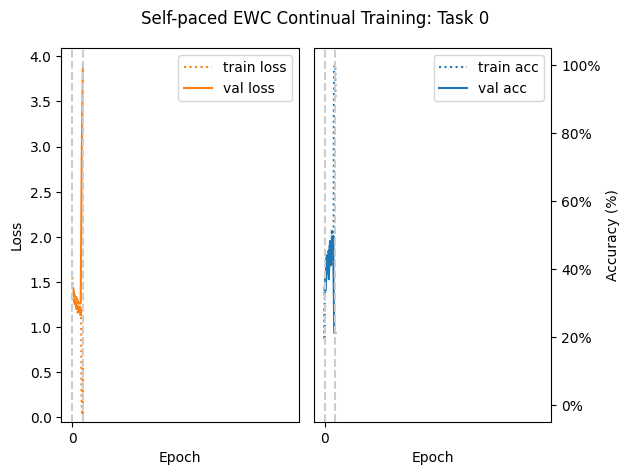

Selfpaced ewc at t=0 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%

 +++ AVERAGE TASK TEST ACCURACY: 21.60% +++ 


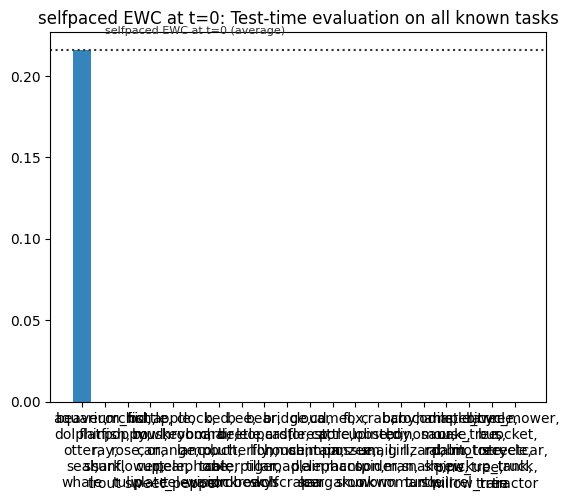


=== Training Task 1 ===
  Using self-paced curriculum learning with EWC
Task 1 | Epoch 0 | loss: 1.547/1.445 | acc: 38.0%/45.5%
  self-paced threshold: 0.619
Task 1 | Epoch 1 | loss: 1.416/1.316 | acc: 44.9%/49.3%
  self-paced threshold: 0.743
Task 1 | Epoch 2 | loss: 0.861/1.946 | acc: 78.2%/25.0%
  self-paced threshold: 0.892
Task 1 | Epoch 3 | loss: 0.160/2.897 | acc: 100.0%/21.8%
  self-paced threshold: 1.070
Task 1 | Epoch 4 | loss: 0.064/3.455 | acc: 100.0%/21.8%
  self-paced threshold: 1.284
Task 1 | Epoch 5 | loss: 0.035/3.924 | acc: 100.0%/21.8%
  self-paced threshold: 1.541
Task 1 | Epoch 6 | loss: 0.021/4.318 | acc: 100.0%/21.8%
  self-paced threshold: 1.849
Task 1 | Epoch 7 | loss: 0.014/4.629 | acc: 100.0%/21.8%
  self-paced threshold: 2.000
Task 1 | Epoch 8 | loss: 0.010/4.883 | acc: 100.0%/21.8%
  self-paced threshold: 2.000
Task 1 | Epoch 9 | loss: 0.008/5.103 | acc: 100.0%/21.8%
  self-paced threshold: 2.000


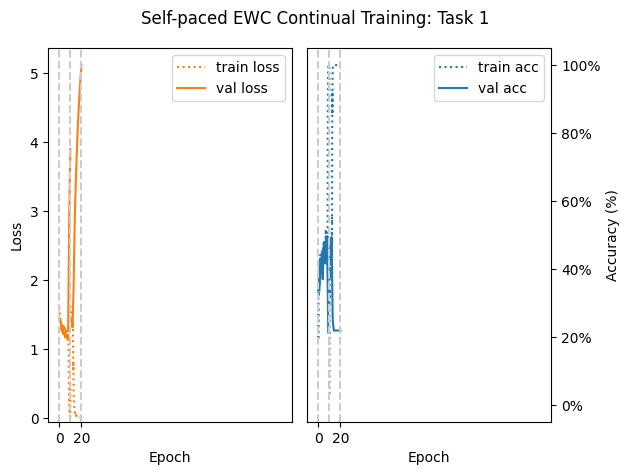

Selfpaced ewc at t=1 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%

 +++ AVERAGE TASK TEST ACCURACY: 19.20% +++ 


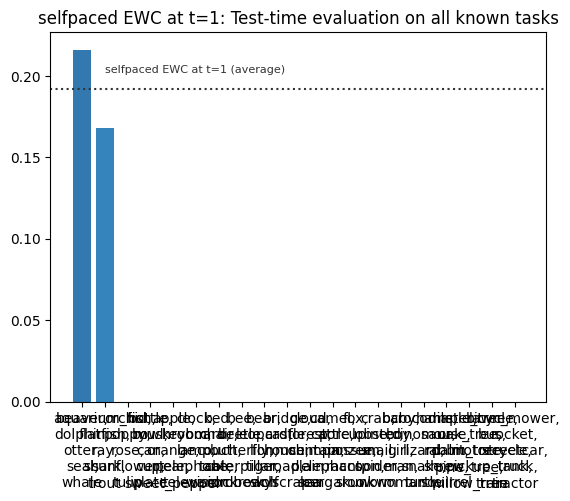


=== Training Task 2 ===
  Using self-paced curriculum learning with EWC
Task 2 | Epoch 0 | loss: 1.579/1.565 | acc: 28.1%/37.3%
  self-paced threshold: 2.000
Task 2 | Epoch 1 | loss: 1.506/1.517 | acc: 40.8%/37.3%
  self-paced threshold: 2.000
Task 2 | Epoch 2 | loss: 1.418/1.434 | acc: 47.7%/45.6%
  self-paced threshold: 2.000
Task 2 | Epoch 3 | loss: 1.278/1.359 | acc: 54.1%/45.0%
  self-paced threshold: 2.000
Task 2 | Epoch 4 | loss: 1.161/1.341 | acc: 56.4%/46.5%
  self-paced threshold: 2.000
Task 2 | Epoch 5 | loss: 1.054/1.340 | acc: 60.2%/50.4%
  self-paced threshold: 2.000
Task 2 | Epoch 6 | loss: 0.982/1.371 | acc: 61.5%/49.5%
  self-paced threshold: 2.000
Task 2 | Epoch 7 | loss: 0.919/1.367 | acc: 62.9%/47.6%
  self-paced threshold: 2.000
Task 2 | Epoch 8 | loss: 0.869/1.350 | acc: 65.5%/47.8%
  self-paced threshold: 2.000
Task 2 | Epoch 9 | loss: 0.862/1.465 | acc: 63.8%/48.9%
  self-paced threshold: 2.000


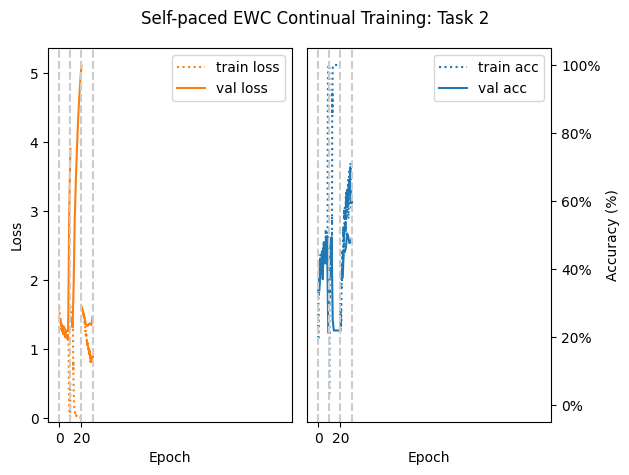

Selfpaced ewc at t=2 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 52.00%

 +++ AVERAGE TASK TEST ACCURACY: 30.13% +++ 


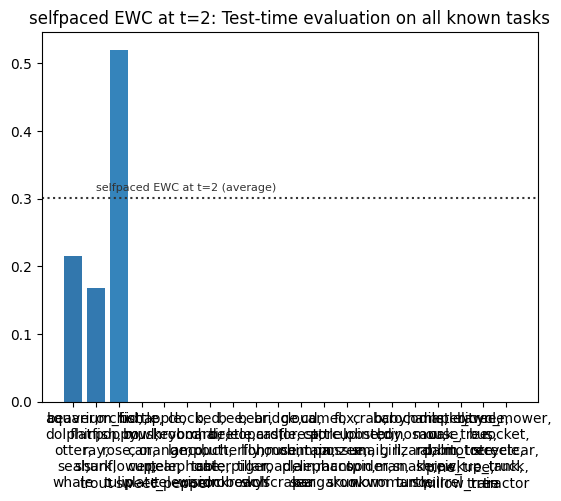


=== Training Task 3 ===
  Using self-paced curriculum learning with EWC
Task 3 | Epoch 0 | loss: 1.650/1.596 | acc: 23.9%/19.9%
  self-paced threshold: 2.000
Task 3 | Epoch 1 | loss: 1.626/1.581 | acc: 28.1%/22.8%
  self-paced threshold: 2.000
Task 3 | Epoch 2 | loss: 1.593/1.579 | acc: 32.0%/24.8%
  self-paced threshold: 2.000
Task 3 | Epoch 3 | loss: 1.539/1.606 | acc: 33.7%/24.3%
  self-paced threshold: 2.000
Task 3 | Epoch 4 | loss: 1.495/1.708 | acc: 35.2%/22.7%
  self-paced threshold: 2.000
Task 3 | Epoch 5 | loss: 1.440/1.768 | acc: 35.7%/24.5%
  self-paced threshold: 2.000
Task 3 | Epoch 6 | loss: 1.411/1.805 | acc: 37.2%/24.0%
  self-paced threshold: 2.000
Task 3 | Epoch 7 | loss: 1.396/1.878 | acc: 38.6%/25.2%
  self-paced threshold: 2.000
Task 3 | Epoch 8 | loss: 1.371/1.989 | acc: 39.6%/23.3%
  self-paced threshold: 2.000
Task 3 | Epoch 9 | loss: 1.355/1.962 | acc: 40.9%/24.1%
  self-paced threshold: 2.000


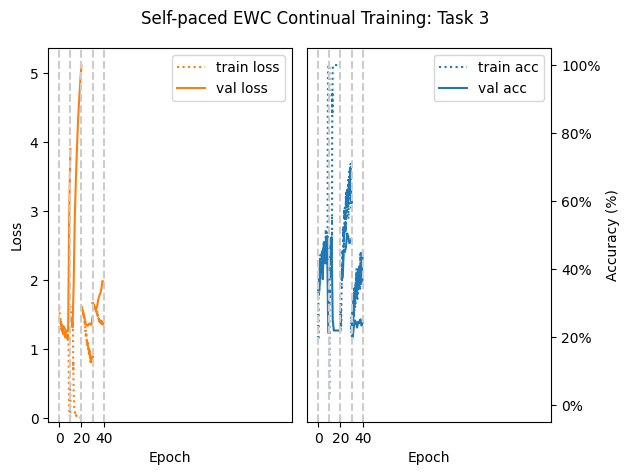

Selfpaced ewc at t=3 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 51.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 27.20%

 +++ AVERAGE TASK TEST ACCURACY: 29.20% +++ 


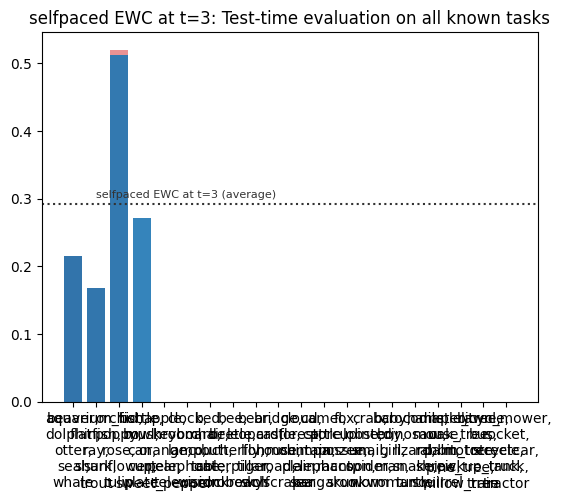


=== Training Task 4 ===
  Using self-paced curriculum learning with EWC
Task 4 | Epoch 0 | loss: 1.572/1.456 | acc: 44.6%/45.0%
  self-paced threshold: 2.000
Task 4 | Epoch 1 | loss: 1.462/1.377 | acc: 50.1%/46.7%
  self-paced threshold: 2.000
Task 4 | Epoch 2 | loss: 1.362/1.315 | acc: 53.3%/49.0%
  self-paced threshold: 2.000
Task 4 | Epoch 3 | loss: 1.259/1.308 | acc: 58.1%/47.5%
  self-paced threshold: 2.000
Task 4 | Epoch 4 | loss: 1.167/1.252 | acc: 60.7%/49.1%
  self-paced threshold: 2.000
Task 4 | Epoch 5 | loss: 1.064/1.247 | acc: 64.9%/50.4%
  self-paced threshold: 2.000
Task 4 | Epoch 6 | loss: 0.954/1.291 | acc: 68.4%/50.1%
  self-paced threshold: 2.000
Task 4 | Epoch 7 | loss: 0.872/1.343 | acc: 71.1%/53.0%
  self-paced threshold: 2.000
Task 4 | Epoch 8 | loss: 0.829/1.327 | acc: 71.4%/54.7%
  self-paced threshold: 2.000
Task 4 | Epoch 9 | loss: 0.777/1.314 | acc: 74.3%/54.0%
  self-paced threshold: 2.000


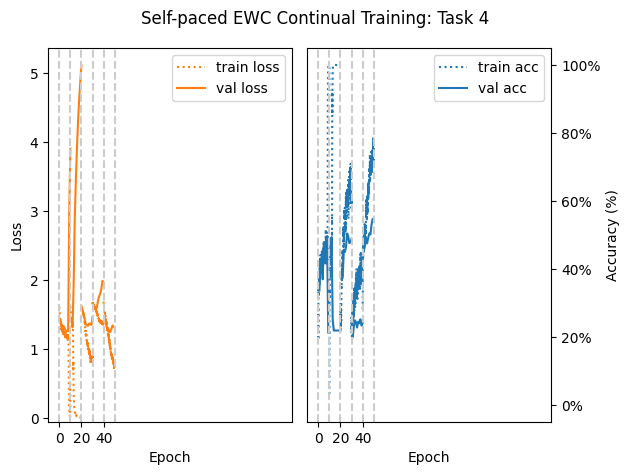

Selfpaced ewc at t=4 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 48.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 22.40%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 58.40%

 +++ AVERAGE TASK TEST ACCURACY: 33.44% +++ 


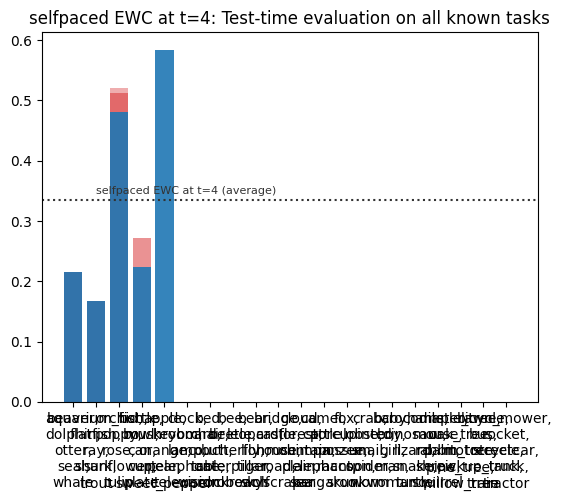


=== Training Task 5 ===
  Using self-paced curriculum learning with EWC
Task 5 | Epoch 0 | loss: 1.698/1.573 | acc: 25.9%/24.5%
  self-paced threshold: 2.000
Task 5 | Epoch 1 | loss: 1.672/1.557 | acc: 30.1%/34.9%
  self-paced threshold: 2.000
Task 5 | Epoch 2 | loss: 1.658/1.548 | acc: 32.5%/33.6%
  self-paced threshold: 2.000
Task 5 | Epoch 3 | loss: 1.640/1.538 | acc: 32.4%/31.9%
  self-paced threshold: 2.000
Task 5 | Epoch 4 | loss: 1.621/1.540 | acc: 32.7%/33.9%
  self-paced threshold: 2.000
Task 5 | Epoch 5 | loss: 1.582/1.553 | acc: 34.6%/34.9%
  self-paced threshold: 2.000
Task 5 | Epoch 6 | loss: 1.528/1.558 | acc: 35.5%/32.5%
  self-paced threshold: 2.000
Task 5 | Epoch 7 | loss: 1.508/1.608 | acc: 37.4%/26.0%
  self-paced threshold: 2.000
Task 5 | Epoch 8 | loss: 1.480/1.588 | acc: 37.8%/34.7%
  self-paced threshold: 2.000
Task 5 | Epoch 9 | loss: 1.452/1.621 | acc: 39.0%/36.8%
  self-paced threshold: 2.000


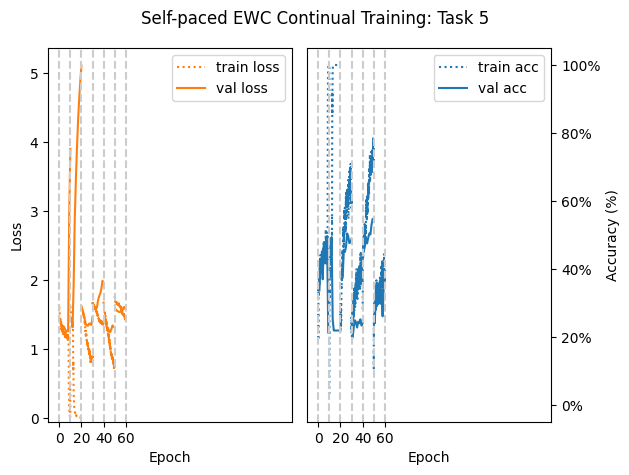

Selfpaced ewc at t=5 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 45.60%
['bottle', 'bowl', 'can', 'cup', 'plate']: 28.00%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 47.20%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 37.60%

 +++ AVERAGE TASK TEST ACCURACY: 32.80% +++ 


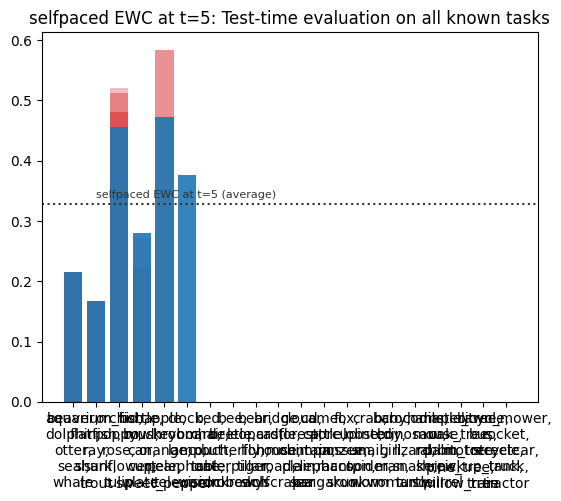


=== Training Task 6 ===
  Using self-paced curriculum learning with EWC
Task 6 | Epoch 0 | loss: 1.685/1.517 | acc: 33.2%/37.2%
  self-paced threshold: 2.000
Task 6 | Epoch 1 | loss: 1.631/1.479 | acc: 35.6%/36.4%
  self-paced threshold: 2.000
Task 6 | Epoch 2 | loss: 1.581/1.453 | acc: 37.2%/36.7%
  self-paced threshold: 2.000
Task 6 | Epoch 3 | loss: 1.512/1.464 | acc: 40.4%/36.4%
  self-paced threshold: 2.000
Task 6 | Epoch 4 | loss: 1.466/1.447 | acc: 40.8%/38.4%
  self-paced threshold: 2.000
Task 6 | Epoch 5 | loss: 1.412/1.434 | acc: 43.6%/36.9%
  self-paced threshold: 2.000
Task 6 | Epoch 6 | loss: 1.350/1.460 | acc: 46.6%/37.0%
  self-paced threshold: 2.000
Task 6 | Epoch 7 | loss: 1.307/1.493 | acc: 46.3%/35.4%
  self-paced threshold: 2.000
Task 6 | Epoch 8 | loss: 1.257/1.512 | acc: 47.9%/35.4%
  self-paced threshold: 2.000
Task 6 | Epoch 9 | loss: 1.230/1.527 | acc: 49.8%/39.0%
  self-paced threshold: 2.000


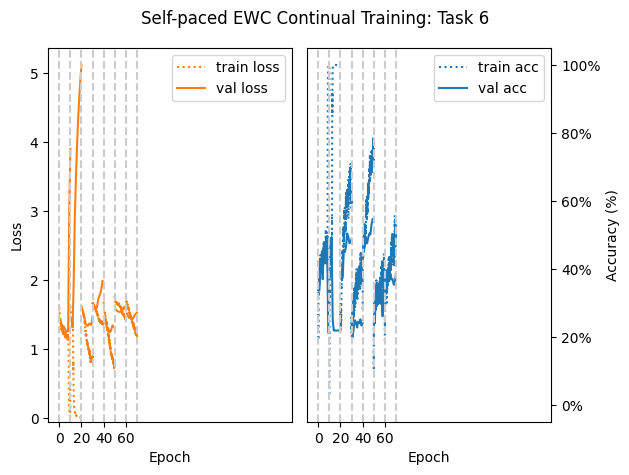

Selfpaced ewc at t=6 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 51.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 25.60%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 44.80%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 35.20%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 35.20%

 +++ AVERAGE TASK TEST ACCURACY: 32.91% +++ 


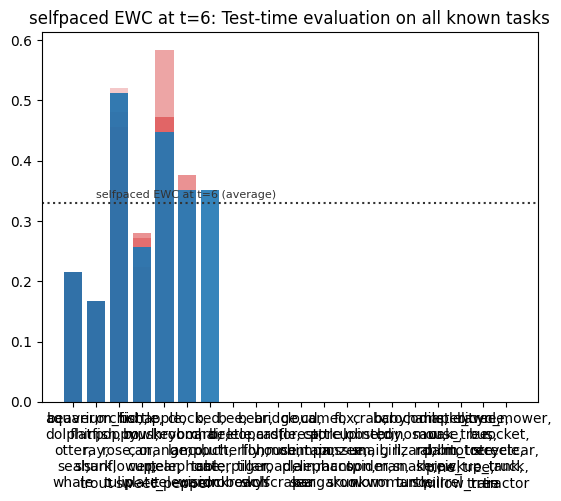


=== Training Task 7 ===
  Using self-paced curriculum learning with EWC
Task 7 | Epoch 0 | loss: 1.675/1.472 | acc: 34.5%/44.1%
  self-paced threshold: 2.000
Task 7 | Epoch 1 | loss: 1.590/1.416 | acc: 40.8%/43.4%
  self-paced threshold: 2.000
Task 7 | Epoch 2 | loss: 1.523/1.367 | acc: 40.8%/43.2%
  self-paced threshold: 2.000
Task 7 | Epoch 3 | loss: 1.472/1.340 | acc: 42.5%/43.2%
  self-paced threshold: 2.000
Task 7 | Epoch 4 | loss: 1.424/1.337 | acc: 45.0%/41.8%
  self-paced threshold: 2.000
Task 7 | Epoch 5 | loss: 1.391/1.333 | acc: 43.6%/42.5%
  self-paced threshold: 2.000
Task 7 | Epoch 6 | loss: 1.347/1.336 | acc: 46.0%/45.4%
  self-paced threshold: 2.000
Task 7 | Epoch 7 | loss: 1.317/1.307 | acc: 46.9%/46.7%
  self-paced threshold: 2.000
Task 7 | Epoch 8 | loss: 1.251/1.325 | acc: 51.3%/43.4%
  self-paced threshold: 2.000
Task 7 | Epoch 9 | loss: 1.203/1.333 | acc: 52.6%/46.1%
  self-paced threshold: 2.000


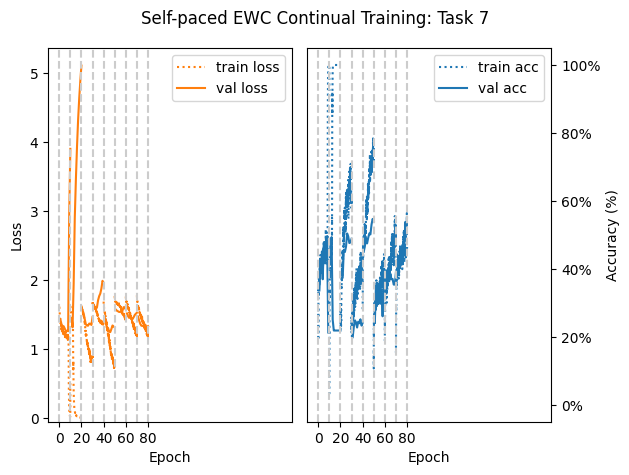

Selfpaced ewc at t=7 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 47.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 53.60%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 33.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 34.40%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 45.60%

 +++ AVERAGE TASK TEST ACCURACY: 34.70% +++ 


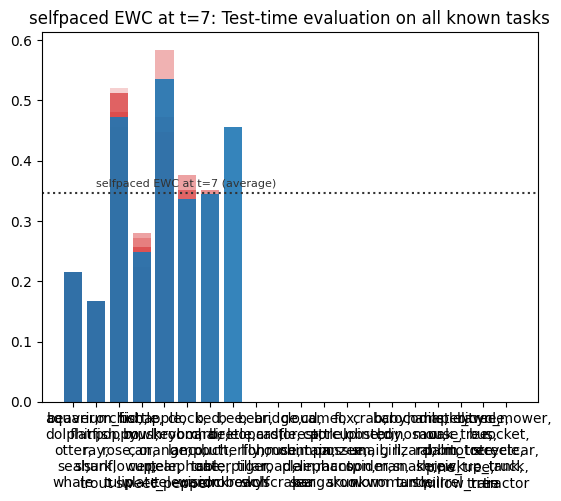


=== Training Task 8 ===
  Using self-paced curriculum learning with EWC
Task 8 | Epoch 0 | loss: 1.693/1.506 | acc: 29.9%/30.8%
  self-paced threshold: 2.000
Task 8 | Epoch 1 | loss: 1.616/1.451 | acc: 34.9%/31.6%
  self-paced threshold: 2.000
Task 8 | Epoch 2 | loss: 1.531/1.413 | acc: 37.8%/33.5%
  self-paced threshold: 2.000
Task 8 | Epoch 3 | loss: 1.427/1.400 | acc: 40.7%/33.8%
  self-paced threshold: 2.000
Task 8 | Epoch 4 | loss: 1.353/1.398 | acc: 42.7%/35.0%
  self-paced threshold: 2.000
Task 8 | Epoch 5 | loss: 1.296/1.409 | acc: 44.9%/36.8%
  self-paced threshold: 2.000
Task 8 | Epoch 6 | loss: 1.260/1.447 | acc: 46.7%/33.4%
  self-paced threshold: 2.000
Task 8 | Epoch 7 | loss: 1.234/1.450 | acc: 46.2%/36.3%
  self-paced threshold: 2.000
Task 8 | Epoch 8 | loss: 1.204/1.514 | acc: 47.7%/37.5%
  self-paced threshold: 2.000
Task 8 | Epoch 9 | loss: 1.192/1.588 | acc: 49.0%/34.8%
  self-paced threshold: 2.000


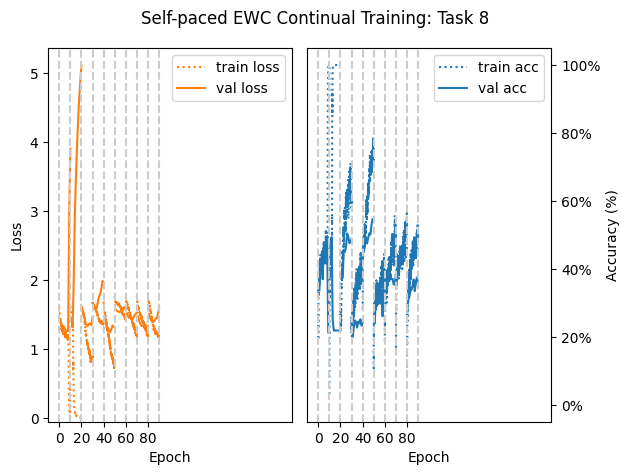

Selfpaced ewc at t=8 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 24.80%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 17.60%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 43.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.00%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 26.40%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 34.40%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 32.80%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 41.60%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 35.20%

 +++ AVERAGE TASK TEST ACCURACY: 31.11% +++ 


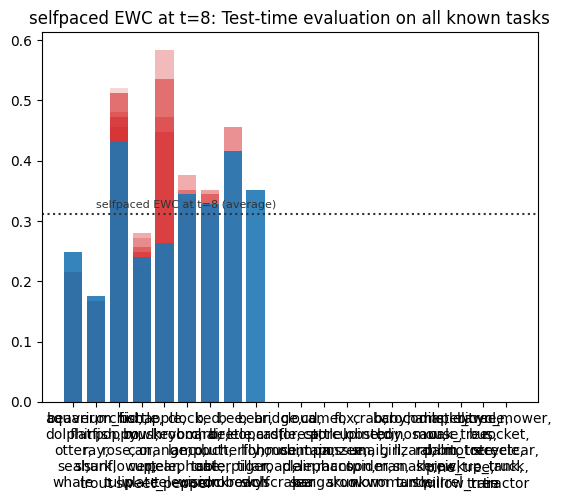


=== Training Task 9 ===
  Using self-paced curriculum learning with EWC
Task 9 | Epoch 0 | loss: 1.729/1.560 | acc: 28.9%/28.9%
  self-paced threshold: 2.000
Task 9 | Epoch 1 | loss: 1.688/1.528 | acc: 33.7%/33.3%
  self-paced threshold: 2.000
Task 9 | Epoch 2 | loss: 1.640/1.512 | acc: 36.8%/29.0%
  self-paced threshold: 2.000
Task 9 | Epoch 3 | loss: 1.568/1.565 | acc: 40.3%/27.2%
  self-paced threshold: 2.000
Task 9 | Epoch 4 | loss: 1.488/1.498 | acc: 42.5%/33.0%
  self-paced threshold: 2.000
Task 9 | Epoch 5 | loss: 1.418/1.561 | acc: 43.1%/30.1%
  self-paced threshold: 2.000
Task 9 | Epoch 6 | loss: 1.375/1.547 | acc: 43.5%/33.4%
  self-paced threshold: 2.000
Task 9 | Epoch 7 | loss: 1.334/1.629 | acc: 45.7%/31.3%
  self-paced threshold: 2.000
Task 9 | Epoch 8 | loss: 1.324/1.614 | acc: 45.4%/32.2%
  self-paced threshold: 2.000
Task 9 | Epoch 9 | loss: 1.295/1.619 | acc: 47.1%/35.0%
  self-paced threshold: 2.000


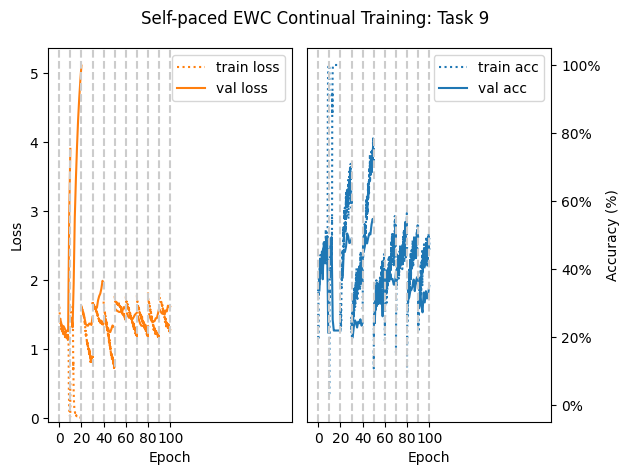

Selfpaced ewc at t=9 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 17.60%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 40.80%
['bottle', 'bowl', 'can', 'cup', 'plate']: 20.00%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 31.20%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 26.40%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 34.40%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 40.00%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 33.60%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 50.40%

 +++ AVERAGE TASK TEST ACCURACY: 31.60% +++ 


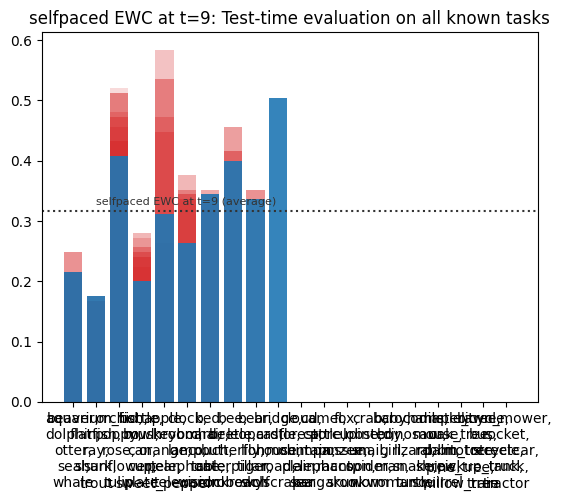


=== Training Task 10 ===
  Using self-paced curriculum learning with EWC
Task 10 | Epoch 0 | loss: 1.663/1.394 | acc: 41.7%/49.0%
  self-paced threshold: 2.000
Task 10 | Epoch 1 | loss: 1.524/1.295 | acc: 51.1%/49.5%
  self-paced threshold: 2.000
Task 10 | Epoch 2 | loss: 1.404/1.246 | acc: 54.0%/47.7%
  self-paced threshold: 2.000
Task 10 | Epoch 3 | loss: 1.313/1.208 | acc: 55.6%/51.5%
  self-paced threshold: 2.000
Task 10 | Epoch 4 | loss: 1.245/1.168 | acc: 56.8%/52.5%
  self-paced threshold: 2.000
Task 10 | Epoch 5 | loss: 1.194/1.171 | acc: 57.7%/52.0%
  self-paced threshold: 2.000
Task 10 | Epoch 6 | loss: 1.163/1.118 | acc: 58.9%/53.0%
  self-paced threshold: 2.000
Task 10 | Epoch 7 | loss: 1.132/1.134 | acc: 58.6%/51.8%
  self-paced threshold: 2.000
Task 10 | Epoch 8 | loss: 1.091/1.115 | acc: 60.5%/51.9%
  self-paced threshold: 2.000
Task 10 | Epoch 9 | loss: 1.079/1.116 | acc: 61.2%/53.5%
  self-paced threshold: 2.000


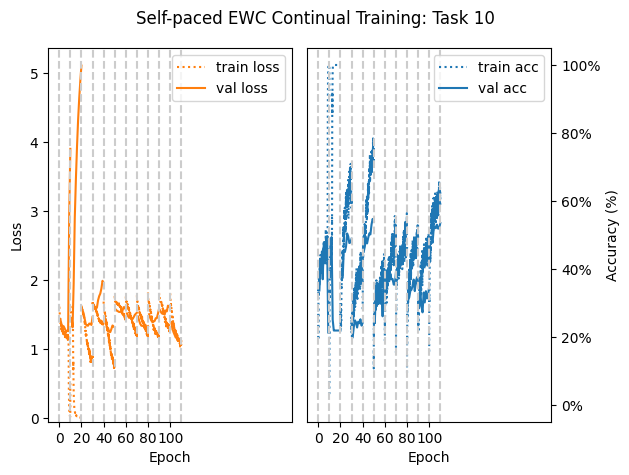

Selfpaced ewc at t=10 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 44.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 27.20%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 34.40%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 26.40%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 33.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 40.80%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 36.80%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 49.60%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 56.00%

 +++ AVERAGE TASK TEST ACCURACY: 35.20% +++ 


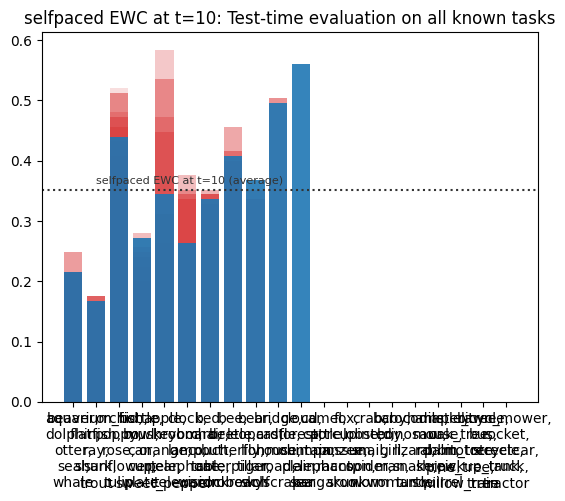


=== Training Task 11 ===
  Using self-paced curriculum learning with EWC
Task 11 | Epoch 0 | loss: 1.765/1.530 | acc: 30.7%/39.4%
  self-paced threshold: 2.000
Task 11 | Epoch 1 | loss: 1.715/1.486 | acc: 36.3%/40.4%
  self-paced threshold: 2.000
Task 11 | Epoch 2 | loss: 1.666/1.449 | acc: 37.6%/42.9%
  self-paced threshold: 2.000
Task 11 | Epoch 3 | loss: 1.629/1.412 | acc: 38.7%/40.1%
  self-paced threshold: 2.000
Task 11 | Epoch 4 | loss: 1.577/1.396 | acc: 40.2%/41.9%
  self-paced threshold: 2.000
Task 11 | Epoch 5 | loss: 1.524/1.379 | acc: 42.5%/42.4%
  self-paced threshold: 2.000
Task 11 | Epoch 6 | loss: 1.463/1.366 | acc: 44.9%/43.9%
  self-paced threshold: 2.000
Task 11 | Epoch 7 | loss: 1.409/1.377 | acc: 47.2%/43.9%
  self-paced threshold: 2.000
Task 11 | Epoch 8 | loss: 1.364/1.389 | acc: 48.7%/42.4%
  self-paced threshold: 2.000
Task 11 | Epoch 9 | loss: 1.315/1.565 | acc: 50.6%/37.5%
  self-paced threshold: 2.000


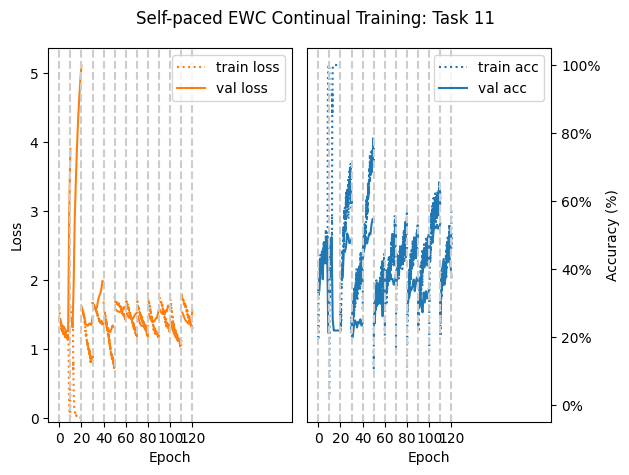

Selfpaced ewc at t=11 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 23.20%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 46.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 25.60%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 33.60%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 31.20%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 33.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 40.80%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 40.80%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 43.20%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 55.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 36.80%

 +++ AVERAGE TASK TEST ACCURACY: 35.60% +++ 


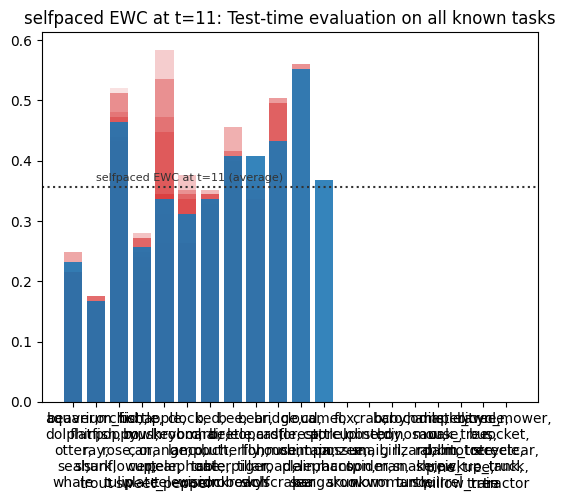


=== Training Task 12 ===
  Using self-paced curriculum learning with EWC
Task 12 | Epoch 0 | loss: 1.767/1.578 | acc: 22.7%/27.7%
  self-paced threshold: 2.000
Task 12 | Epoch 1 | loss: 1.731/1.570 | acc: 29.6%/27.0%
  self-paced threshold: 2.000
Task 12 | Epoch 2 | loss: 1.701/1.566 | acc: 32.3%/31.1%
  self-paced threshold: 2.000
Task 12 | Epoch 3 | loss: 1.666/1.552 | acc: 35.9%/36.6%
  self-paced threshold: 2.000
Task 12 | Epoch 4 | loss: 1.633/1.572 | acc: 36.5%/33.4%
  self-paced threshold: 2.000
Task 12 | Epoch 5 | loss: 1.609/1.566 | acc: 38.1%/37.0%
  self-paced threshold: 2.000
Task 12 | Epoch 6 | loss: 1.575/1.562 | acc: 41.4%/37.4%
  self-paced threshold: 2.000
Task 12 | Epoch 7 | loss: 1.538/1.596 | acc: 41.8%/32.8%
  self-paced threshold: 2.000
Task 12 | Epoch 8 | loss: 1.509/1.600 | acc: 40.7%/31.7%
  self-paced threshold: 2.000
Task 12 | Epoch 9 | loss: 1.474/1.625 | acc: 42.8%/33.7%
  self-paced threshold: 2.000


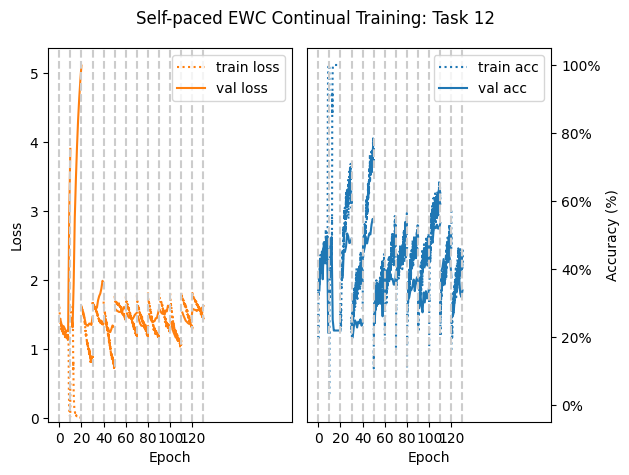

Selfpaced ewc at t=12 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 47.20%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 34.40%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 35.20%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 33.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 44.00%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 43.20%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 39.20%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 52.00%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 33.60%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 36.00%

 +++ AVERAGE TASK TEST ACCURACY: 35.51% +++ 


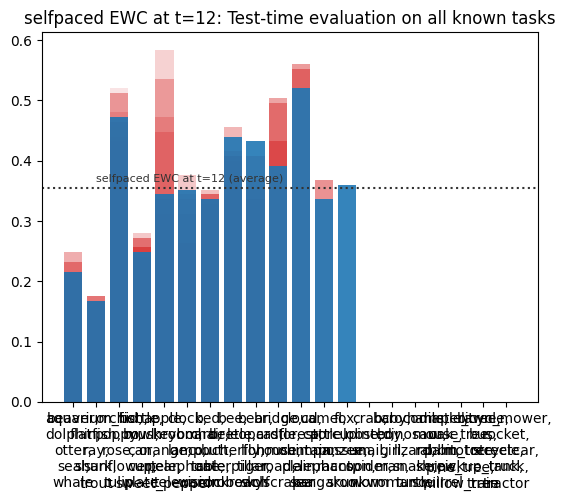


=== Training Task 13 ===
  Using self-paced curriculum learning with EWC
Task 13 | Epoch 0 | loss: 1.780/1.553 | acc: 30.3%/31.3%
  self-paced threshold: 2.000
Task 13 | Epoch 1 | loss: 1.741/1.519 | acc: 35.4%/37.4%
  self-paced threshold: 2.000
Task 13 | Epoch 2 | loss: 1.701/1.480 | acc: 36.4%/39.5%
  self-paced threshold: 2.000
Task 13 | Epoch 3 | loss: 1.641/1.446 | acc: 39.0%/39.3%
  self-paced threshold: 2.000
Task 13 | Epoch 4 | loss: 1.575/1.435 | acc: 41.3%/38.1%
  self-paced threshold: 2.000
Task 13 | Epoch 5 | loss: 1.493/1.427 | acc: 43.7%/36.4%
  self-paced threshold: 2.000
Task 13 | Epoch 6 | loss: 1.433/1.421 | acc: 46.4%/36.0%
  self-paced threshold: 2.000
Task 13 | Epoch 7 | loss: 1.362/1.423 | acc: 47.7%/35.3%
  self-paced threshold: 2.000
Task 13 | Epoch 8 | loss: 1.314/1.464 | acc: 48.4%/37.4%
  self-paced threshold: 2.000
Task 13 | Epoch 9 | loss: 1.249/1.500 | acc: 51.4%/37.5%
  self-paced threshold: 2.000


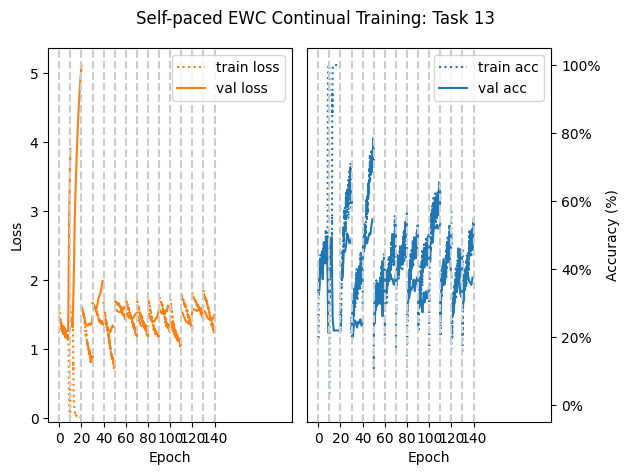

Selfpaced ewc at t=13 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 44.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 23.20%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 36.80%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 28.80%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 32.00%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 38.40%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 45.60%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 44.00%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 56.00%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 32.00%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 32.80%
['crab', 'lobster', 'snail', 'spider', 'worm']: 51.20%

 +++ AVERAGE TASK TEST ACCURACY: 35.94% +++ 


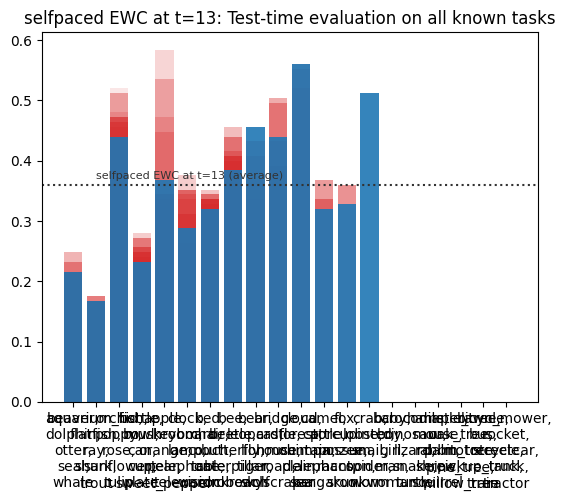


=== Training Task 14 ===
  Using self-paced curriculum learning with EWC
Task 14 | Epoch 0 | loss: 1.810/1.611 | acc: 22.3%/15.9%
  self-paced threshold: 2.000
Task 14 | Epoch 1 | loss: 1.799/1.601 | acc: 25.2%/23.7%
  self-paced threshold: 2.000
Task 14 | Epoch 2 | loss: 1.796/1.604 | acc: 26.4%/19.6%
  self-paced threshold: 2.000
Task 14 | Epoch 3 | loss: 1.790/1.604 | acc: 26.0%/19.4%
  self-paced threshold: 2.000
Task 14 | Epoch 4 | loss: 1.787/1.599 | acc: 27.2%/21.8%
  self-paced threshold: 2.000
Task 14 | Epoch 5 | loss: 1.783/1.593 | acc: 26.9%/22.0%
  self-paced threshold: 2.000
Task 14 | Epoch 6 | loss: 1.777/1.594 | acc: 27.6%/22.5%
  self-paced threshold: 2.000
Task 14 | Epoch 7 | loss: 1.769/1.592 | acc: 28.0%/23.6%
  self-paced threshold: 2.000
Task 14 | Epoch 8 | loss: 1.753/1.617 | acc: 28.0%/17.0%
  self-paced threshold: 2.000
Task 14 | Epoch 9 | loss: 1.737/1.601 | acc: 28.5%/25.2%
  self-paced threshold: 2.000


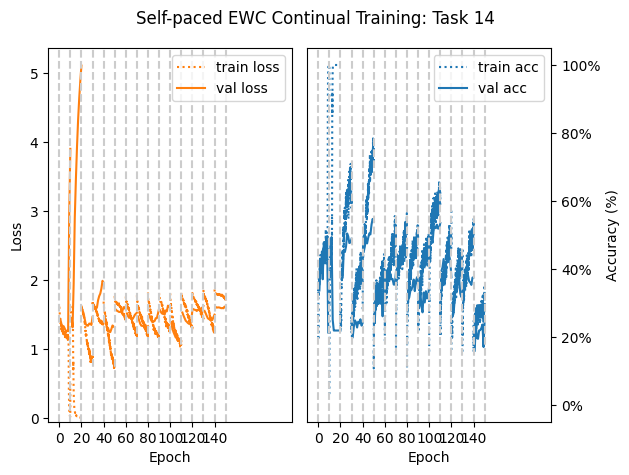

Selfpaced ewc at t=14 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 46.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 26.40%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 40.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 33.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 33.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 44.00%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 44.80%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 40.80%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 52.80%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 32.80%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 34.40%
['crab', 'lobster', 'snail', 'spider', 'worm']: 40.80%
['baby', 'boy', 'girl', 'man', 'woman']: 24.80%

 +++ AVERAGE TASK TEST ACCURACY: 35.57% +++ 


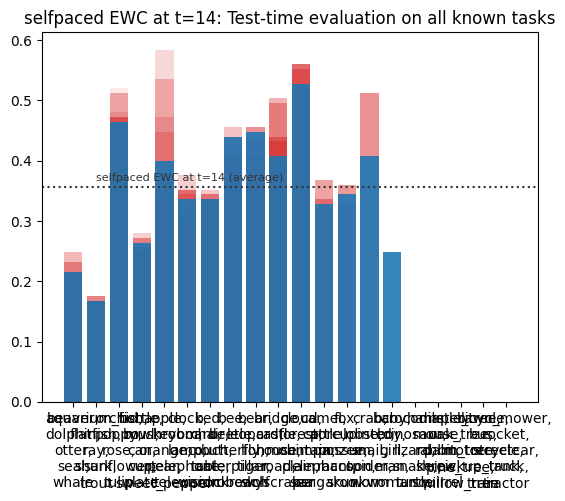


=== Training Task 15 ===
  Using self-paced curriculum learning with EWC
Task 15 | Epoch 0 | loss: 1.789/1.557 | acc: 30.0%/34.6%
  self-paced threshold: 2.000
Task 15 | Epoch 1 | loss: 1.753/1.536 | acc: 33.7%/36.0%
  self-paced threshold: 2.000
Task 15 | Epoch 2 | loss: 1.724/1.505 | acc: 34.8%/36.7%
  self-paced threshold: 2.000
Task 15 | Epoch 3 | loss: 1.683/1.489 | acc: 36.5%/41.6%
  self-paced threshold: 2.000
Task 15 | Epoch 4 | loss: 1.620/1.490 | acc: 39.0%/33.7%
  self-paced threshold: 2.000
Task 15 | Epoch 5 | loss: 1.558/1.483 | acc: 41.6%/34.0%
  self-paced threshold: 2.000
Task 15 | Epoch 6 | loss: 1.503/1.483 | acc: 43.1%/38.5%
  self-paced threshold: 2.000
Task 15 | Epoch 7 | loss: 1.465/1.504 | acc: 44.3%/37.1%
  self-paced threshold: 2.000
Task 15 | Epoch 8 | loss: 1.415/1.505 | acc: 45.9%/39.1%
  self-paced threshold: 2.000
Task 15 | Epoch 9 | loss: 1.378/1.528 | acc: 47.0%/39.3%
  self-paced threshold: 2.000


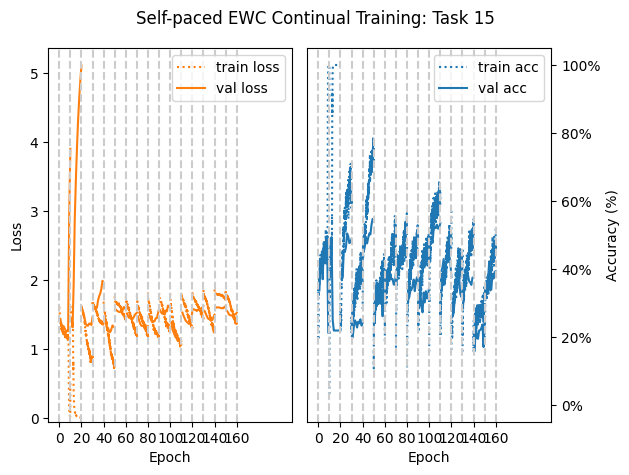

Selfpaced ewc at t=15 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 24.00%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 40.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 25.60%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 33.60%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 29.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 35.20%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 38.40%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 39.20%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 40.00%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 51.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 37.60%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 28.00%
['crab', 'lobster', 'snail', 'spider', 'worm']: 45.60%
['baby', 'boy', 'girl', 'man', 'woman']: 20.80%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 35.20%

 +

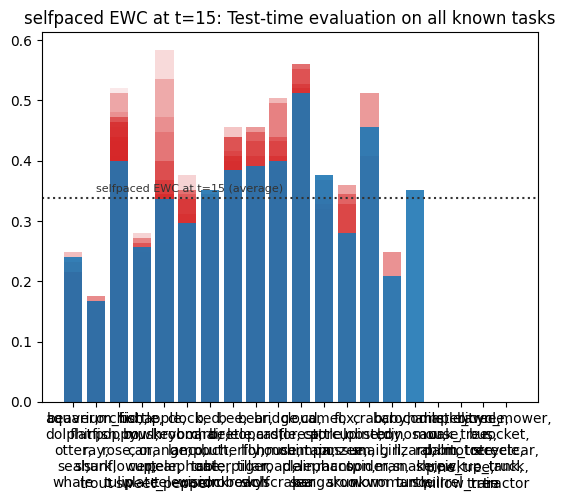


=== Training Task 16 ===
  Using self-paced curriculum learning with EWC
Task 16 | Epoch 0 | loss: 1.810/1.588 | acc: 25.3%/27.4%
  self-paced threshold: 2.000
Task 16 | Epoch 1 | loss: 1.782/1.566 | acc: 30.5%/30.8%
  self-paced threshold: 2.000
Task 16 | Epoch 2 | loss: 1.760/1.540 | acc: 33.3%/32.7%
  self-paced threshold: 2.000
Task 16 | Epoch 3 | loss: 1.735/1.518 | acc: 33.2%/32.8%
  self-paced threshold: 2.000
Task 16 | Epoch 4 | loss: 1.705/1.500 | acc: 35.9%/33.5%
  self-paced threshold: 2.000
Task 16 | Epoch 5 | loss: 1.664/1.491 | acc: 37.6%/34.2%
  self-paced threshold: 2.000
Task 16 | Epoch 6 | loss: 1.607/1.521 | acc: 38.9%/30.4%
  self-paced threshold: 2.000
Task 16 | Epoch 7 | loss: 1.565/1.516 | acc: 39.0%/33.2%
  self-paced threshold: 2.000
Task 16 | Epoch 8 | loss: 1.520/1.535 | acc: 41.0%/33.2%
  self-paced threshold: 2.000
Task 16 | Epoch 9 | loss: 1.478/1.505 | acc: 42.7%/34.2%
  self-paced threshold: 2.000


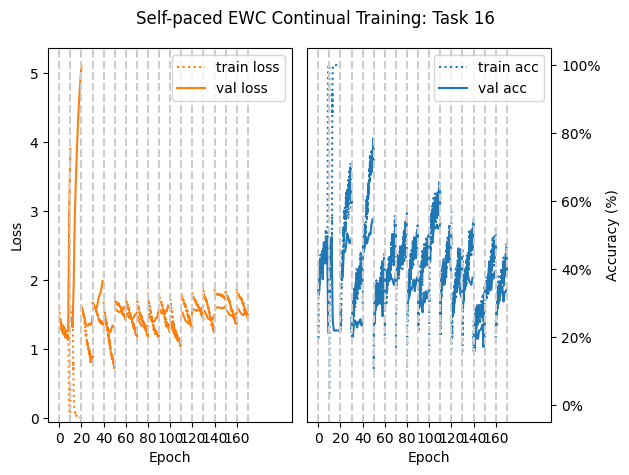

Selfpaced ewc at t=16 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 44.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 40.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 36.80%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 34.40%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 41.60%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 46.40%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 40.00%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 50.40%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 36.00%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 36.80%
['crab', 'lobster', 'snail', 'spider', 'worm']: 40.80%
['baby', 'boy', 'girl', 'man', 'woman']: 25.60%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 31.20%
['h

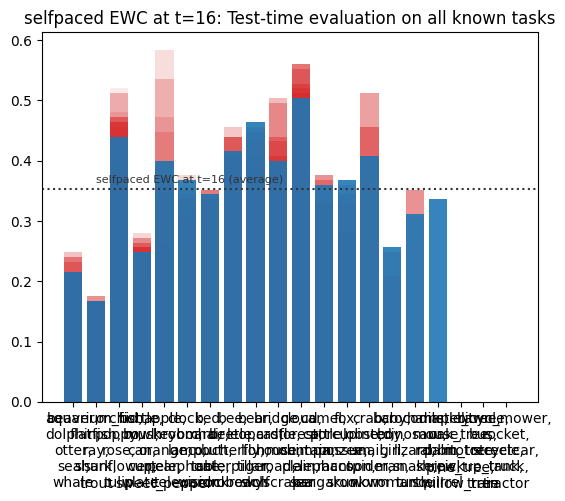


=== Training Task 17 ===
  Using self-paced curriculum learning with EWC
Task 17 | Epoch 0 | loss: 1.786/1.529 | acc: 26.0%/32.7%
  self-paced threshold: 2.000
Task 17 | Epoch 1 | loss: 1.745/1.485 | acc: 36.2%/40.4%
  self-paced threshold: 2.000
Task 17 | Epoch 2 | loss: 1.690/1.446 | acc: 38.6%/40.7%
  self-paced threshold: 2.000
Task 17 | Epoch 3 | loss: 1.609/1.420 | acc: 43.1%/42.2%
  self-paced threshold: 2.000
Task 17 | Epoch 4 | loss: 1.540/1.405 | acc: 44.9%/43.2%
  self-paced threshold: 2.000
Task 17 | Epoch 5 | loss: 1.473/1.405 | acc: 46.3%/44.4%
  self-paced threshold: 2.000
Task 17 | Epoch 6 | loss: 1.415/1.405 | acc: 48.8%/40.7%
  self-paced threshold: 2.000
Task 17 | Epoch 7 | loss: 1.379/1.408 | acc: 47.7%/43.7%
  self-paced threshold: 2.000
Task 17 | Epoch 8 | loss: 1.328/1.448 | acc: 49.0%/44.6%
  self-paced threshold: 2.000
Task 17 | Epoch 9 | loss: 1.289/1.441 | acc: 50.5%/44.7%
  self-paced threshold: 2.000


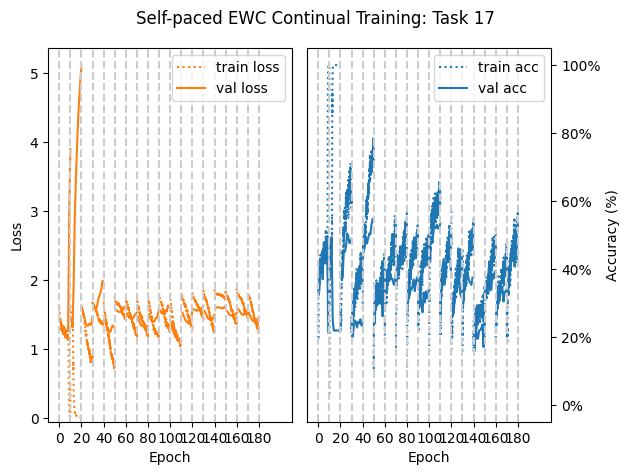

Selfpaced ewc at t=17 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 44.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 39.20%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 32.80%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 35.20%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 45.60%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 44.00%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 39.20%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 48.00%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 38.40%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 36.00%
['crab', 'lobster', 'snail', 'spider', 'worm']: 40.00%
['baby', 'boy', 'girl', 'man', 'woman']: 22.40%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 35.20%
['h

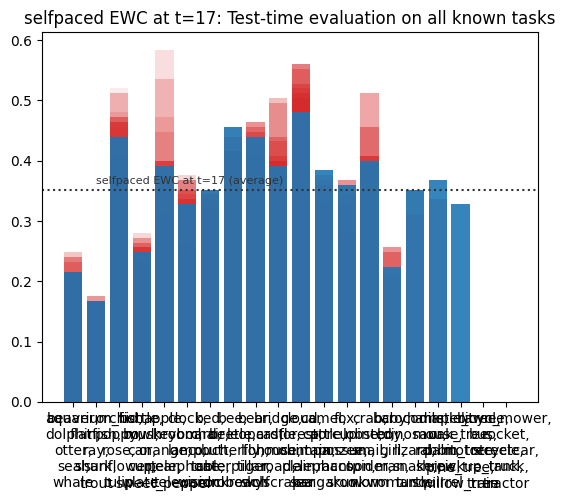


=== Training Task 18 ===
  Using self-paced curriculum learning with EWC
Task 18 | Epoch 0 | loss: 1.825/1.605 | acc: 23.3%/23.9%
  self-paced threshold: 2.000
Task 18 | Epoch 1 | loss: 1.806/1.591 | acc: 27.7%/25.5%
  self-paced threshold: 2.000
Task 18 | Epoch 2 | loss: 1.792/1.585 | acc: 29.4%/25.5%
  self-paced threshold: 2.000
Task 18 | Epoch 3 | loss: 1.781/1.581 | acc: 29.4%/25.8%
  self-paced threshold: 2.000
Task 18 | Epoch 4 | loss: 1.772/1.554 | acc: 31.5%/31.5%
  self-paced threshold: 2.000
Task 18 | Epoch 5 | loss: 1.759/1.536 | acc: 32.6%/33.1%
  self-paced threshold: 2.000
Task 18 | Epoch 6 | loss: 1.742/1.543 | acc: 33.6%/30.5%
  self-paced threshold: 2.000
Task 18 | Epoch 7 | loss: 1.713/1.555 | acc: 34.7%/30.5%
  self-paced threshold: 2.000
Task 18 | Epoch 8 | loss: 1.672/1.536 | acc: 37.1%/31.7%
  self-paced threshold: 2.000
Task 18 | Epoch 9 | loss: 1.641/1.524 | acc: 37.0%/38.4%
  self-paced threshold: 2.000


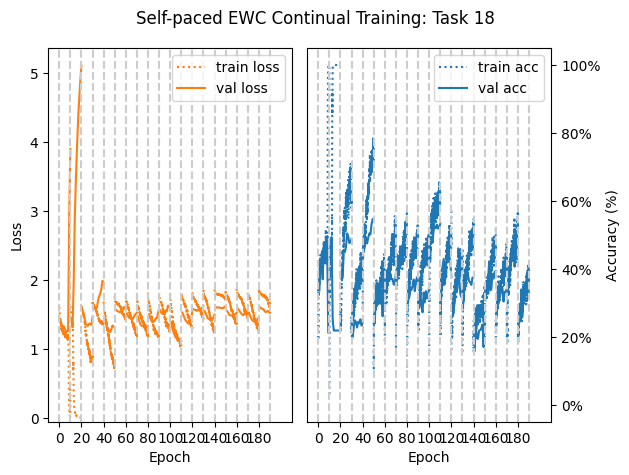

Selfpaced ewc at t=18 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 48.00%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 36.80%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 29.60%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 37.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 42.40%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 44.80%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 40.80%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 47.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 36.00%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 34.40%
['crab', 'lobster', 'snail', 'spider', 'worm']: 44.00%
['baby', 'boy', 'girl', 'man', 'woman']: 22.40%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 26.40%
['h

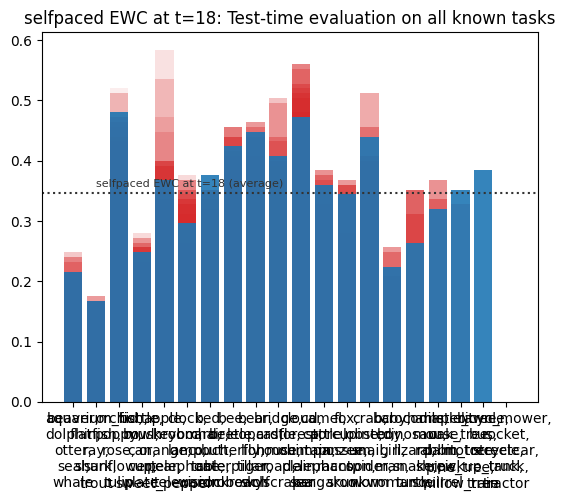


=== Training Task 19 ===
  Using self-paced curriculum learning with EWC
Task 19 | Epoch 0 | loss: 1.782/1.507 | acc: 35.8%/37.9%
  self-paced threshold: 2.000
Task 19 | Epoch 1 | loss: 1.710/1.462 | acc: 44.2%/41.1%
  self-paced threshold: 2.000
Task 19 | Epoch 2 | loss: 1.651/1.418 | acc: 48.2%/43.3%
  self-paced threshold: 2.000
Task 19 | Epoch 3 | loss: 1.583/1.369 | acc: 50.5%/44.6%
  self-paced threshold: 2.000
Task 19 | Epoch 4 | loss: 1.515/1.341 | acc: 51.5%/46.5%
  self-paced threshold: 2.000
Task 19 | Epoch 5 | loss: 1.446/1.315 | acc: 54.5%/42.8%
  self-paced threshold: 2.000
Task 19 | Epoch 6 | loss: 1.391/1.282 | acc: 55.4%/45.6%
  self-paced threshold: 2.000
Task 19 | Epoch 7 | loss: 1.320/1.275 | acc: 57.9%/47.0%
  self-paced threshold: 2.000
Task 19 | Epoch 8 | loss: 1.251/1.264 | acc: 61.3%/45.7%
  self-paced threshold: 2.000
Task 19 | Epoch 9 | loss: 1.220/1.294 | acc: 61.7%/48.6%
  self-paced threshold: 2.000


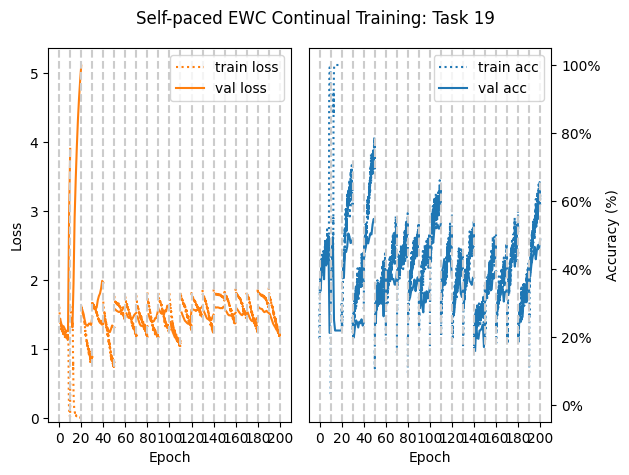

Selfpaced ewc at t=19 evaluation on test set of all tasks:
['beaver', 'dolphin', 'otter', 'seal', 'whale']: 21.60%
['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']: 16.80%
['orchid', 'poppy', 'rose', 'sunflower', 'tulip']: 46.40%
['bottle', 'bowl', 'can', 'cup', 'plate']: 24.80%
['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']: 40.00%
['clock', 'keyboard', 'lamp', 'telephone', 'television']: 32.80%
['bed', 'chair', 'couch', 'table', 'wardrobe']: 33.60%
['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']: 42.40%
['bear', 'leopard', 'lion', 'tiger', 'wolf']: 42.40%
['bridge', 'castle', 'house', 'road', 'skyscraper']: 48.00%
['cloud', 'forest', 'mountain', 'plain', 'sea']: 47.20%
['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']: 39.20%
['fox', 'porcupine', 'possum', 'raccoon', 'skunk']: 28.80%
['crab', 'lobster', 'snail', 'spider', 'worm']: 48.00%
['baby', 'boy', 'girl', 'man', 'woman']: 23.20%
['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']: 32.80%
['h

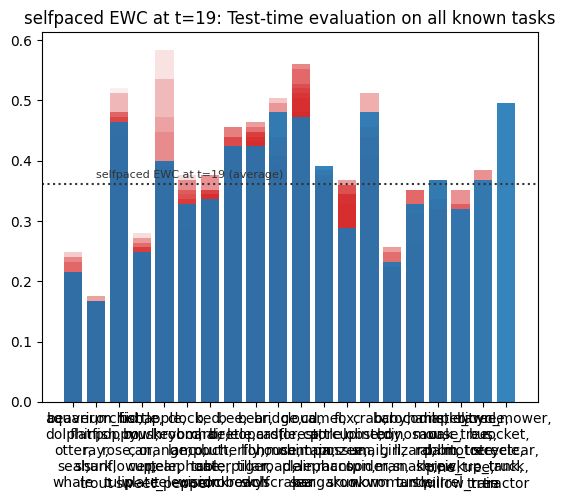

(MultitaskModel(
   (backbone): Conv4Backbone(
     (conv_stack): Sequential(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (1): GroupNorm(8, 32, eps=1e-05, affine=True)
       (2): ReLU()
       (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (4): GroupNorm(16, 64, eps=1e-05, affine=True)
       (5): ReLU()
       (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (7): GroupNorm(16, 64, eps=1e-05, affine=True)
       (8): ReLU()
       (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (10): GroupNorm(32, 128, eps=1e-05, affine=True)
       (11): ReLU()
     )
     (pool): AdaptiveAvgPool2d(output_size=(1, 1))
     (relu): ReLU()
   )
   (task_heads): ModuleDict(
     (0): TaskHead(
       (projection): Linear(in_features=128, out_features=64, bias=True)
       (classifier): Linear(in_features=64, out_features=5, bias=True)
       (dropout): Identity()
       (relu): ReLU

In [18]:
train_ewc_loop(timestep_tasks, task_test_sets, INPUT_SIZE, use_selfpaced=True)

----------------------------------------------------------------------------------------------

In [19]:
# we can verify that drawing a sample from this data produces a (image, label, task_id) triplet:

example = task_train[0]
image, label, task_id = example

print(f'\n image: {type(image)}  of shape {image.shape}')

print(f'\n label: {label}   (class: {task_train.classes[label]})')

print(f'\n task id: {task_id}   (classification between: {timestep_task_classes[int(task_id)]})')



 image: <class 'torch.Tensor'>  of shape torch.Size([3, 32, 32])

 label: 1   (class: rocket)

 task id: 19   (classification between: ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'])
